In [ ]:
 pip install mne pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.7 MB/s eta 0:00:00
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734979 sha256=09bd709ef4cec65a6ecb9476675c2e75bb945eaba06f436f5c3719b7689d1007
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib


In [ ]:
from google.colab import drive
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import numpy as np
import pyedflib
import os

# Directory containing EDF files
# directory = '/content/drive/MyDrive/dataverse_files(2)'
directory = '/content/drive/MyDrive/dataverse_files'

# Use glob to get a list of EDF file paths
myfiles = glob.glob(directory + '/*.edf')

# Sampling rate of your signals
sampling_rate = 250  # Hz
epoch_length = sampling_rate * 2  # 2 seconds = 500 samples per epoch
num_samples_per_subject = 50  # Number of 2-second epochs to extract from each subject

# Function to adjust EEG signal length to the nearest multiple of epoch length
def adjust_signal_length(signal, epoch_length):
    # Calculate the number of epochs that can be extracted
    num_epochs = len(signal) // epoch_length
    if num_epochs == 0:
        return np.array([])  # Return empty array if not enough data
    return signal[:num_epochs * epoch_length]  # Keep only the data that can be fully divided

# Function to extract 2-second epochs directly from the signal
def extract_epochs(signal, epoch_length):
    num_epochs = len(signal) // epoch_length
    epochs = []
    for i in range(num_epochs):
        start = i * epoch_length
        end = start + epoch_length
        epochs.append(signal[start:end])
    return epochs

# Function to randomly select a specified number of epochs
def select_random_samples(epochs, num_samples):
    epochs_array = np.array(epochs)  # Convert to a NumPy array
    if len(epochs_array) <= num_samples:
        return epochs_array  # If there are fewer epochs than needed, return all
    indices = np.random.choice(len(epochs_array), num_samples, replace=False)
    return epochs_array[indices]  # Select the samples by indices

# Initialize lists to store epochs for unhealthy and healthy signals
# Assume maximum of 19 channels and 14 subjects
num_channels = 19
num_subjects = 14
num_epochs = num_samples_per_subject
epoch_length = 500

# Initialize multidimensional arrays to store epochs
healthy_data = np.empty((num_subjects, num_channels, num_epochs, epoch_length))
unhealthy_data = np.empty((num_subjects, num_channels, num_epochs, epoch_length))

# Initialize counters for subjects
healthy_subject_counter = 0
unhealthy_subject_counter = 0

# Process each file
for file in myfiles:
    # Open the EDF file
    f = pyedflib.EdfReader(file)

    # Get signal labels (channel names)
    signal_labels = f.getSignalLabels()

    # Extract the filename and determine if the subject is healthy or unhealthy
    filename = file.split('/')[-1]
    subject_type = 'healthy' if 'h' in filename else 'unhealthy'

    # Initialize temporary storage for epochs
    temp_epochs = {label: [] for label in signal_labels}

    # Process each channel (electrode)
    for i, label in enumerate(signal_labels):
        signal = f.readSignal(i)

        # Adjust the signal length to the nearest multiple of epoch length
        adjusted_signal = adjust_signal_length(signal, epoch_length)

        # Extract 2-second epochs directly from the signal
        epochs = extract_epochs(adjusted_signal, epoch_length)

        # Select 50 random epochs if there are enough, otherwise use all available
        selected_epochs = select_random_samples(epochs, num_samples_per_subject)

        # Store epochs in temporary storage
        temp_epochs[label] = selected_epochs

    # Store the epochs in the appropriate multidimensional array
    if subject_type == 'healthy':
        for ch in range(num_channels):
            if ch < len(signal_labels):  # Ensure channel exists
                healthy_data[healthy_subject_counter, ch, :, :] = temp_epochs[signal_labels[ch]]
        healthy_subject_counter += 1
    else:
        for ch in range(num_channels):
            if ch < len(signal_labels):  # Ensure channel exists
                unhealthy_data[unhealthy_subject_counter, ch, :, :] = temp_epochs[signal_labels[ch]]
        unhealthy_subject_counter += 1

    f._close()  # Close the EDF file

# Check dimensions and save the data
print(f"Healthy Data Shape: {healthy_data.shape}")
print(f"Unhealthy Data Shape: {unhealthy_data.shape}")

# Optionally save the data to disk
np.save('healthy_data.npy', healthy_data)
np.save('unhealthy_data.npy', unhealthy_data)


Healthy Data Shape: (14, 19, 50, 500)
Unhealthy Data Shape: (14, 19, 50, 500)


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Define dimensions
num_subjects = 14
num_channels = 19
num_epochs = 50
samples_per_epoch = 500

# Create random healthy data
# healthy_data _epoch)

# Define channel labels
signal_labels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

# new
#signal_labels = [
 #   "Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz", "T3", "T4", "T5", "T6"
#]

# Initialize a list to store rows of tabular data
tabular_data = []

# Iterate through each subject, channel, and epoch to flatten the data
for subject in range(num_subjects):
    for channel in range(num_channels):
        for epoch in range(num_epochs):
            # Extract the signal for the current subject, channel, and epoch
            signal = healthy_data[subject, channel, epoch, :]

            # Create a row with metadata and the signal values
            row = {
                'Subject_ID': subject + 1,
                'Channel': signal_labels[channel],
                'Epoch': epoch + 1,
                'Signal_Values': list(signal)  # Convert numpy array to a list for better readability
            }

            # Append the row to the list
            tabular_data.append(row)

# Create a DataFrame from the list of rows
df_healthy = pd.DataFrame(tabular_data)

# Display the first few rows of the DataFrame
print(df_healthy.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df_healthy.to_csv('healthy_data_tabular.csv', index=False)

# Optionally, display the DataFrame in a tabular format in Google Colab
display(df_healthy)


   Subject_ID Channel  Epoch  \
0           1     Fp1      1   
1           1     Fp1      2   
2           1     Fp1      3   
3           1     Fp1      4   
4           1     Fp1      5   

                                       Signal_Values  
0  [12.234910657062619, 10.400049058503091, 8.259...  
1  [1.3786461989187526, 5.048369396037806, 6.2716...  
2  [8.259377193516977, 10.858764458142973, 11.623...  
3  [-22.933269981994975, -20.02807245094239, -18....  
4  [-0.30331026642748005, -0.9149307992806556, -1...  


Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  
0      [12.234910657062619, 10.400049058503091, 8.259...  
1      [1.3786461989187526, 5.048369396037806, 6.2716...  
2      [8.259377193516977, 10.858764458142973, 11.623...  
3      [-22.933269981994975, -20.02807245094239, -18....  
4      [-0.30331026642748005, -0.9149307992806556, -1...  
...                                                  ...  
13295  [3.519318063904867, 2.44898213141181, -0.45621...  
13296  [0.3083102664256955, 0.0024999999991076978, 0....  
13297  [1.3786461989187526, 0.15540513321240157, 3.67...  
13298  [-3.6672231971199456, -2.2910769982003005, -0....  
13299  [11.623290124209444, 12.387815790275912, 9.329...  

[13300 rows x 4 columns]

In [ ]:
import pandas as pd

# Initialize a list to store rows of tabular data for unhealthy data
tabular_data_unhealthy = []

# Iterate through each subject, channel, and epoch to flatten the unhealthy data
for subject in range(num_subjects):
    for channel in range(num_channels):
        for epoch in range(num_epochs):
            # Extract the signal for the current subject, channel, and epoch
            signal = unhealthy_data[subject, channel, epoch, :]

            # Create a row with metadata and the signal values
            row = {
                'Subject_ID': subject + 1,
                'Channel': signal_labels[channel],
                'Epoch': epoch + 1,
                'Signal_Values': list(signal)  # Convert numpy array to a list for better readability
            }

            # Append the row to the list
            tabular_data_unhealthy.append(row)

# Create a DataFrame from the list of rows for unhealthy data
df_unhealthy = pd.DataFrame(tabular_data_unhealthy)

# Display the first few rows of the DataFrame
print(df_unhealthy.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df_unhealthy.to_csv('unhealthy_data_tabular.csv', index=False)

# Optionally, display the DataFrame in a tabular format in Google Colab
from IPython.display import display
display(df_unhealthy)


   Subject_ID Channel  Epoch  \
0           1     Fp1      1   
1           1     Fp1      2   
2           1     Fp1      3   
3           1     Fp1      4   
4           1     Fp1      5   

                                       Signal_Values  
0  [-7.336946394238999, -9.630523392438407, -7.94...  
1  [1.2257410657054588, 1.2257410657054588, -1.22...  
2  [-9.324713126011819, -6.878230994599117, -6.87...  
3  [-0.45621539964077396, 0.7670256660655771, 5.9...  
4  [3.6722231971181607, -5.043369396039591, -5.04...  


Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  
0      [-7.336946394238999, -9.630523392438407, -7.94...  
1      [1.2257410657054588, 1.2257410657054588, -1.22...  
2      [-9.324713126011819, -6.878230994599117, -6.87...  
3      [-0.45621539964077396, 0.7670256660655771, 5.9...  
4      [3.6722231971181607, -5.043369396039591, -5.04...  
...                                                  ...  
13295  [10.73195469527235, 4.470772789696619, -5.1893...  
13296  [-8.588263756218478, -2.5059727622306243, -2.6...  
13297  [23.075427594835936, 17.708700247199594, 18.06...  
13298  [-3.400427320170014, -2.5059727622306243, 2.86...  
13299  [15.562009308145058, 10.195281960508716, 10.01...  

[13300 rows x 4 columns]

Direct approach

In [ ]:
# pip install numpy pandas pyinform
!pip install --upgrade pyinform
!pip install antropy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import entropy as shannon_entropy
import antropy as ant

# Function to calculate Shannon Entropy
def calculate_shannon_entropy(signal):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = [count / total_count for count in counter.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# Function to calculate Approximate Entropy
def calculate_approximate_entropy(signal, m=2, r=0.2):
    return ant.app_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Sample Entropy
def calculate_sample_entropy(signal, m=2, r=0.2):
    return ant.sample_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Tsallis Entropy
def calculate_tsallis_entropy(signal, q=2):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = np.array([count / total_count for count in counter.values()])
    tsallis = (1 - np.sum(probabilities ** q)) / (q - 1) if q != 1 else calculate_shannon_entropy(signal)
    return tsallis

# Function to calculate Spectral Entropy
def calculate_spectral_entropy(signal, sampling_frequency=1):
    return ant.spectral_entropy(signal, sf=sampling_frequency, method="welch", normalize=True)


# Load CSV data
input_file = 'healthy_data_tabular.csv'  # Replace with your actual file
data = pd.read_csv(input_file)

# Ensure Signal_Values is parsed as a list of floats
data['Signal_Values'] = data['Signal_Values'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize new columns
data['Shannon_Entropy'] = data['Signal_Values'].apply(calculate_shannon_entropy)
data['Approximate_Entropy'] = data['Signal_Values'].apply(calculate_approximate_entropy)
data['Sample_Entropy'] = data['Signal_Values'].apply(calculate_sample_entropy)
data['Tsallis_Entropy'] = data['Signal_Values'].apply(calculate_tsallis_entropy)
data['Spectral_Entropy'] = data['Signal_Values'].apply(calculate_spectral_entropy)
# data['Fuzzy_Entropy'] = data['Signal_Values'].apply(calculate_fuzzy_entropy)

# Save updated data to a new CSV
output_file = 'data_with_entropies.csv'
data.to_csv(output_file, index=False)

print(f"Entropy calculations complete. Results saved to {output_file}.")


/usr/local/lib/python3.11/dist-packages/antropy/entropy.py:255: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


In [ ]:

input_file = 'data_with_entropies.csv'  # Replace with your actual file name
hdata = pd.read_csv(input_file)
hdata

Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  Shannon_Entropy  \
0      [np.float64(1.2257410657054588), np.float64(1....         7.749999   
1      [np.float64(8.870997726370152), np.float64(9.7...         7.469917   
2      [np.float64(38.68749870296246), np.float64(36....         7.200896   
3      [np.float64(5.354179662464394), np.float64(-0....         7.861710   
4      [np.float64(8.71809259315686), np.float64(6.73...         7.796038   
...                                                  ...              ...   
13295  [np.float64(12.082005523849324), np.float64(8....         7.066555   
13296  [np.float64(-12.229910657064403), np.float64(-...         6.847926   
13297  [np.float64(2.44898213141181), np.float64(0.30...         6.067541   
13298  [np.float64(-0.45621539964077396), np.float64(...         3.176529   
13299  [np.float64(-0.9149307992806556), np.float64(-...         6.411108   

       Approximate_Entropy  Sample_Entropy  Tsallis_Entropy  Spectral_Entropy  
0                 0.585656        0.535486         0.994440          0.511985  
1                 0.806886        0.841969         0.993336          0.557511  
2                 0.836598        0.866772         0.992168          0.605160  
3                 0.712954        0.720416         0.994936          0.464355  
4                 0.703083        0.700550         0.994488          0.479315  
...                    ...             ...              ...               ...  
13295             1.106060        1.197940         0.991104          0.640974  
13296             1.102875        1.192587         0.988992          0.625994  
13297             1.334938        1.849516         0.981848          0.752181  
13298             0.268467        0.034112         0.605288          0.696250  
13299             1.250790        1.481130         0.986240          0.708951  

[13300 rows x 9 columns]

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import entropy as shannon_entropy
import antropy as ant

# Function to calculate Shannon Entropy
def calculate_shannon_entropy(signal):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = [count / total_count for count in counter.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# Function to calculate Approximate Entropy
def calculate_approximate_entropy(signal, m=2, r=0.2):
    return ant.app_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Sample Entropy
def calculate_sample_entropy(signal, m=2, r=0.2):
    return ant.sample_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Tsallis Entropy
def calculate_tsallis_entropy(signal, q=2):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = np.array([count / total_count for count in counter.values()])
    tsallis = (1 - np.sum(probabilities ** q)) / (q - 1) if q != 1 else calculate_shannon_entropy(signal)
    return tsallis

# Function to calculate Spectral Entropy
def calculate_spectral_entropy(signal, sampling_frequency=1):
    return ant.spectral_entropy(signal, sf=sampling_frequency, method="welch", normalize=True)

# Load CSV data
input_file = 'unhealthy_data_tabular.csv'  # Replace with your actual file
data = pd.read_csv(input_file)

# Ensure Signal_Values is parsed as a list of floats
data['Signal_Values'] = data['Signal_Values'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize new columns
data['Shannon_Entropy'] = data['Signal_Values'].apply(calculate_shannon_entropy)
data['Approximate_Entropy'] = data['Signal_Values'].apply(calculate_approximate_entropy)
data['Sample_Entropy'] = data['Signal_Values'].apply(calculate_sample_entropy)
data['Tsallis_Entropy'] = data['Signal_Values'].apply(calculate_tsallis_entropy)
data['Spectral_Entropy'] = data['Signal_Values'].apply(calculate_spectral_entropy)

# Save updated data to a new CSV
output_file = 'data_with_unentropies.csv'
data.to_csv(output_file, index=False)

print(f"Entropy calculations complete. Results saved to {output_file}.")


/usr/local/lib/python3.11/dist-packages/antropy/entropy.py:255: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


Entropy calculations complete. Results saved to data_with_unentropies.csv.


In [ ]:
input_file = 'data_with_unentropies.csv'  # Replace with your actual file name
data = pd.read_csv(input_file)
data

Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  Shannon_Entropy  \
0      [np.float64(5.2012745292511), np.float64(3.213...         7.660587   
1      [np.float64(6.883230994597333), np.float64(6.2...         6.823196   
2      [np.float64(0.0024999999991076978), np.float64...         7.811839   
3      [np.float64(9.176807992796741), np.float64(8.5...         7.223389   
4      [np.float64(-5.9608001953193535), np.float64(-...         6.980779   
...                                                  ...              ...   
13295  [np.float64(4.112990966520863), np.float64(17....         7.541736   
13296  [np.float64(11.984191076387496), np.float64(11...         7.549787   
13297  [np.float64(4.8285546128723755), np.float64(24...         7.542999   
13298  [np.float64(11.984191076387496), np.float64(18...         7.564761   
13299  [np.float64(15.919791131320814), np.float64(7....         7.440097   

       Approximate_Entropy  Sample_Entropy  Tsallis_Entropy  Spectral_Entropy  
0                 0.670178        0.600766         0.993952          0.563854  
1                 0.905834        0.940326         0.989792          0.613021  
2                 0.832883        0.801538         0.994832          0.557589  
3                 0.685214        0.667865         0.991488          0.517891  
4                 0.740837        0.740787         0.990320          0.637936  
...                    ...             ...              ...               ...  
13295             0.501981        0.471317         0.994016          0.362755  
13296             0.484438        0.455102         0.993832          0.326506  
13297             0.526729        0.495092         0.993816          0.295781  
13298             0.370852        0.339285         0.994008          0.286895  
13299             0.640498        0.671207         0.993376          0.375382  

[13300 rows x 9 columns]

In [ ]:
import pandas as pd

# Assuming your data is loaded into a DataFrame called 'df'
# Example: df = pd.read_csv('your_data.csv')

# List of entropy measures
entropy_measures = ['Shannon_Entropy', 'Approximate_Entropy', 'Sample_Entropy', 'Tsallis_Entropy', 'Spectral_Entropy']

# Initialize an empty list to store the feature vectors
feature_vectors = []
df = data
# Group by Subject_ID and Epoch
for (subject_id, epoch), group in df.groupby(['Subject_ID', 'Epoch']):
    # Initialize a list for the feature vector
    feature_vector = []

    # Loop through each channel (19 channels)
    for channel in group['Channel'].unique():
        # Extract the entropy measures for the current channel
        channel_data = group[group['Channel'] == channel]

        # Append the entropy measures to the feature vector
        for entropy in entropy_measures:
            feature_vector.append(channel_data[entropy].values[0])

    # Append the feature vector for the current subject and epoch
    feature_vectors.append(feature_vector)

# Convert the feature vectors into a DataFrame
feature_df = pd.DataFrame(feature_vectors, columns=[f"{channel}_{entropy}" for channel in df['Channel'].unique() for entropy in entropy_measures])

# Display the resulting feature DataFrame
print(feature_df)



     Fp1_Shannon_Entropy  Fp1_Approximate_Entropy  Fp1_Sample_Entropy  \
0               7.660587                 0.670178            0.600766   
1               6.823196                 0.905834            0.940326   
2               7.811839                 0.832883            0.801538   
3               7.223389                 0.685214            0.667865   
4               6.980779                 0.740837            0.740787   
..                   ...                      ...                 ...   
695             7.649446                 0.578968            0.577747   
696             7.567529                 0.635215            0.632649   
697             7.581093                 0.635024            0.668142   
698             7.826078                 0.755481            0.760039   
699             7.601898                 0.671883            0.671182   

     Fp1_Tsallis_Entropy  Fp1_Spectral_Entropy  Fp2_Shannon_Entropy  \
0               0.993952              0.563854      

In [ ]:
# Save the resulting feature DataFrame to a CSV file
feature_df.to_csv('feature_vectors.csv', index=False)


In [ ]:
import pandas as pd

# Assuming your data is loaded into a DataFrame called 'df'
# Example: df = pd.read_csv('your_data.csv')

# List of entropy measures
entropy_measures = ['Shannon_Entropy', 'Approximate_Entropy', 'Sample_Entropy', 'Tsallis_Entropy', 'Spectral_Entropy']

# Initialize an empty list to store the feature vectors
feature_vectors = []
df = hdata
# Group by Subject_ID and Epoch
for (subject_id, epoch), group in df.groupby(['Subject_ID', 'Epoch']):
    # Initialize a list for the feature vector
    feature_vector = []

    # Loop through each channel (19 channels)
    for channel in group['Channel'].unique():
        # Extract the entropy measures for the current channel
        channel_data = group[group['Channel'] == channel]

        # Append the entropy measures to the feature vector
        for entropy in entropy_measures:
            feature_vector.append(channel_data[entropy].values[0])

    # Append the feature vector for the current subject and epoch
    feature_vectors.append(feature_vector)

# Convert the feature vectors into a DataFrame
feature_df = pd.DataFrame(feature_vectors, columns=[f"{channel}_{entropy}" for channel in df['Channel'].unique() for entropy in entropy_measures])

# Display the resulting feature DataFrame
print(feature_df)



     Fp1_Shannon_Entropy  Fp1_Approximate_Entropy  Fp1_Sample_Entropy  \
0               7.749999                 0.585656            0.535486   
1               7.469917                 0.806886            0.841969   
2               7.200896                 0.836598            0.866772   
3               7.861710                 0.712954            0.720416   
4               7.796038                 0.703083            0.700550   
..                   ...                      ...                 ...   
695             7.918858                 0.578771            0.497028   
696             7.529996                 0.995571            1.041486   
697             7.483679                 0.892854            0.888784   
698             7.629117                 1.003051            1.055486   
699             7.683555                 1.061297            1.099989   

     Fp1_Tsallis_Entropy  Fp1_Spectral_Entropy  Fp2_Shannon_Entropy  \
0               0.994440              0.511985      

In [ ]:
# Save the resulting feature DataFrame to a CSV file
feature_df.to_csv('hfeature_vectors.csv', index=False)

In [ ]:
import pandas as pd

# Load the CSV files
feature_df = pd.read_csv('feature_vectors.csv')
hfeature_df = pd.read_csv('hfeature_vectors.csv')

# Add a Label column
feature_df['Label'] = 1
hfeature_df['Label'] = 0

# Concatenate the DataFrames
combined_df = pd.concat([feature_df, hfeature_df], ignore_index=True)

# Shuffle the combined DataFrame
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled DataFrame to a new CSV file
shuffled_df.to_csv('shuffled_combined_features.csv', index=False)

# Print a success message
print("Files combined, shuffled, and saved as 'shuffled_combined_features.csv'.")

Files combined, shuffled, and saved as 'shuffled_combined_features.csv'.


SVM


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(report)


Accuracy: 0.90

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       140
           1       0.91      0.89      0.90       140

    accuracy                           0.90       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.90      0.90      0.90       280



Accuracy: 0.91

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        70
           1       0.94      0.89      0.91        70

    accuracy                           0.91       140
   macro avg       0.92      0.91      0.91       140
weighted avg       0.92      0.91      0.91       140



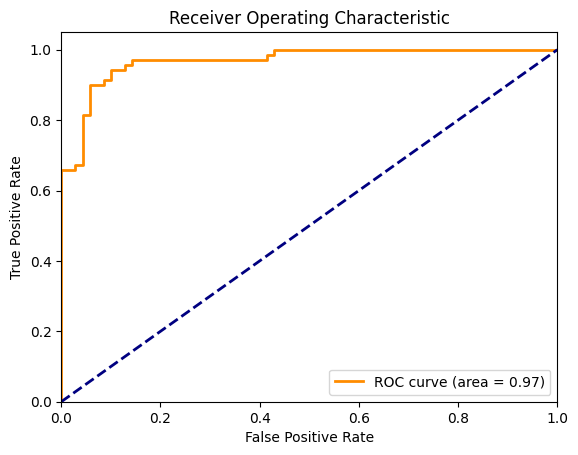

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# Initialize the SVM model with probability=True for ROC curve
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(report)

# Compute ROC curve and AUC for each class
y_score = svm_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])  # Assuming binary classification
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

for a in range(100):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=a, stratify=y)

  # Initialize the SVM model
  svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.

  # Train the SVM model
  svm_model.fit(X_train, y_train)

  # Predict the test set
  y_pred = svm_model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  # Print the results
  print(f"Accuracy: {accuracy:.4f}")
  print("\nClassification Report:\n")
  print(report)


Accuracy: 0.8929

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        70
           1       0.88      0.91      0.90        70

    accuracy                           0.89       140
   macro avg       0.89      0.89      0.89       140
weighted avg       0.89      0.89      0.89       140

Accuracy: 0.9000

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.90        70
           1       0.88      0.93      0.90        70

    accuracy                           0.90       140
   macro avg       0.90      0.90      0.90       140
weighted avg       0.90      0.90      0.90       140

Accuracy: 0.9143

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        70
           1       0.90      0.93      0.92        70

    accuracy                           0.91       140
  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# List to store accuracies
accuracies = []

for a in range(100):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=a, stratify=y)

    # Initialize the SVM model
    svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.

    # Train the SVM model
    svm_model.fit(X_train, y_train)

    # Predict the test set
    y_pred = svm_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Print the results
    print(f"Random State {a}: Accuracy: {accuracy:.2f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

# Compute the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"\nAverage Accuracy over 100 iterations: {average_accuracy:.2f}")


Random State 0: Accuracy: 0.88

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       140
           1       0.87      0.89      0.88       140

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.87       280
weighted avg       0.88      0.88      0.87       280

Random State 1: Accuracy: 0.88

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       140
           1       0.88      0.88      0.88       140

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.88       280
weighted avg       0.88      0.88      0.88       280

Random State 2: Accuracy: 0.91

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       140
           1       0.90      0.93      0.91       140

    accuracy  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Fill null values with the average of the respective columns
data.fillna(data.mean(), inplace=True)

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(report)


Accuracy: 0.90

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       140
           1       0.91      0.89      0.90       140

    accuracy                           0.90       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.90      0.90      0.90       280



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Fill null values with the average of the respective columns
data.fillna(data.mean(), inplace=True)

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(report)


Accuracy: 0.96

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       140
           1       0.96      0.95      0.96       140

    accuracy                           0.96       280
   macro avg       0.96      0.96      0.96       280
weighted avg       0.96      0.96      0.96       280



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Fill null values with the average of the respective columns
data.fillna(data.mean(), inplace=True)

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column
for a in range(100):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=a, stratify=y)

  # Initialize the Random Forest model
  rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

  # Train the Random Forest model
  rf_model.fit(X_train, y_train)

  # Predict the test set
  y_pred = rf_model.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  # Print the results
  print(f"Accuracy: {accuracy:.2f}")
  print("\nClassification Report:\n")
  print(report)


Accuracy: 0.94

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       140
           1       0.94      0.93      0.94       140

    accuracy                           0.94       280
   macro avg       0.94      0.94      0.94       280
weighted avg       0.94      0.94      0.94       280

Accuracy: 0.93

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       140
           1       0.95      0.91      0.93       140

    accuracy                           0.93       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280

Accuracy: 0.97

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       140
           1       0.98      0.96      0.97       140

    accuracy                           0.97       280
   macro

**ELM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load datasets
healthy_df = pd.read_csv('hfeature_vectors.csv')
unhealthy_df = pd.read_csv('feature_vectors.csv')

# Add labels
healthy_df['Label'] = 0  # Label for healthy
unhealthy_df['Label'] = 1  # Label for unhealthy

# Combine datasets
data = pd.concat([healthy_df, unhealthy_df], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
# data = pd.read_csv('shuffled_combined_features.csv')
# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ELM class
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        # Calculate the hidden layer output (H)
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Compute the output weights (β) using Moore-Penrose pseudoinverse
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        # Calculate the hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Calculate predictions
        return np.dot(H, self.output_weights)

# Initialize ELM
hidden_neurons = 100  # You can adjust the number of hidden neurons
elm = ExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train ELM
elm.fit(X_train, y_train)

# Predict on the test set
y_pred = elm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"ELM Accuracy: {accuracy * 100:.2f}%")


ELM Accuracy: 82.50%


ELM Accuracy: 87.14%


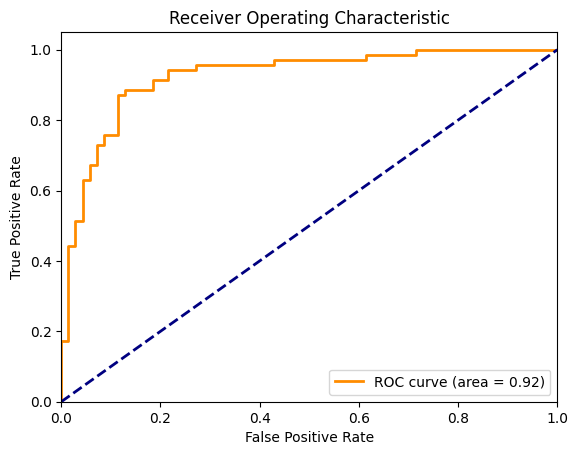

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load datasets
# healthy_df = pd.read_csv('hfeature_vectors.csv')
# unhealthy_df = pd.read_csv('feature_vectors.csv')

# Add labels
# healthy_df['Label'] = 0  # Label for healthy
# unhealthy_df['Label'] = 1  # Label for unhealthy

# # Combine datasets
# data = pd.concat([healthy_df, unhealthy_df], ignore_index=True)

# # Shuffle the data
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = pd.read_csv('shuffled_combined_features.csv')
# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ELM class
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        # Calculate the hidden layer output (H)
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Compute the output weights (β) using Moore-Penrose pseudoinverse
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        # Calculate the hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Calculate predictions
        return np.dot(H, self.output_weights)

# Initialize ELM
hidden_neurons = 100  # You can adjust the number of hidden neurons
elm = ExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train ELM
elm.fit(X_train, y_train)

# Predict on the test set
y_pred = elm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"ELM Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Use raw predictions (not binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


TELM Accuracy: 92.14%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.90      0.94      0.92        70
   Unhealthy       0.94      0.90      0.92        70

    accuracy                           0.92       140
   macro avg       0.92      0.92      0.92       140
weighted avg       0.92      0.92      0.92       140



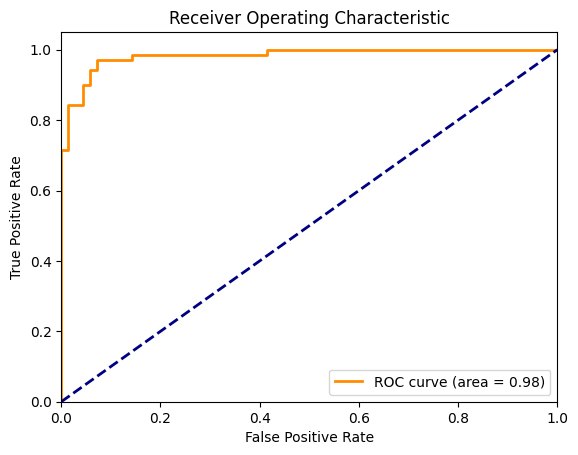

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TELM Class
class TwinExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights1 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases1 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.input_weights2 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases2 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.output_weights1 = None
        self.output_weights2 = None

    def _activation(self, x):
        if self.activation_function == 'multiquard':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'sigmoid':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'multiquard' or 'sigmoid'.")

    def fit(self, X, y):
        # Calculate the hidden layer outputs for both twin networks
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Compute the output weights for both networks
        self.output_weights1 = np.dot(np.linalg.pinv(H1), y)
        self.output_weights2 = np.dot(np.linalg.pinv(H2), y)

    def predict(self, X):
        # Calculate the hidden layer outputs for predictions
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Combine the outputs of both networks
        predictions1 = np.dot(H1, self.output_weights1)
        predictions2 = np.dot(H2, self.output_weights2)

        # Average the predictions
        return (predictions1 + predictions2) / 2


# Assuming `X` (features) and `y` (labels) are already defined
# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize TELM
hidden_neurons = 100  # Adjust based on the dataset
telm = TwinExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train TELM
telm.fit(X_train, y_train)

# Predict on the test set
y_pred = telm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary

# Evaluate TELM
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"TELM Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Unhealthy'])
print("\nClassification Report:\n")
print(report)
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Use raw predictions (not binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TELM Class
class TwinExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights1 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases1 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.input_weights2 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases2 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.output_weights1 = None
        self.output_weights2 = None

    def _activation(self, x):
        """Applies the specified activation function."""
        if self.activation_function == 'multiquard':  # Multiquadratic function
            return np.sqrt(1 + x ** 2)
        elif self.activation_function == 'sigmoid':  # Sigmoid function
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unsupported activation function. Use 'multiquard' or 'sigmoid'.")

    def fit(self, X, y):
        """Trains the TELM model."""
        # Calculate the hidden layer outputs for both twin networks
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Compute the output weights for both networks using pseudo-inverse
        self.output_weights1 = np.dot(np.linalg.pinv(H1), y)
        self.output_weights2 = np.dot(np.linalg.pinv(H2), y)

    def predict(self, X):
        """Predicts labels for the input data."""
        # Calculate the hidden layer outputs for predictions
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Combine the outputs of both networks
        predictions1 = np.dot(H1, self.output_weights1)
        predictions2 = np.dot(H2, self.output_weights2)

        # Average the predictions
        return (predictions1 + predictions2) / 2

# Load the dataset
data = pd.read_csv('shuffled_combined_features.csv')  # Replace with your dataset's filename

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Replace 'Label' with your target column
y = data['Label']  # Replace 'Label' with your target column
for a in range(100):
  # Split the dataset into training and testing sets with an 80:20 ratio
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=a)

  # Standardize the data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Initialize TELM
  hidden_neurons = 100  # Adjust based on the dataset
  telm = TwinExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

  # Train TELM
  telm.fit(X_train, y_train)

  # Predict on the test set
  y_pred = telm.predict(X_test)
  y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary

  # Evaluate TELM
  print(a)
  accuracy = accuracy_score(y_test, y_pred_binary)
  print(f"TELM Accuracy: {accuracy * 100:.2f}%")

  # Classification Report
  report = classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Unhealthy'])
  print("\nClassification Report:\n")
  print(report)


0
TELM Accuracy: 84.29%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.87      0.85      0.86        79
   Unhealthy       0.81      0.84      0.82        61

    accuracy                           0.84       140
   macro avg       0.84      0.84      0.84       140
weighted avg       0.84      0.84      0.84       140

1
TELM Accuracy: 91.43%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.90      0.93      0.92        71
   Unhealthy       0.93      0.90      0.91        69

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140

2
TELM Accuracy: 90.71%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.89      0.95      0.92        74
   Unhealthy       0.93      0.86      0.90        66

    accuracy                       

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TELM Class
class TwinExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights1 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases1 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.input_weights2 = np.random.uniform(-0.5, 0.5, (self.input_size, self.hidden_neurons))
        self.biases2 = np.random.uniform(-0.5, 0.5, (self.hidden_neurons,))
        self.output_weights1 = None
        self.output_weights2 = None

    def _activation(self, x):
        """Applies the specified activation function."""
        if self.activation_function == 'multiquard':  # Multiquadratic function
            return np.sqrt(1 + x ** 2)
        elif self.activation_function == 'sigmoid':  # Sigmoid function
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unsupported activation function. Use 'multiquard' or 'sigmoid'.")

    def fit(self, X, y):
        """Trains the TELM model."""
        # Calculate the hidden layer outputs for both twin networks
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Compute the output weights for both networks using pseudo-inverse
        self.output_weights1 = np.dot(np.linalg.pinv(H1), y)
        self.output_weights2 = np.dot(np.linalg.pinv(H2), y)

    def predict(self, X):
        """Predicts labels for the input data."""
        # Calculate the hidden layer outputs for predictions
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Combine the outputs of both networks
        predictions1 = np.dot(H1, self.output_weights1)
        predictions2 = np.dot(H2, self.output_weights2)

        # Average the predictions
        return (predictions1 + predictions2) / 2

# Load the dataset
data = pd.read_csv('shuffled_combined_features.csv')  # Replace with your dataset's filename

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Replace 'Label' with your target column
y = data['Label']  # Replace 'Label' with your target column
# for a in range(100):
  # Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=a)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize TELM
hidden_neurons = 100  # Adjust based on the dataset
telm = TwinExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train TELM
telm.fit(X_train, y_train)

# Predict on the test set
y_pred = telm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary

# Evaluate TELM
print(a)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"TELM Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Unhealthy'])
print("\nClassification Report:\n")
print(report)


99
TELM Accuracy: 90.00%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.91      0.91      0.91        74
   Unhealthy       0.89      0.89      0.89        66

    accuracy                           0.90       140
   macro avg       0.90      0.90      0.90       140
weighted avg       0.90      0.90      0.90       140



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TELM Class
class TwinExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights1 = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases1 = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.input_weights2 = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases2 = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights1 = None
        self.output_weights2 = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        # Calculate the hidden layer outputs for both twin networks
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Compute the output weights for both networks
        self.output_weights1 = np.dot(np.linalg.pinv(H1), y)
        self.output_weights2 = np.dot(np.linalg.pinv(H2), y)

    def predict(self, X):
        # Calculate the hidden layer outputs for predictions
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Combine the outputs of both networks
        predictions1 = np.dot(H1, self.output_weights1)
        predictions2 = np.dot(H2, self.output_weights2)

        # Average the predictions
        return (predictions1 + predictions2) / 2

# Data Preparation (Example with existing dataset)
# Assuming `X_train`, `X_test`, `y_train`, `y_test` are already prepared

# Initialize TELM
hidden_neurons = 100  # Adjust based on the dataset
telm = TwinExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train TELM
telm.fit(X_train, y_train)

# Predict on the test set
y_pred = telm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary

# Evaluate TELM
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"TELM Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Unhealthy'])
print("\nClassification Report:\n")
print(report)


TELM Accuracy: 89.29%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.93      0.86      0.90        74
   Unhealthy       0.86      0.92      0.89        66

    accuracy                           0.89       140
   macro avg       0.89      0.89      0.89       140
weighted avg       0.90      0.89      0.89       140



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TELM Class
class TwinExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights1 = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases1 = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.input_weights2 = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases2 = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights1 = None
        self.output_weights2 = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        # Calculate the hidden layer outputs for both twin networks
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Compute the output weights for both networks
        self.output_weights1 = np.dot(np.linalg.pinv(H1), y)
        self.output_weights2 = np.dot(np.linalg.pinv(H2), y)

    def predict(self, X):
        # Calculate the hidden layer outputs for predictions
        H1 = self._activation(np.dot(X, self.input_weights1) + self.biases1)
        H2 = self._activation(np.dot(X, self.input_weights2) + self.biases2)

        # Combine the outputs of both networks
        predictions1 = np.dot(H1, self.output_weights1)
        predictions2 = np.dot(H2, self.output_weights2)

        # Average the predictions
        return (predictions1 + predictions2) / 2

# Data Preparation (Example with existing dataset)
# Assuming `X_train`, `X_test`, `y_train`, `y_test` are already prepared

# Initialize TELM
hidden_neurons = 100  # Adjust based on the dataset
telm = TwinExtremeLearningMachine(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train TELM
telm.fit(X_train, y_train)

# Predict on the test set
y_pred = telm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert predictions to binary

# Evaluate TELM
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"TELM Accuracy: {accuracy * 100:.2f}%")

# Classification Report
report = classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Unhealthy'])
print("\nClassification Report:\n")
print(report)


TELM Accuracy: 90.71%

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.92      0.91      0.91        74
   Unhealthy       0.90      0.91      0.90        66

    accuracy                           0.91       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.91      0.91      0.91       140



Decision Tree

Decision Tree Accuracy: 87.86%


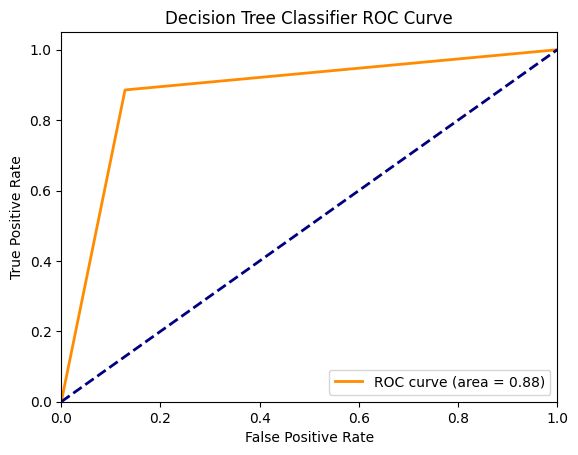

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load datasets
# healthy_df = pd.read_csv('hfeature_vectors.csv')
# unhealthy_df = pd.read_csv('feature_vectors.csv')

# # Add labels
# healthy_df['Label'] = 0  # Label for healthy
# unhealthy_df['Label'] = 1  # Label for unhealthy

# # Combine datasets
# data = pd.concat([healthy_df, unhealthy_df], ignore_index=True)

# # Shuffle the data
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = pd.read_csv('shuffled_combined_features.csv')  # Replace with your dataset's filename

# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features (optional for decision trees, but added for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier
decision_tree.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = decision_tree.predict_proba(X_test)[:, 1]  # Probability for class 1

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Decision Tree Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()


RVFL

RVFL Accuracy: 64.29%


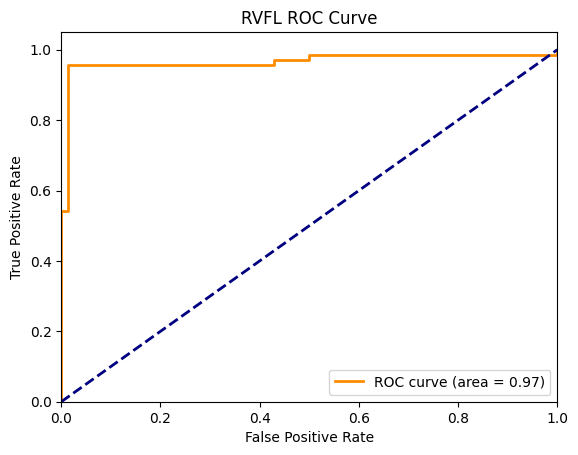

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# # Load datasets
# healthy_df = pd.read_csv('hfeature_vectors.csv')
# unhealthy_df = pd.read_csv('feature_vectors.csv')

# # Add labels
# healthy_df['Label'] = 0  # Label for healthy
# unhealthy_df['Label'] = 1  # Label for unhealthy

# # Combine datasets
# data = pd.concat([healthy_df, unhealthy_df], ignore_index=True)

# # Shuffle the data
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data = pd.read_csv('shuffled_combined_features.csv')  # Replace with your dataset's filename

# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# RVFL class
class RVFL:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid', include_bias=True):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,)) if include_bias else None
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        # Compute hidden layer output (H)
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        # Concatenate input features directly to hidden layer outputs (RVFL structure)
        H = np.hstack((X, H))
        # Compute output weights (β) using Moore-Penrose pseudoinverse
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        # Compute hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        # Concatenate input features to hidden layer outputs
        H = np.hstack((X, H))
        # Compute predictions
        return np.dot(H, self.output_weights)

# Initialize RVFL
hidden_neurons = 100  # You can adjust the number of hidden neurons
rvfl = RVFL(input_size=X_train.shape[1], hidden_neurons=hidden_neurons)

# Train RVFL
rvfl.fit(X_train, y_train)

# Predict on the test set
y_pred = rvfl.predict(X_test)
y_pred_prob = 1 / (1 + np.exp(-y_pred))  # Apply sigmoid to get probabilities
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"RVFL Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RVFL ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Define dimensions
num_subjects = 14
num_channels = 19
# Changed num_epochs to match the shape of unhealthy_data
num_epochs = healthy_data.shape[2]  # Get the actual number of epochs from the data
samples_per_epoch = 500

# Create random healthy data
# healthy_data _epoch)

# Define channel labels
signal_labels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

# Initialize a list to store rows of tabular data
tabular_data = []

# Iterate through each subject, channel, and epoch to flatten the data
for subject in range(num_subjects):
    for channel in range(num_channels):
        for epoch in range(num_epochs):  # Now iterates correctly
            # Extract the signal for the current subject, channel, and epoch
            signal = healthy_data[subject, channel, epoch, :]

            # Create a row with metadata and the signal values
            row = {
                'Subject_ID': subject + 1,
                'Channel': signal_labels[channel],
                'Epoch': epoch + 1,
                'Signal_Values': list(signal)  # Convert numpy array to a list for better readability
            }

            # Append the row to the list
            tabular_data.append(row)

# Create a DataFrame from the list of rows
df_healthy = pd.DataFrame(tabular_data)

# Display the first few rows of the DataFrame
print(df_healthy.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df_healthy.to_csv('more_healthy_data_tabular.csv', index=False)

# Optionally, display the DataFrame in a tabular format in Google Colab
display(df_healthy)


   Subject_ID Channel  Epoch  \
0           1     Fp1      1   
1           1     Fp1      2   
2           1     Fp1      3   
3           1     Fp1      4   
4           1     Fp1      5   

                                       Signal_Values  
0  [1.2257410657054588, 1.9902667317719283, 3.672...  
1  [8.870997726370152, 9.788428525649916, 11.1645...  
2  [38.68749870296246, 36.39392170476305, 34.4061...  
3  [5.354179662464394, -0.45621539964077396, -4.5...  
4  [8.71809259315686, 6.730325861384038, 3.060602...  


Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  
0      [1.2257410657054588, 1.9902667317719283, 3.672...  
1      [8.870997726370152, 9.788428525649916, 11.1645...  
2      [38.68749870296246, 36.39392170476305, 34.4061...  
3      [5.354179662464394, -0.45621539964077396, -4.5...  
4      [8.71809259315686, 6.730325861384038, 3.060602...  
...                                                  ...  
13295  [12.082005523849324, 8.259377193516977, 8.1064...  
13296  [-12.229910657064403, -8.713092593158644, -6.2...  
13297  [2.44898213141181, 0.3083102664256955, 0.76702...  
13298  [-0.45621539964077396, -3.3614129306933576, -1...  
13299  [-0.9149307992806556, -2.1381718649870067, -0....  

[13300 rows x 4 columns]

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Define dimensions
num_subjects = 14
num_channels = 19
# Changed num_epochs to match the shape of unhealthy_data
num_epochs = unhealthy_data.shape[2]  # Get the actual number of epochs from the data
samples_per_epoch = 500

# Create random healthy data
# healthy_data _epoch)

# Define channel labels
signal_labels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

# Initialize a list to store rows of tabular data
tabular_data = []

# Iterate through each subject, channel, and epoch to flatten the data
for subject in range(num_subjects):
    for channel in range(num_channels):
        for epoch in range(num_epochs):  # Now iterates correctly
            # Extract the signal for the current subject, channel, and epoch
            signal = unhealthy_data[subject, channel, epoch, :]

            # Create a row with metadata and the signal values
            row = {
                'Subject_ID': subject + 1,
                'Channel': signal_labels[channel],
                'Epoch': epoch + 1,
                'Signal_Values': list(signal)  # Convert numpy array to a list for better readability
            }

            # Append the row to the list
            tabular_data.append(row)

# Create a DataFrame from the list of rows
df_healthy = pd.DataFrame(tabular_data)

# Display the first few rows of the DataFrame
print(df_healthy.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df_healthy.to_csv('more_unhealthy_data_tabular.csv', index=False)

# Optionally, display the DataFrame in a tabular format in Google Colab
display(df_healthy)

   Subject_ID Channel  Epoch  \
0           1     Fp1      1   
1           1     Fp1      2   
2           1     Fp1      3   
3           1     Fp1      4   
4           1     Fp1      5   

                                       Signal_Values  
0  [5.2012745292511, 3.2135077974782793, 0.614120...  
1  [6.883230994597333, 6.271610461744157, 4.74255...  
2  [0.0024999999991076978, -0.1504051332141862, 1...  
3  [9.176807992796741, 8.565187459943566, 7.80066...  
4  [-5.9608001953193535, -6.725325861385823, -4.8...  


Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  
0      [5.2012745292511, 3.2135077974782793, 0.614120...  
1      [6.883230994597333, 6.271610461744157, 4.74255...  
2      [0.0024999999991076978, -0.1504051332141862, 1...  
3      [9.176807992796741, 8.565187459943566, 7.80066...  
4      [-5.9608001953193535, -6.725325861385823, -4.8...  
...                                                  ...  
13295  [4.112990966520863, 17.35091842402384, 11.0897...  
13296  [11.984191076387496, 11.805300164799618, -5.01...  
13297  [4.8285546128723755, 24.327663975951083, 24.14...  
13298  [11.984191076387496, 18.96093662831474, 2.1451...  
13299  [15.919791131320814, 7.3330273751026676, -8.05...  

[13300 rows x 4 columns]

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import entropy as shannon_entropy
import antropy as ant

# Function to calculate Shannon Entropy
def calculate_shannon_entropy(signal):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = [count / total_count for count in counter.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# Function to calculate Approximate Entropy
def calculate_approximate_entropy(signal, m=2, r=0.2):
    return ant.app_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Sample Entropy
def calculate_sample_entropy(signal, m=2, r=0.2):
    return ant.sample_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Tsallis Entropy
def calculate_tsallis_entropy(signal, q=2):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = np.array([count / total_count for count in counter.values()])
    tsallis = (1 - np.sum(probabilities ** q)) / (q - 1) if q != 1 else calculate_shannon_entropy(signal)
    return tsallis

# Function to calculate Spectral Entropy
def calculate_spectral_entropy(signal, sampling_frequency=1):
    return ant.spectral_entropy(signal, sf=sampling_frequency, method="welch", normalize=True)

# Load CSV data
input_file = 'more_healthy_data_tabular.csv'  # Replace with your actual file
data = pd.read_csv(input_file)

# Ensure Signal_Values is parsed as a list of floats
data['Signal_Values'] = data['Signal_Values'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize new columns
data['Shannon_Entropy'] = data['Signal_Values'].apply(calculate_shannon_entropy)
data['Approximate_Entropy'] = data['Signal_Values'].apply(calculate_approximate_entropy)
data['Sample_Entropy'] = data['Signal_Values'].apply(calculate_sample_entropy)
data['Tsallis_Entropy'] = data['Signal_Values'].apply(calculate_tsallis_entropy)
data['Spectral_Entropy'] = data['Signal_Values'].apply(calculate_spectral_entropy)

# Save updated data to a new CSV
output_file = 'more_data_with_entropies.csv'
data.to_csv(output_file, index=False)

print(f"Entropy calculations complete. Results saved to {output_file}.")


/usr/local/lib/python3.11/dist-packages/antropy/entropy.py:255: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


Entropy calculations complete. Results saved to more_data_with_entropies.csv.


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import entropy as shannon_entropy
import antropy as ant

# Function to calculate Shannon Entropy
def calculate_shannon_entropy(signal):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = [count / total_count for count in counter.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# Function to calculate Approximate Entropy
def calculate_approximate_entropy(signal, m=2, r=0.2):
    return ant.app_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Sample Entropy
def calculate_sample_entropy(signal, m=2, r=0.2):
    return ant.sample_entropy(signal, order=m, metric="chebyshev")

# Function to calculate Tsallis Entropy
def calculate_tsallis_entropy(signal, q=2):
    counter = Counter(signal)  # Count occurrences of each value
    total_count = len(signal)
    probabilities = np.array([count / total_count for count in counter.values()])
    tsallis = (1 - np.sum(probabilities ** q)) / (q - 1) if q != 1 else calculate_shannon_entropy(signal)
    return tsallis

# Function to calculate Spectral Entropy
def calculate_spectral_entropy(signal, sampling_frequency=1):
    return ant.spectral_entropy(signal, sf=sampling_frequency, method="welch", normalize=True)

# Load CSV data
input_file = 'more_unhealthy_data_tabular.csv'  # Replace with your actual file
data = pd.read_csv(input_file)

# Ensure Signal_Values is parsed as a list of floats
data['Signal_Values'] = data['Signal_Values'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize new columns
data['Shannon_Entropy'] = data['Signal_Values'].apply(calculate_shannon_entropy)
data['Approximate_Entropy'] = data['Signal_Values'].apply(calculate_approximate_entropy)
data['Sample_Entropy'] = data['Signal_Values'].apply(calculate_sample_entropy)
data['Tsallis_Entropy'] = data['Signal_Values'].apply(calculate_tsallis_entropy)
data['Spectral_Entropy'] = data['Signal_Values'].apply(calculate_spectral_entropy)

# Save updated data to a new CSV
output_file = 'more_data_with_unentropies.csv'
data.to_csv(output_file, index=False)

print(f"Entropy calculations complete. Results saved to {output_file}.")


/usr/local/lib/python3.11/dist-packages/antropy/entropy.py:255: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


Entropy calculations complete. Results saved to more_data_with_unentropies.csv.


In [ ]:

input_file = 'more_data_with_entropies.csv'  # Replace with your actual file name
mhdata = pd.read_csv(input_file)
mhdata

input_file = 'more_data_with_unentropies.csv'  # Replace with your actual file name
mdata = pd.read_csv(input_file)
mdata

Subject_ID Channel  Epoch  \
0               1     Fp1      1   
1               1     Fp1      2   
2               1     Fp1      3   
3               1     Fp1      4   
4               1     Fp1      5   
...           ...     ...    ...   
13295          14      Pz     46   
13296          14      Pz     47   
13297          14      Pz     48   
13298          14      Pz     49   
13299          14      Pz     50   

                                           Signal_Values  Shannon_Entropy  \
0      [np.float64(5.2012745292511), np.float64(3.213...         7.660587   
1      [np.float64(6.883230994597333), np.float64(6.2...         6.823196   
2      [np.float64(0.0024999999991076978), np.float64...         7.811839   
3      [np.float64(9.176807992796741), np.float64(8.5...         7.223389   
4      [np.float64(-5.9608001953193535), np.float64(-...         6.980779   
...                                                  ...              ...   
13295  [np.float64(4.112990966520863), np.float64(17....         7.541736   
13296  [np.float64(11.984191076387496), np.float64(11...         7.549787   
13297  [np.float64(4.8285546128723755), np.float64(24...         7.542999   
13298  [np.float64(11.984191076387496), np.float64(18...         7.564761   
13299  [np.float64(15.919791131320814), np.float64(7....         7.440097   

       Approximate_Entropy  Sample_Entropy  Tsallis_Entropy  Spectral_Entropy  
0                 0.670178        0.600766         0.993952          0.563854  
1                 0.905834        0.940326         0.989792          0.613021  
2                 0.832883        0.801538         0.994832          0.557589  
3                 0.685214        0.667865         0.991488          0.517891  
4                 0.740837        0.740787         0.990320          0.637936  
...                    ...             ...              ...               ...  
13295             0.501981        0.471317         0.994016          0.362755  
13296             0.484438        0.455102         0.993832          0.326506  
13297             0.526729        0.495092         0.993816          0.295781  
13298             0.370852        0.339285         0.994008          0.286895  
13299             0.640498        0.671207         0.993376          0.375382  

[13300 rows x 9 columns]

In [ ]:
import pandas as pd

# Assuming your data is loaded into a DataFrame called 'df'
# Example: df = pd.read_csv('your_data.csv')

# List of entropy measures
entropy_measures = ['Shannon_Entropy', 'Approximate_Entropy', 'Sample_Entropy', 'Tsallis_Entropy', 'Spectral_Entropy']

# Initialize an empty list to store the feature vectors
feature_vectors = []
df = mdata
# Group by Subject_ID and Epoch
for (subject_id, epoch), group in df.groupby(['Subject_ID', 'Epoch']):
    # Initialize a list for the feature vector
    feature_vector = []

    # Loop through each channel (19 channels)
    for channel in group['Channel'].unique():
        # Extract the entropy measures for the current channel
        channel_data = group[group['Channel'] == channel]

        # Append the entropy measures to the feature vector
        for entropy in entropy_measures:
            feature_vector.append(channel_data[entropy].values[0])

    # Append the feature vector for the current subject and epoch
    feature_vectors.append(feature_vector)

# Convert the feature vectors into a DataFrame
feature_df = pd.DataFrame(feature_vectors, columns=[f"{channel}_{entropy}" for channel in df['Channel'].unique() for entropy in entropy_measures])

# Display the resulting feature DataFrame
print(feature_df)



     Fp1_Shannon_Entropy  Fp1_Approximate_Entropy  Fp1_Sample_Entropy  \
0               7.660587                 0.670178            0.600766   
1               6.823196                 0.905834            0.940326   
2               7.811839                 0.832883            0.801538   
3               7.223389                 0.685214            0.667865   
4               6.980779                 0.740837            0.740787   
..                   ...                      ...                 ...   
695             7.649446                 0.578968            0.577747   
696             7.567529                 0.635215            0.632649   
697             7.581093                 0.635024            0.668142   
698             7.826078                 0.755481            0.760039   
699             7.601898                 0.671883            0.671182   

     Fp1_Tsallis_Entropy  Fp1_Spectral_Entropy  Fp2_Shannon_Entropy  \
0               0.993952              0.563854      

In [ ]:
# Save the resulting feature DataFrame to a CSV file
feature_df.to_csv('more_feature_vectors.csv', index=False)


In [ ]:
import pandas as pd

# Assuming your data is loaded into a DataFrame called 'df'
# Example: df = pd.read_csv('your_data.csv')

# List of entropy measures
entropy_measures = ['Shannon_Entropy', 'Approximate_Entropy', 'Sample_Entropy', 'Tsallis_Entropy', 'Spectral_Entropy']

# Initialize an empty list to store the feature vectors
feature_vectors = []
df = mhdata
# Group by Subject_ID and Epoch
for (subject_id, epoch), group in df.groupby(['Subject_ID', 'Epoch']):
    # Initialize a list for the feature vector
    feature_vector = []

    # Loop through each channel (19 channels)
    for channel in group['Channel'].unique():
        # Extract the entropy measures for the current channel
        channel_data = group[group['Channel'] == channel]

        # Append the entropy measures to the feature vector
        for entropy in entropy_measures:
            feature_vector.append(channel_data[entropy].values[0])

    # Append the feature vector for the current subject and epoch
    feature_vectors.append(feature_vector)

# Convert the feature vectors into a DataFrame
feature_df = pd.DataFrame(feature_vectors, columns=[f"{channel}_{entropy}" for channel in df['Channel'].unique() for entropy in entropy_measures])

# Display the resulting feature DataFrame
print(feature_df)



     Fp1_Shannon_Entropy  Fp1_Approximate_Entropy  Fp1_Sample_Entropy  \
0               7.749999                 0.585656            0.535486   
1               7.469917                 0.806886            0.841969   
2               7.200896                 0.836598            0.866772   
3               7.861710                 0.712954            0.720416   
4               7.796038                 0.703083            0.700550   
..                   ...                      ...                 ...   
695             7.918858                 0.578771            0.497028   
696             7.529996                 0.995571            1.041486   
697             7.483679                 0.892854            0.888784   
698             7.629117                 1.003051            1.055486   
699             7.683555                 1.061297            1.099989   

     Fp1_Tsallis_Entropy  Fp1_Spectral_Entropy  Fp2_Shannon_Entropy  \
0               0.994440              0.511985      

In [ ]:
# Save the resulting feature DataFrame to a CSV file
feature_df.to_csv('more_hfeature_vectors.csv', index=False)


In [ ]:
import pandas as pd

# Load the CSV files
feature_df = pd.read_csv('more_feature_vectors.csv')
hfeature_df = pd.read_csv('more_hfeature_vectors.csv')

# Add a Label column
feature_df['Label'] = 1
hfeature_df['Label'] = 0

# Concatenate the DataFrames
combined_df = pd.concat([feature_df, hfeature_df], ignore_index=True)

# Shuffle the combined DataFrame
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled DataFrame to a new CSV file
shuffled_df.to_csv('shuffled_combined_features.csv', index=False)

# Print a success message
print("Files combined, shuffled, and saved as 'shuffled_combined_features.csv'.")

Files combined, shuffled, and saved as 'shuffled_combined_features.csv'.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the shuffled dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features (X) and labels (y)
X = data.drop(columns=['Label'])  # Drop the label column to get features
y = data['Label']  # The label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(report)


Accuracy: 0.90

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       140
           1       0.91      0.89      0.90       140

    accuracy                           0.90       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.90      0.90      0.90       280



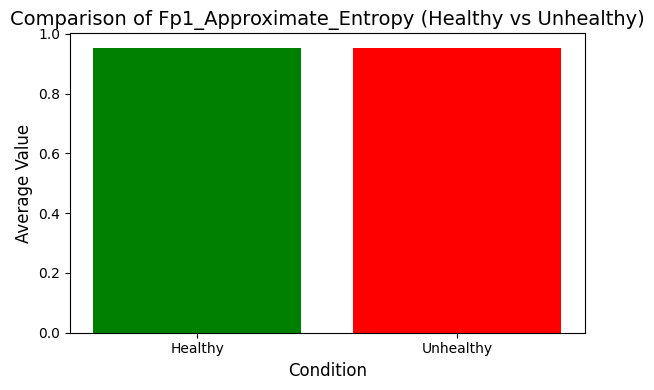

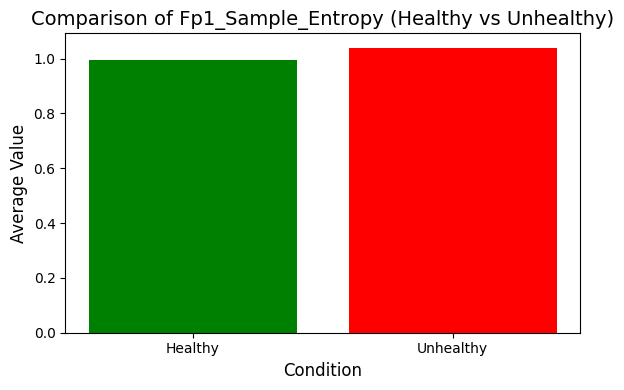

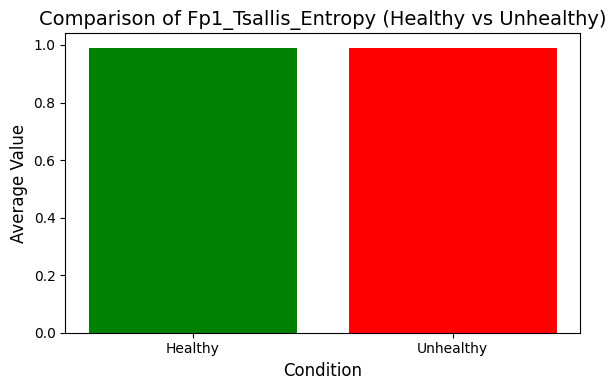

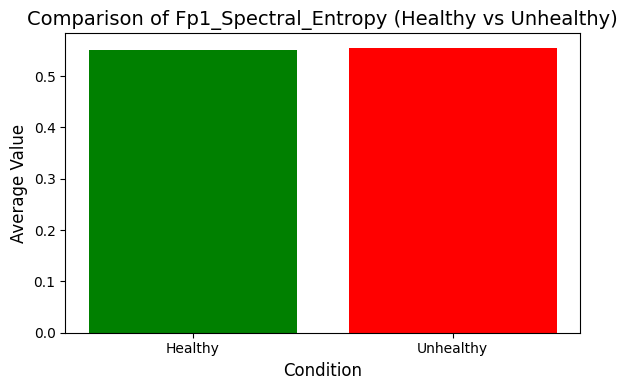

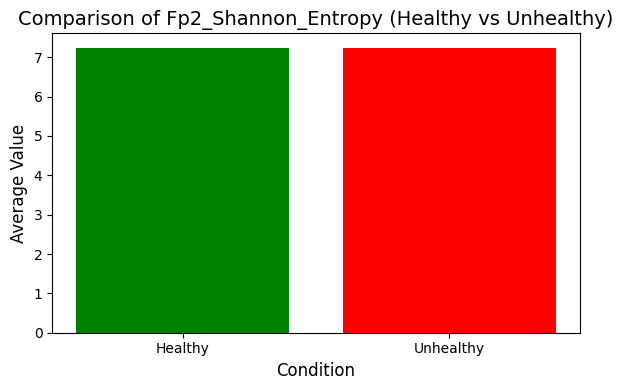

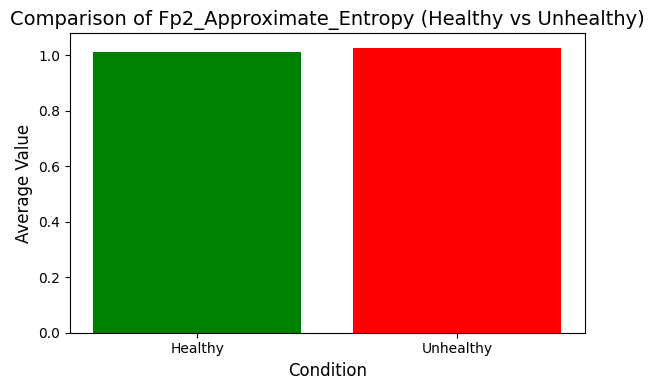

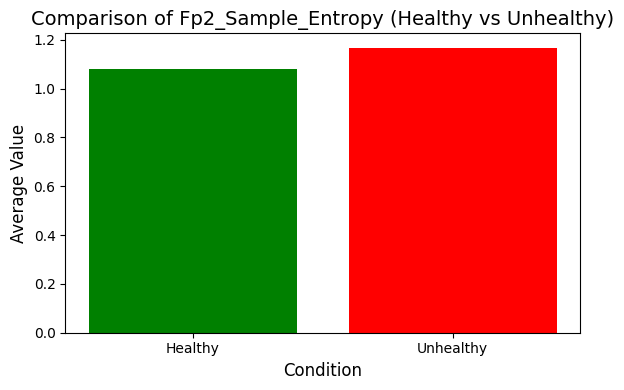

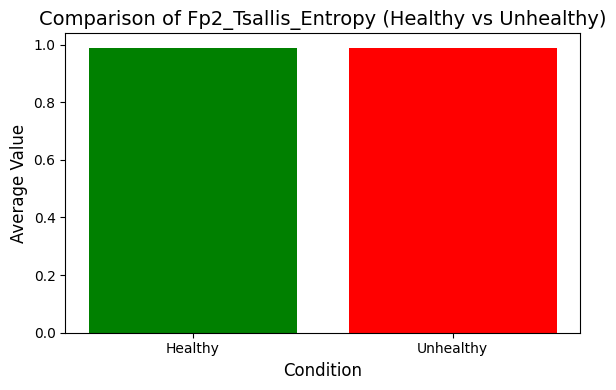

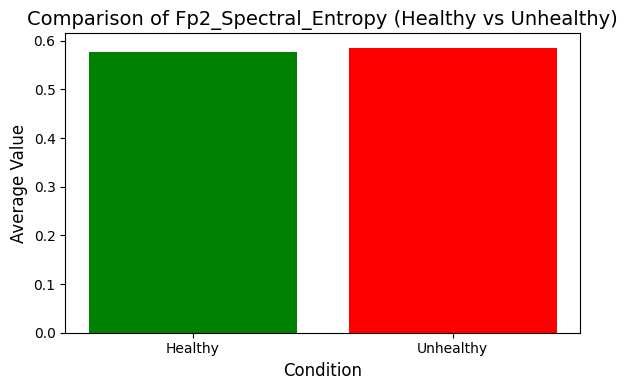

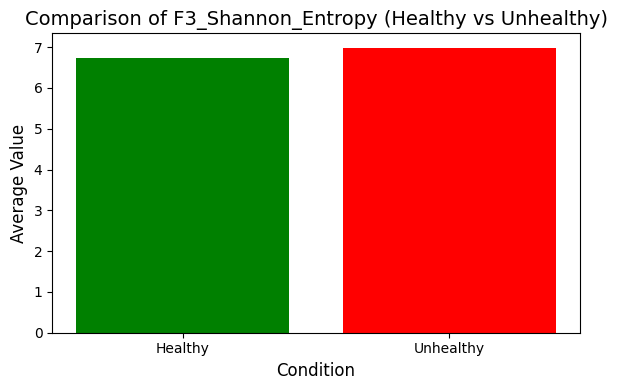

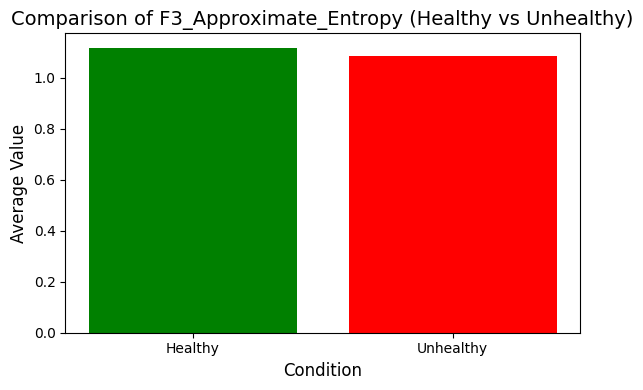

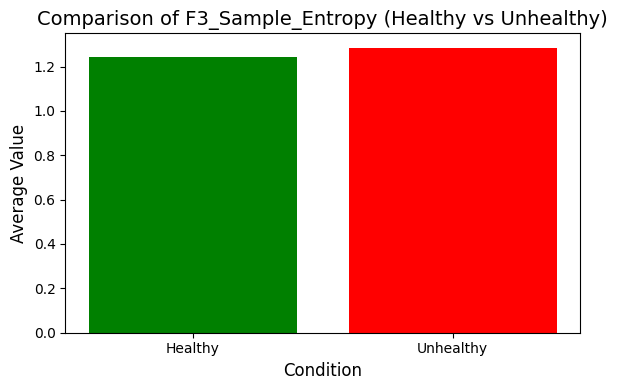

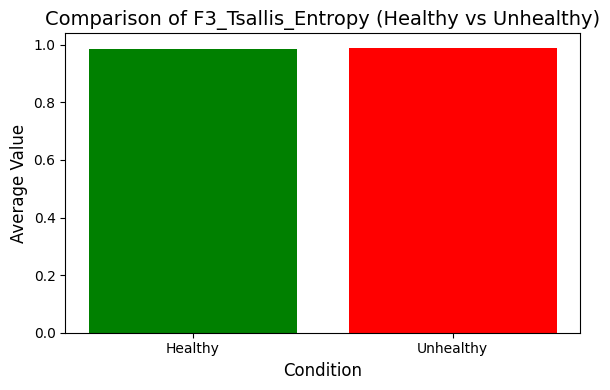

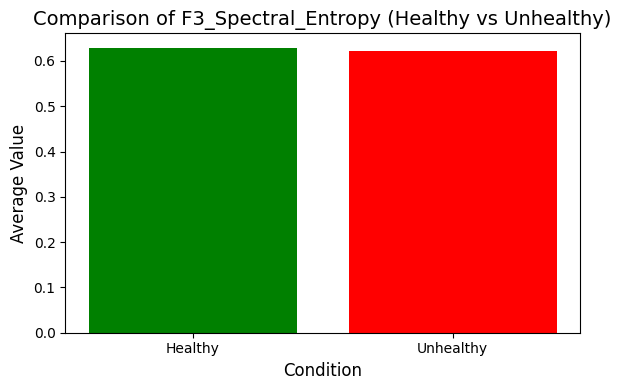

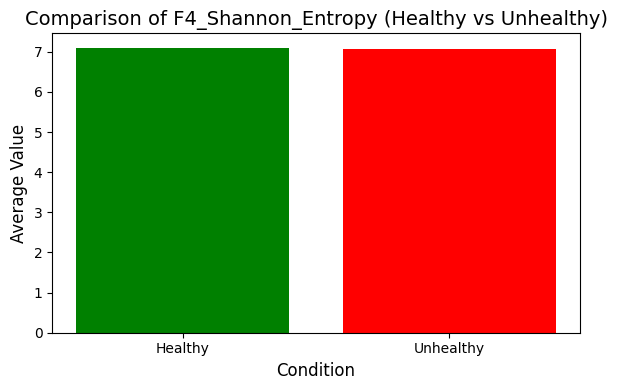

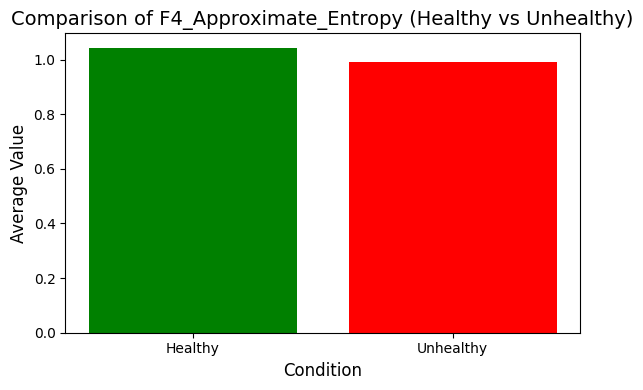

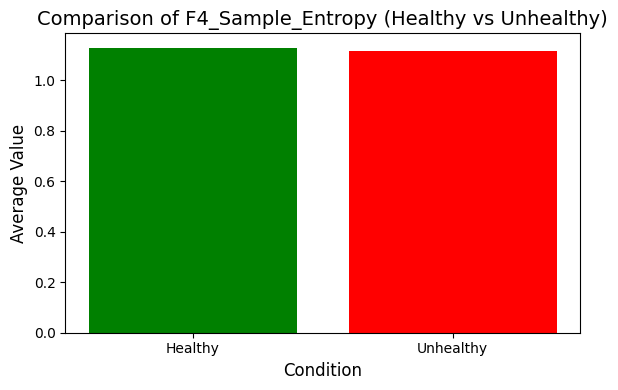

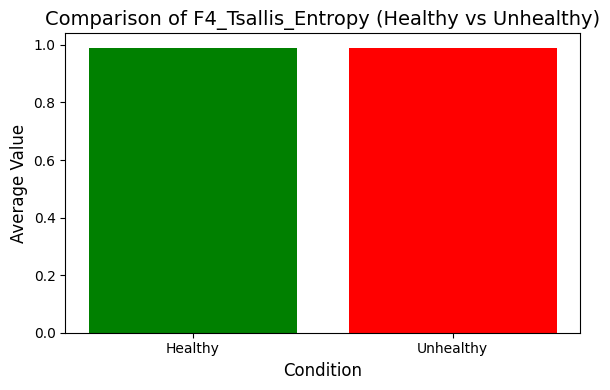

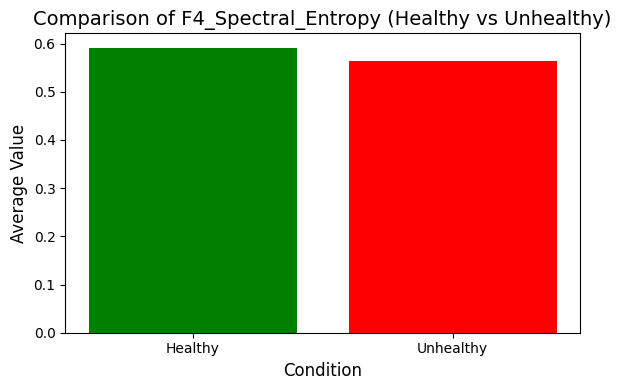

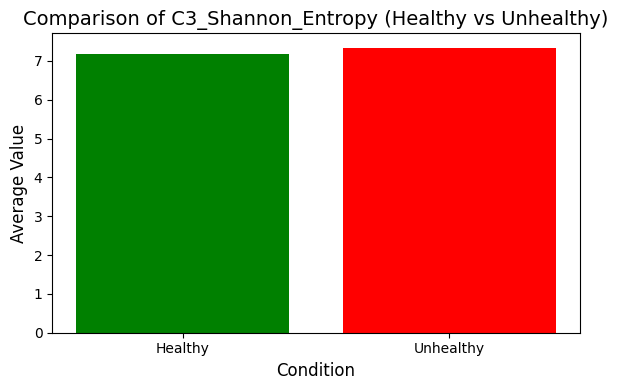

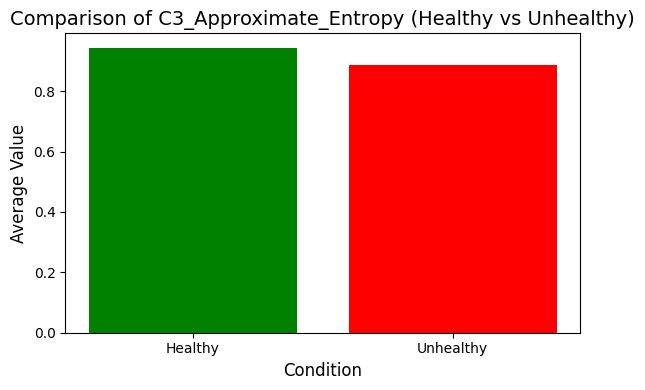

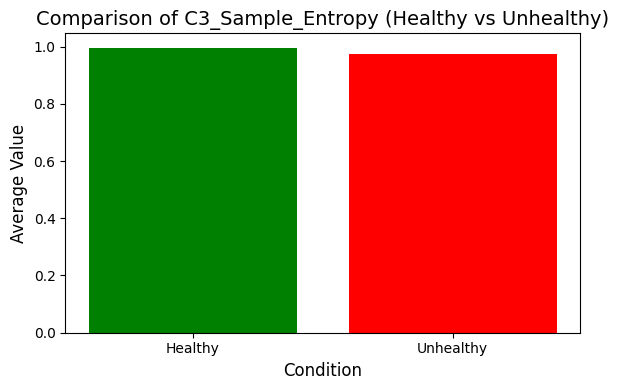

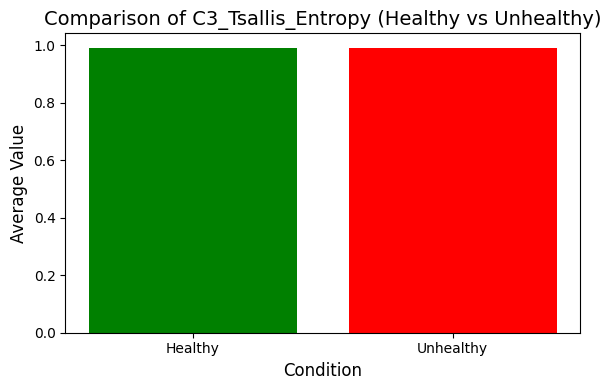

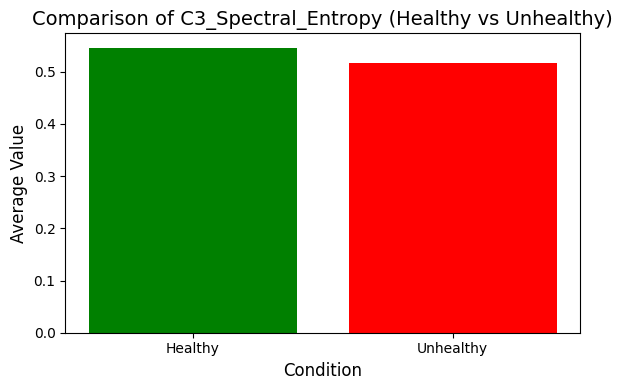

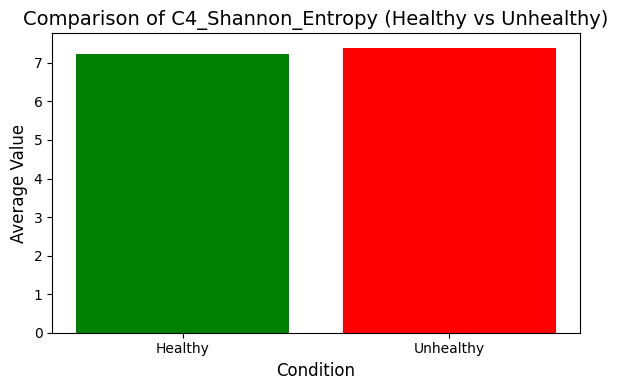

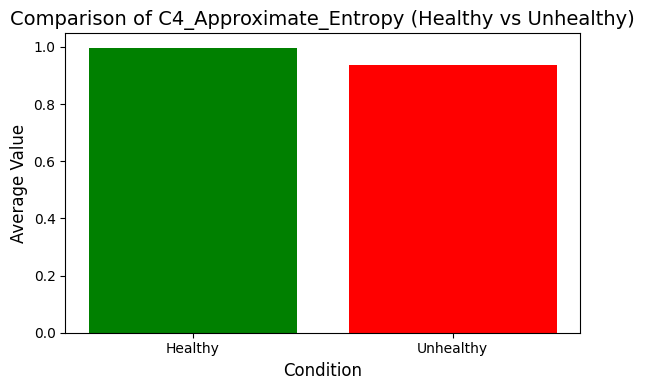

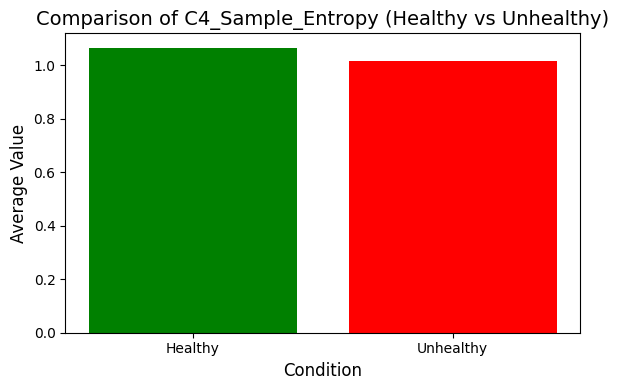

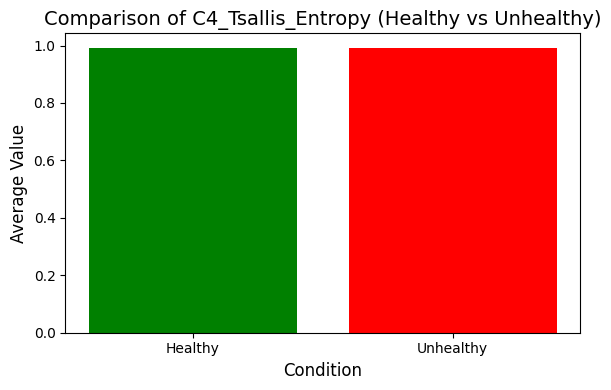

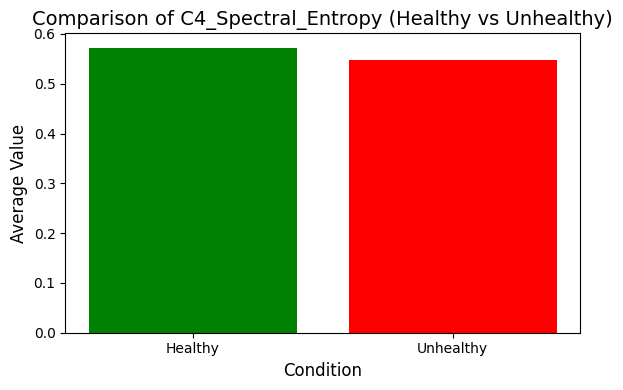

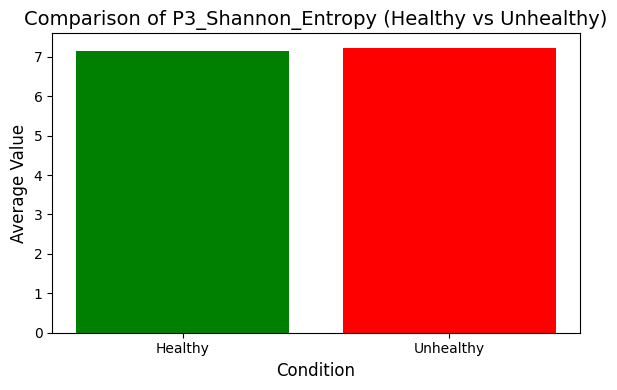

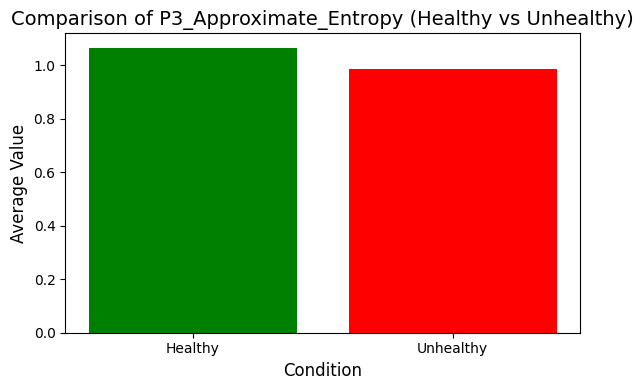

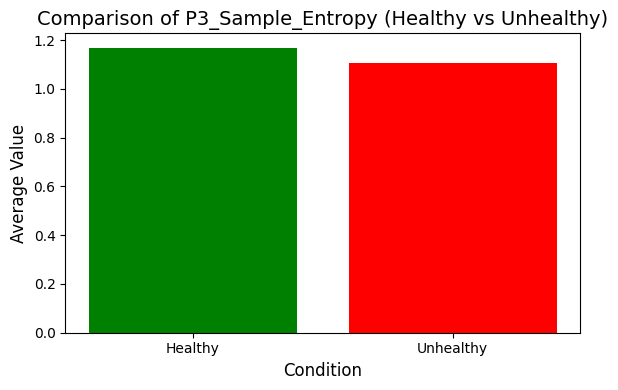

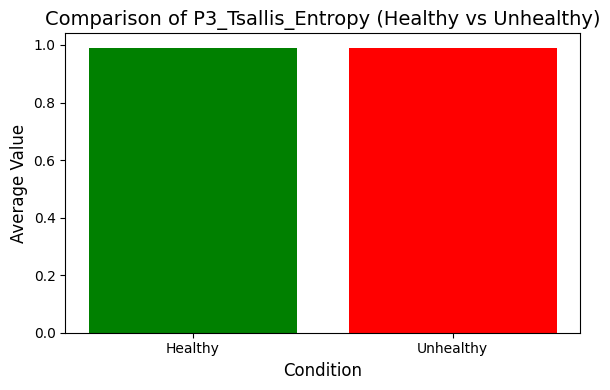

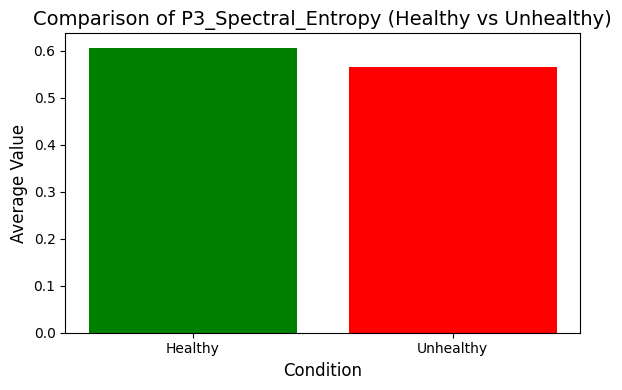

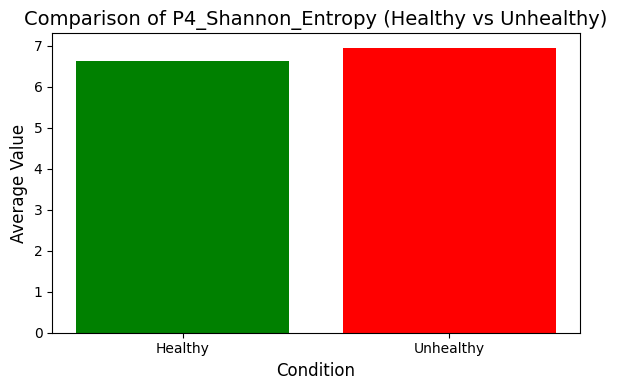

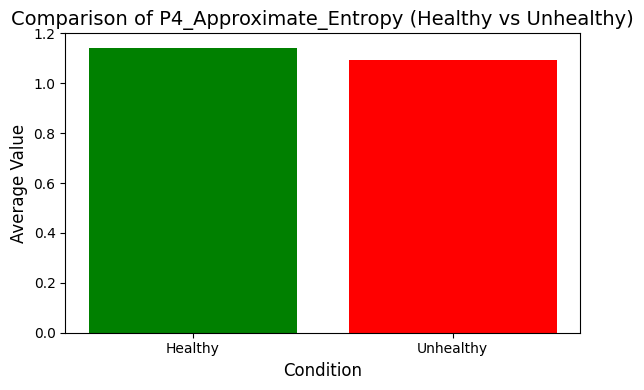

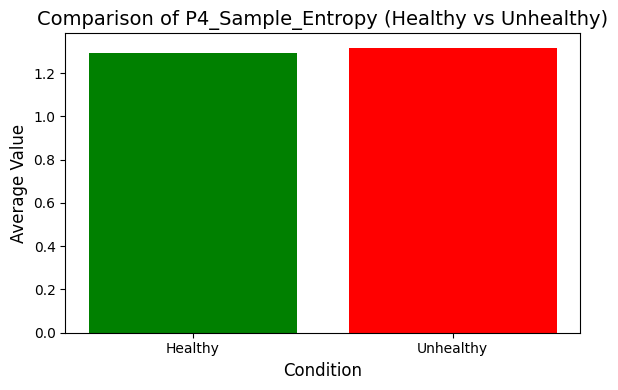

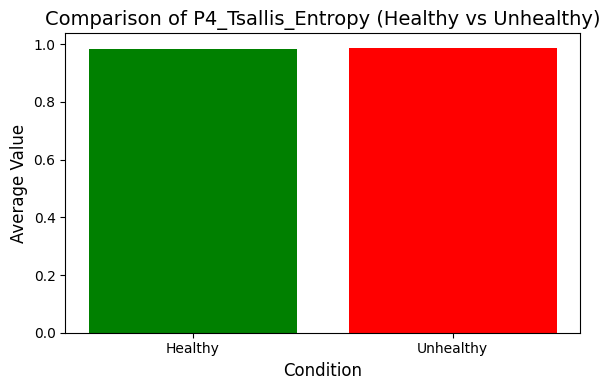

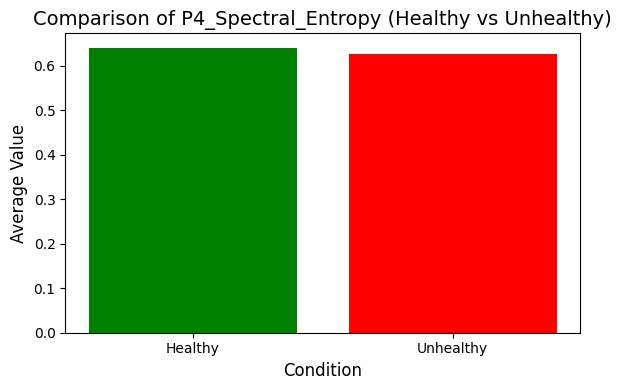

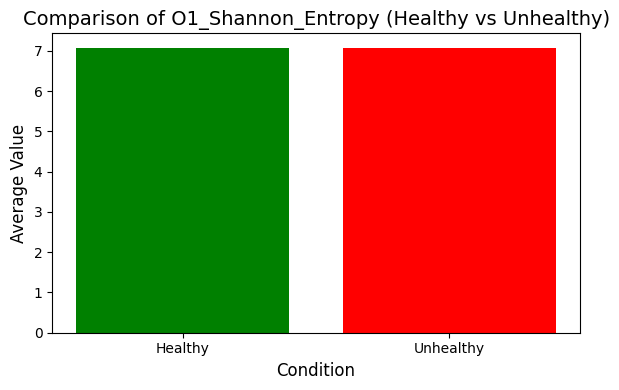

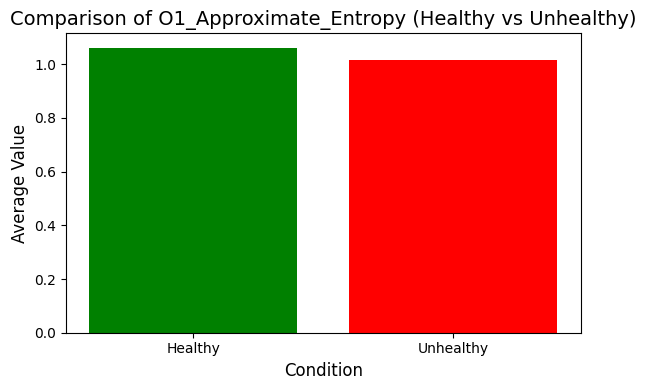

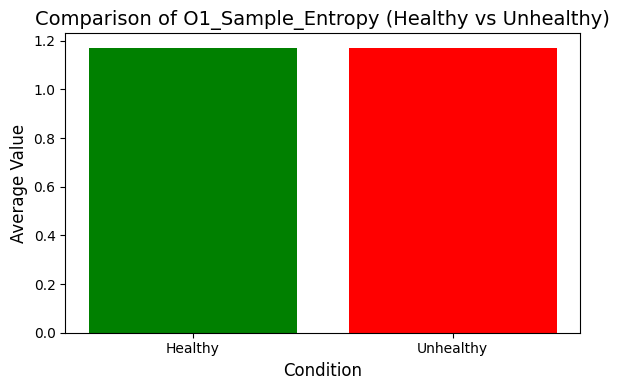

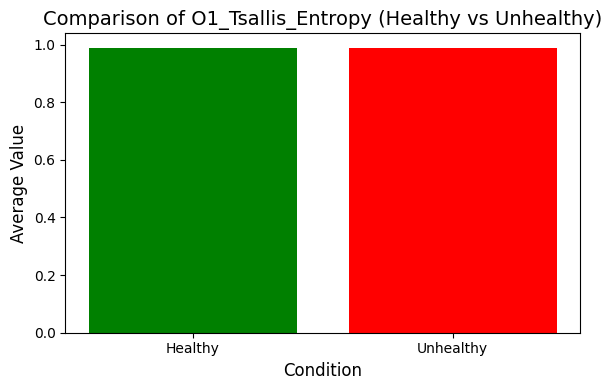

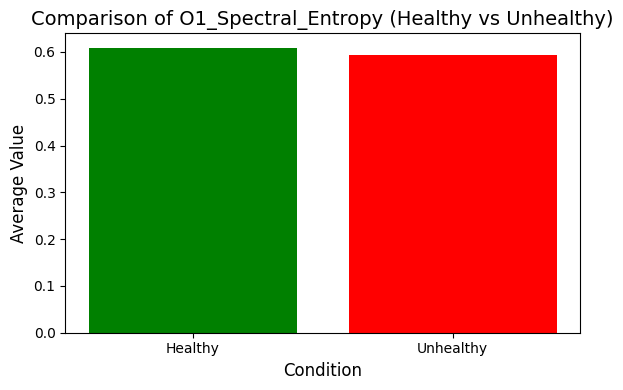

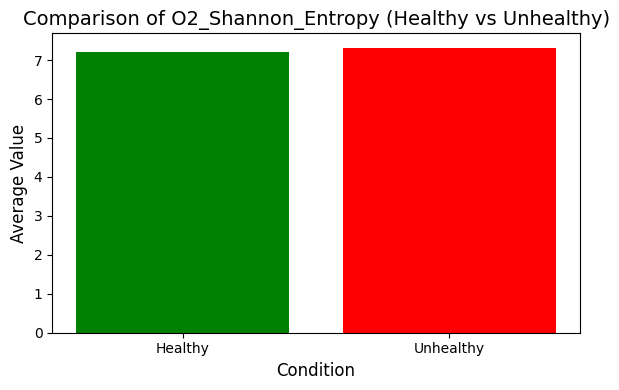

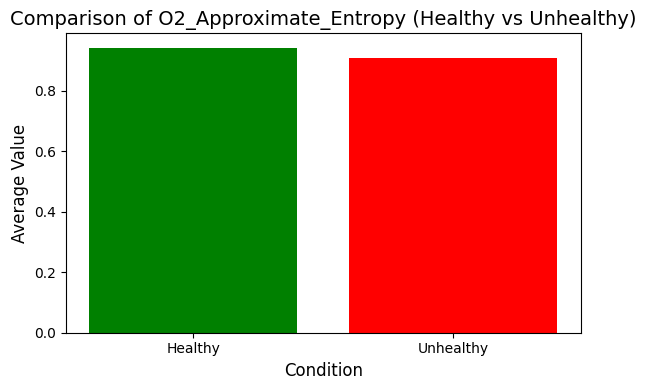

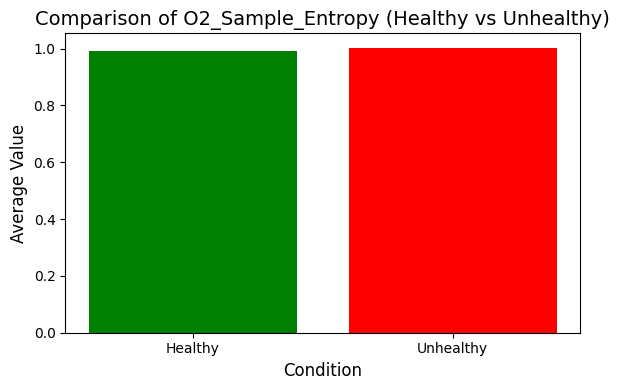

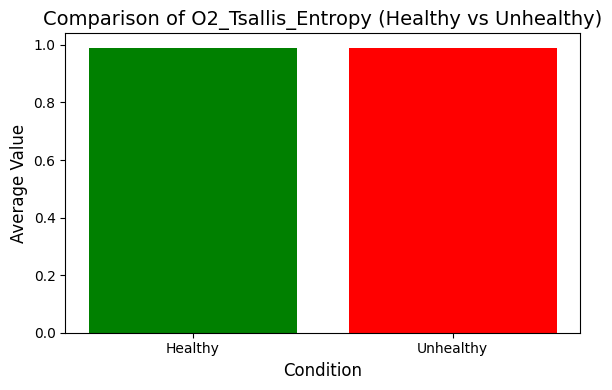

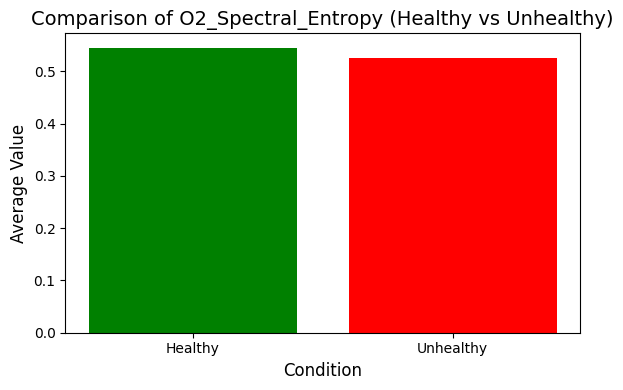

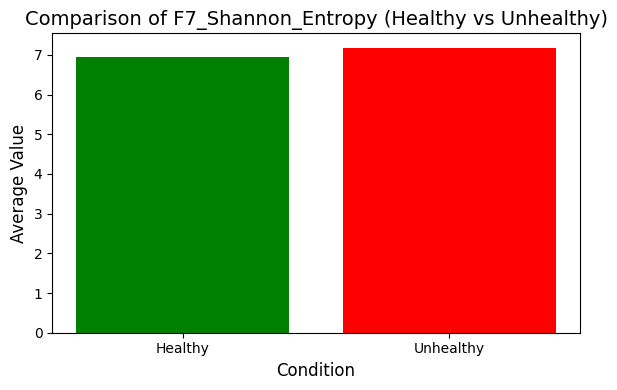

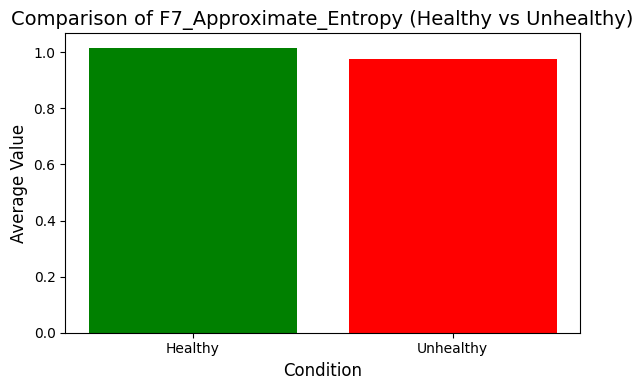

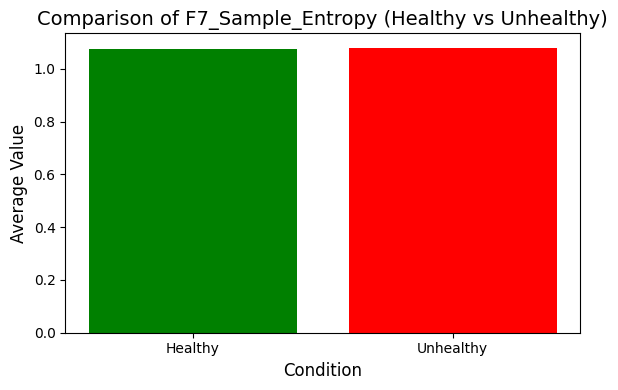

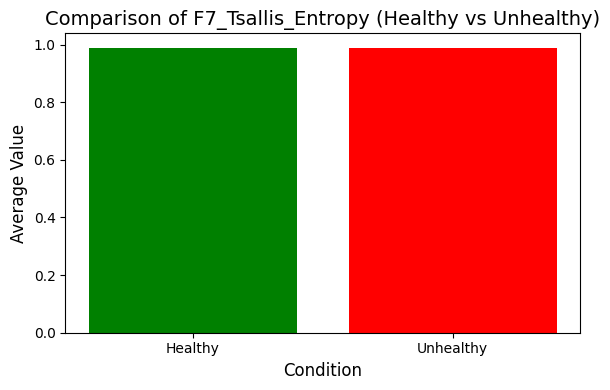

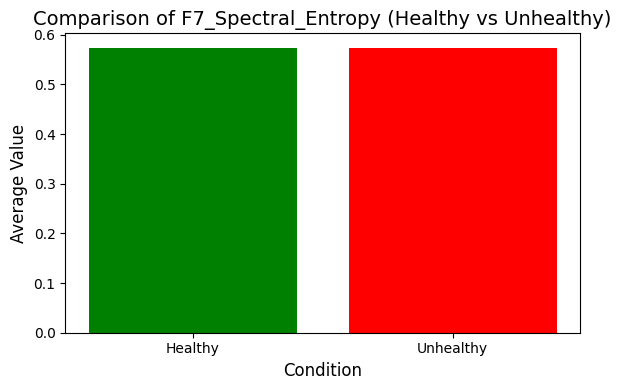

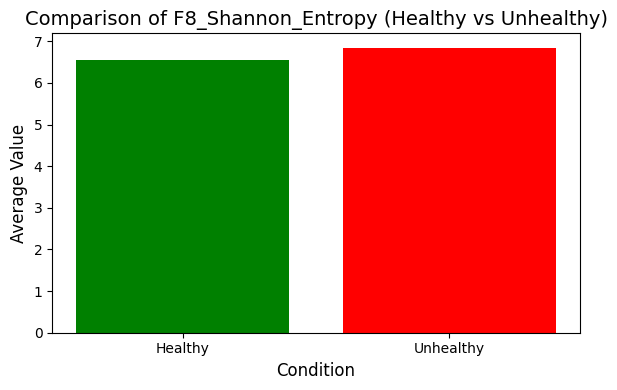

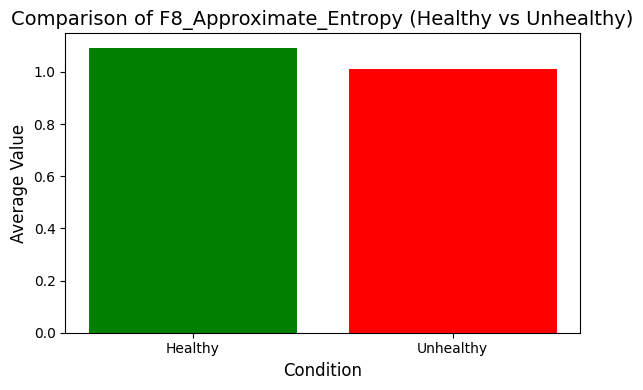

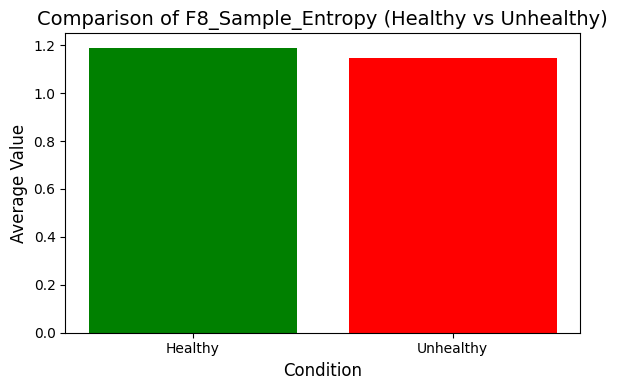

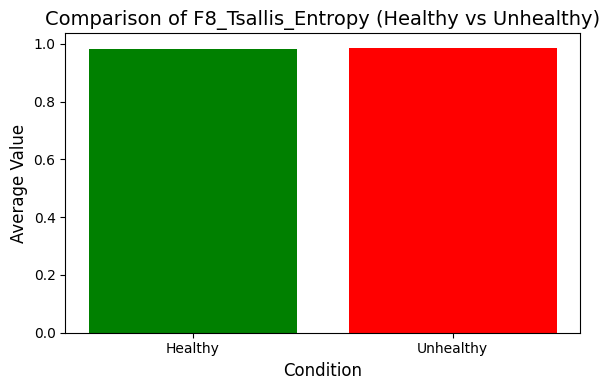

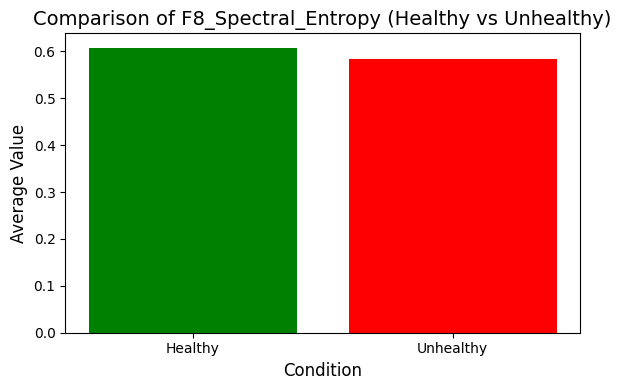

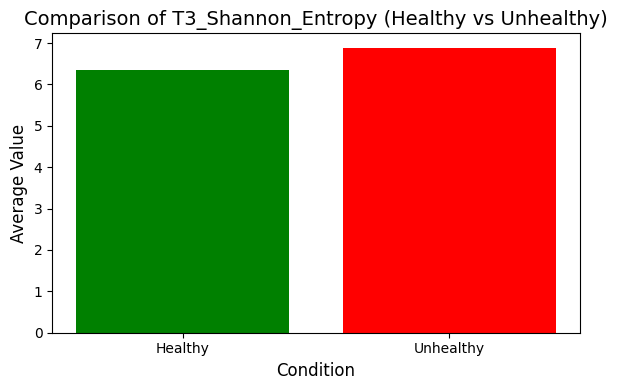

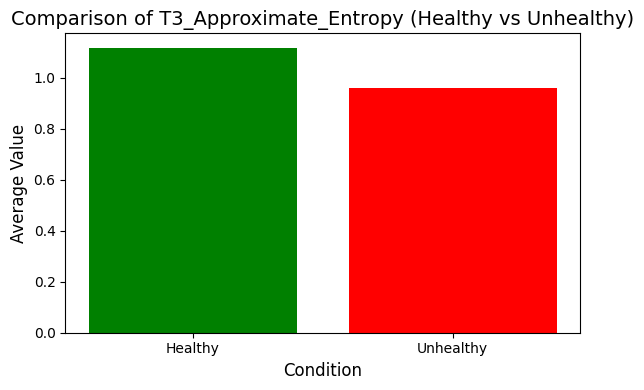

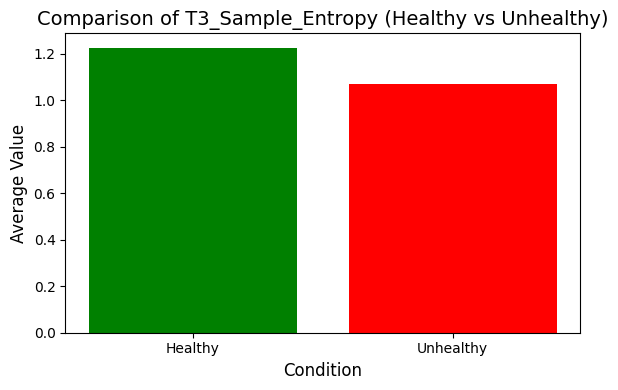

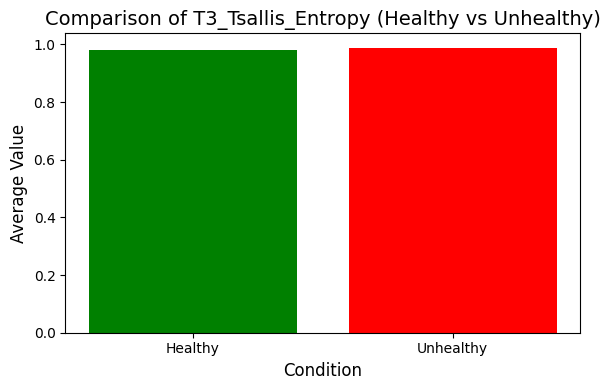

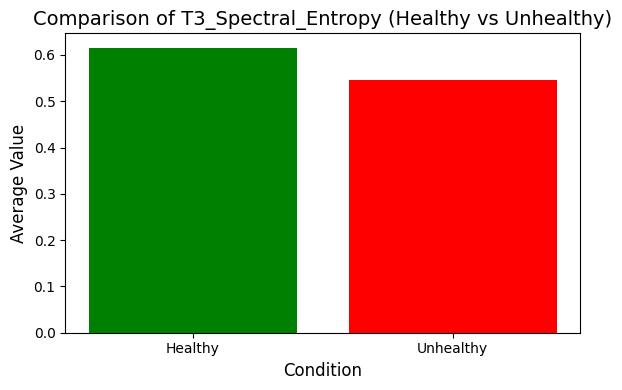

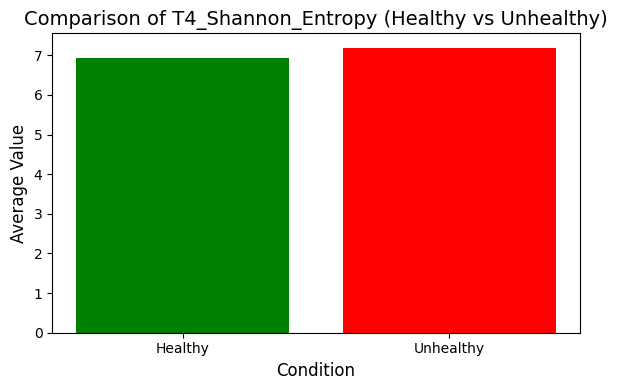

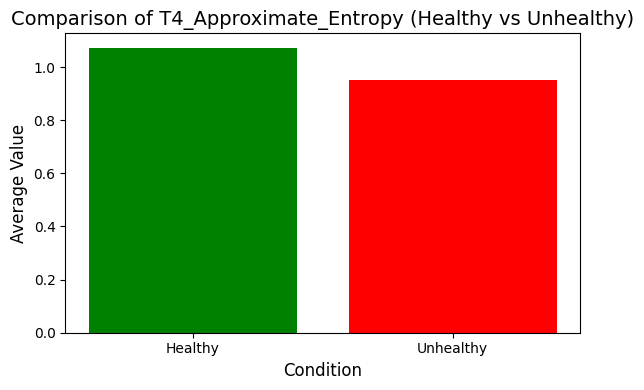

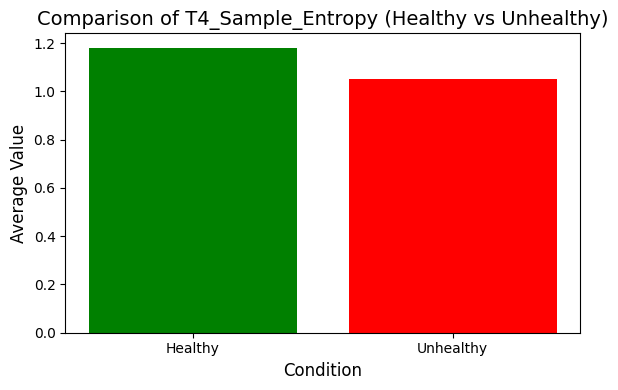

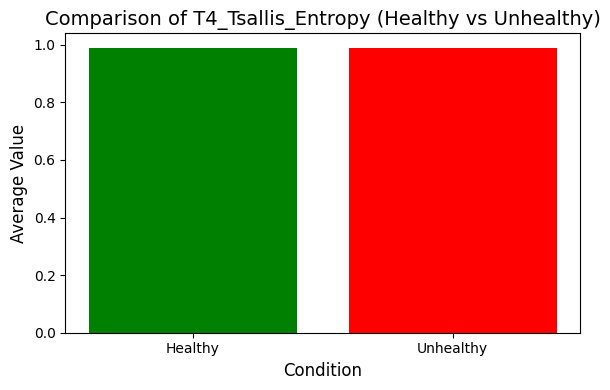

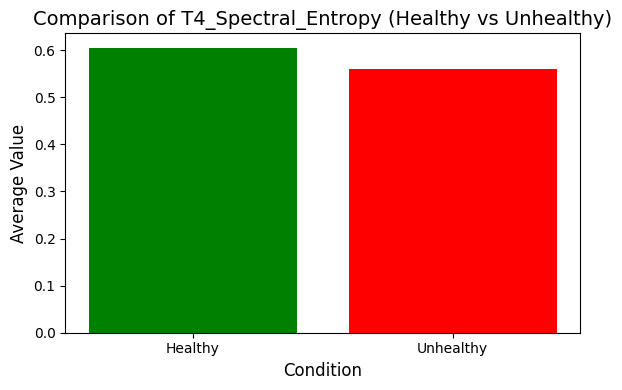

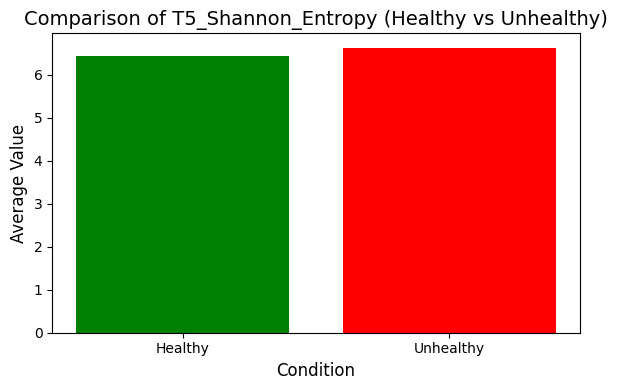

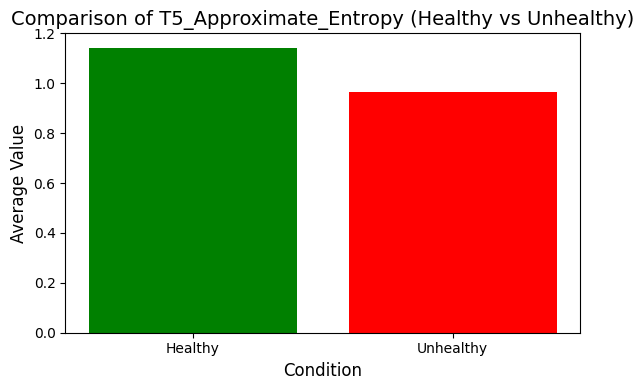

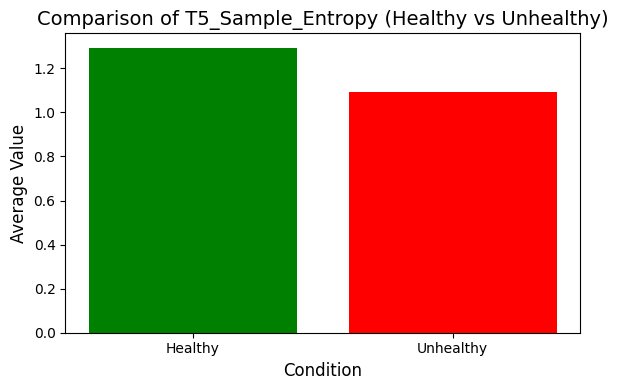

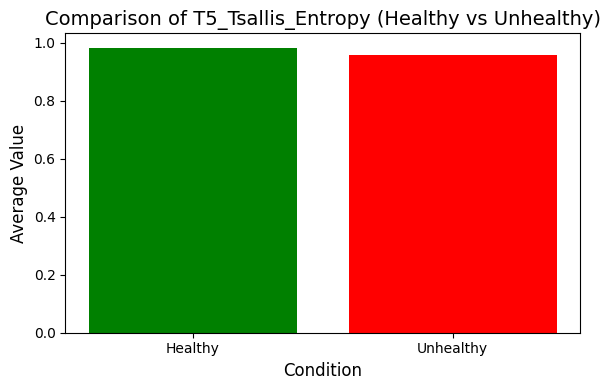

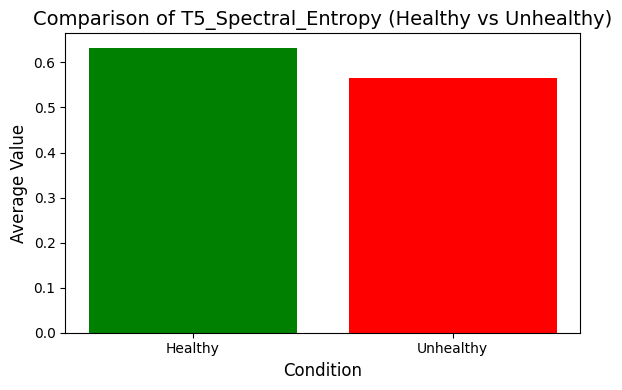

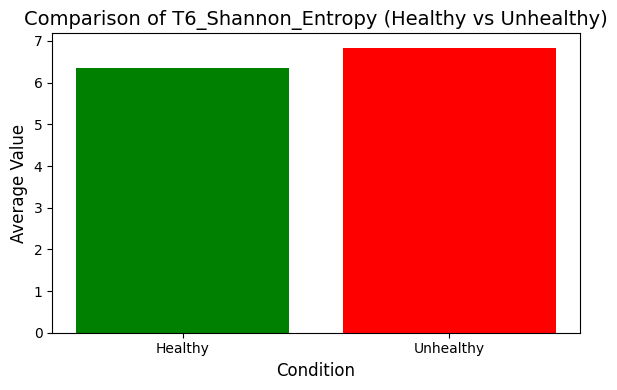

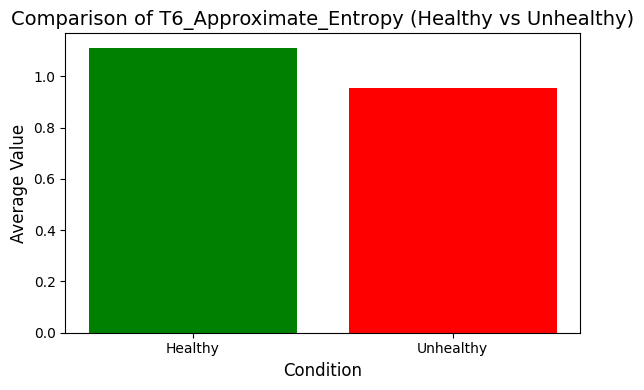

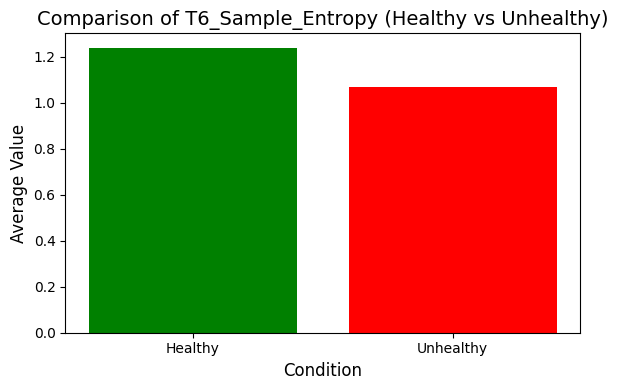

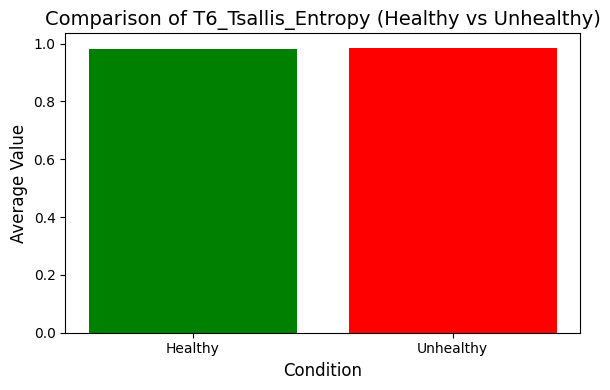

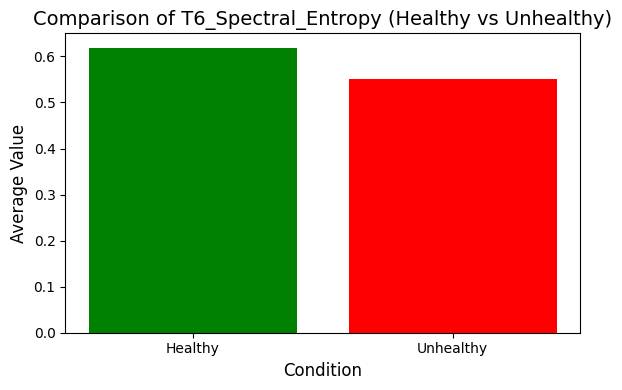

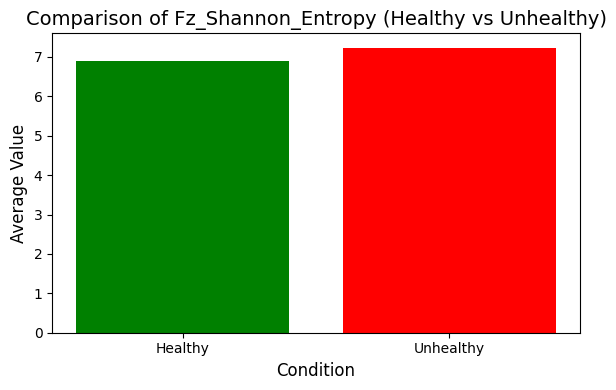

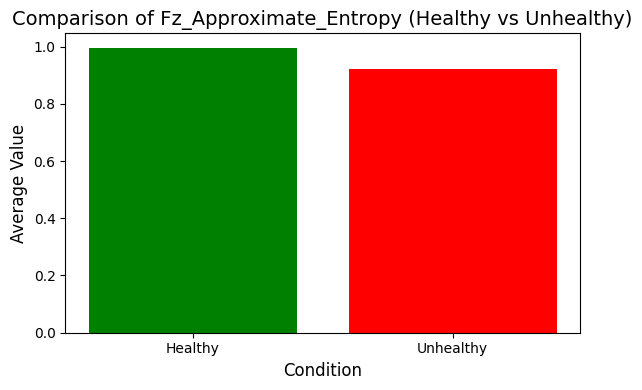

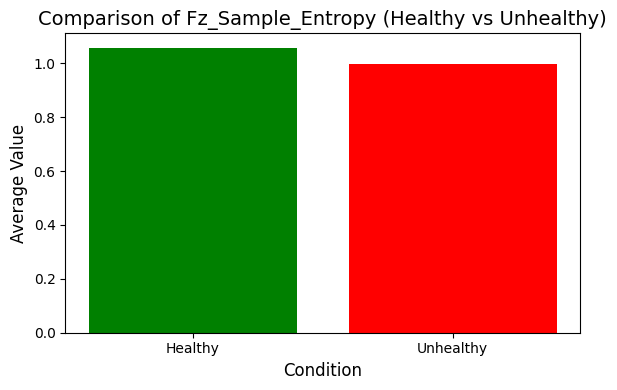

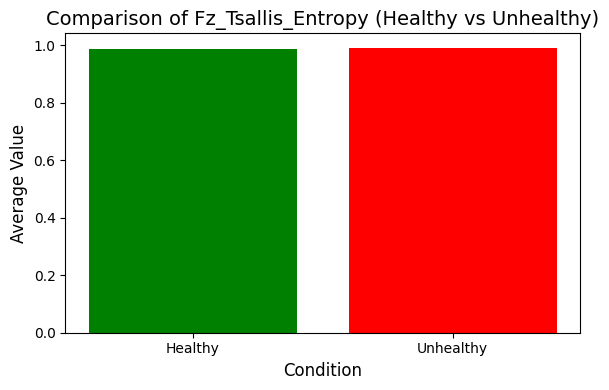

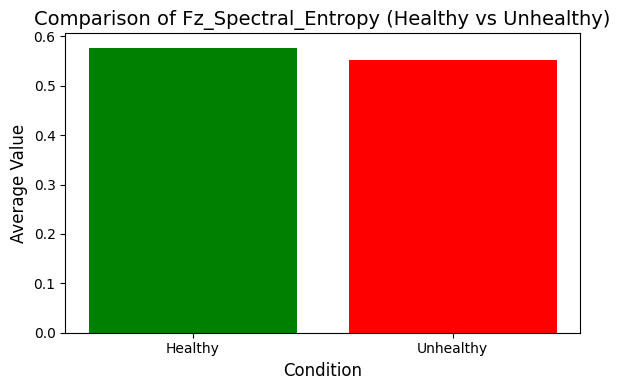

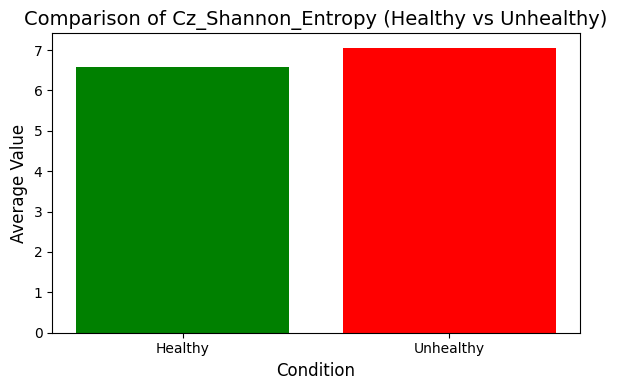

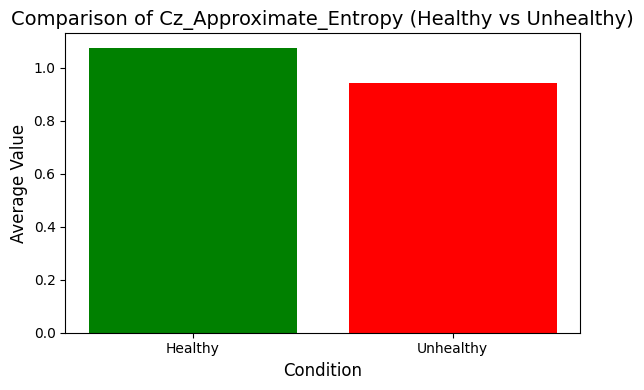

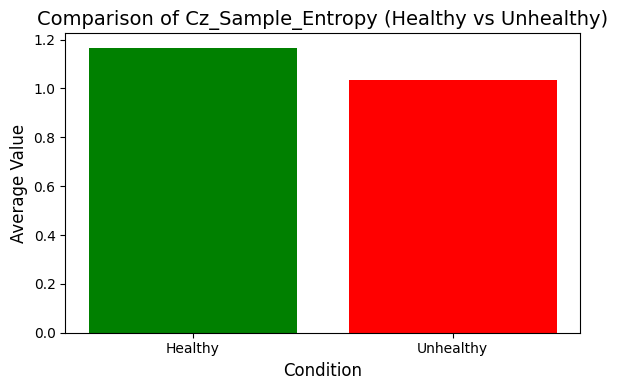

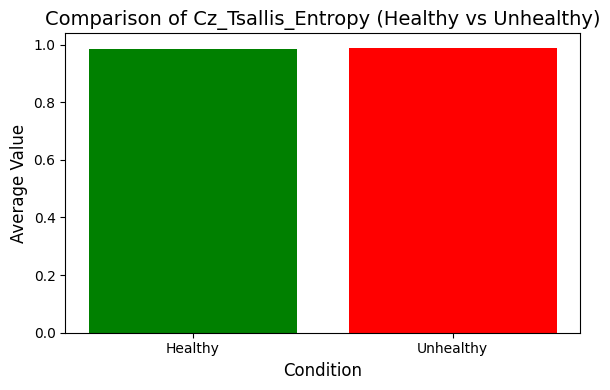

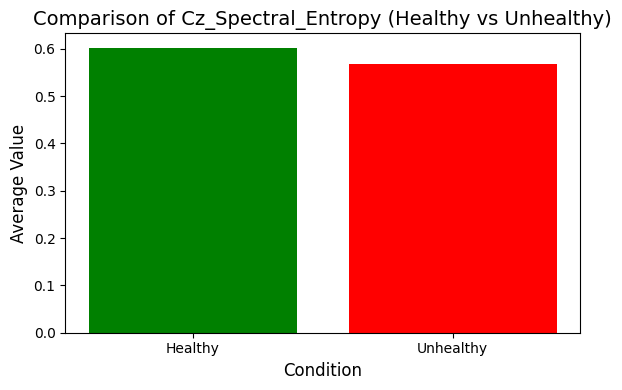

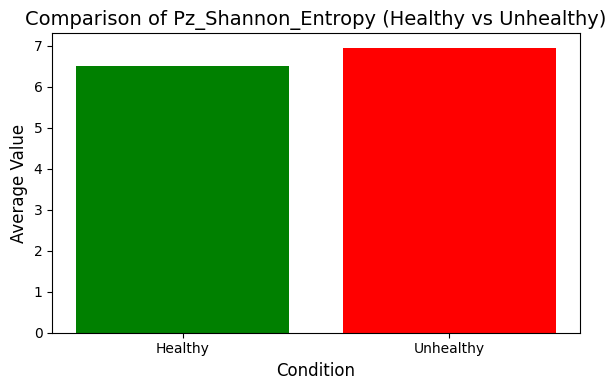

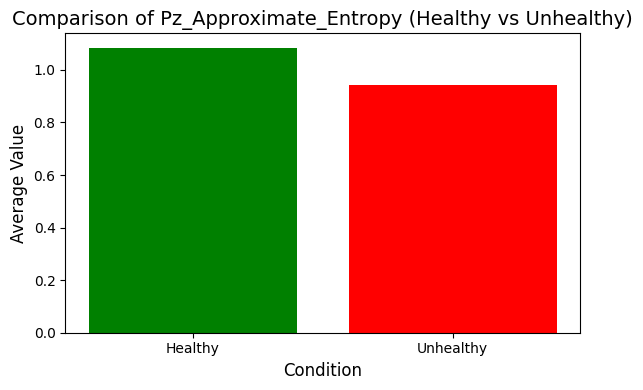

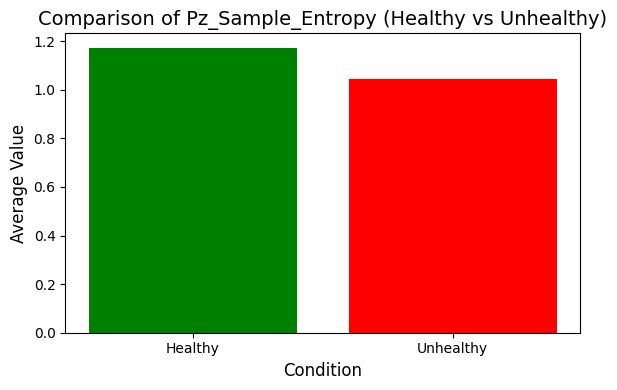

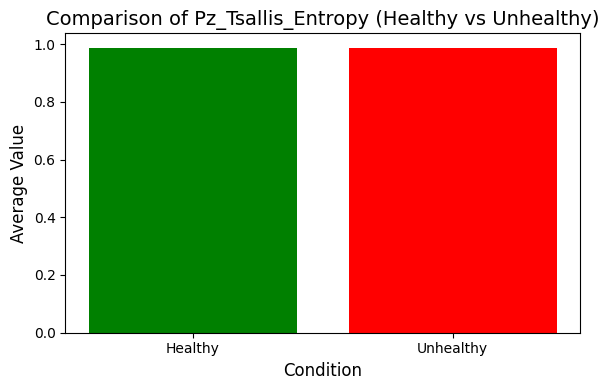

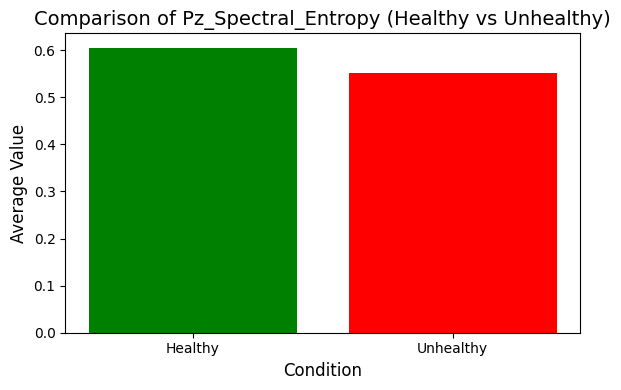

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
healthy_df = pd.read_csv('hfeature_vectors.csv')
unhealthy_df = pd.read_csv('feature_vectors.csv')

# Compute the average entropy values for each entropy type
healthy_avg = healthy_df.iloc[:, 1:].mean()
unhealthy_avg = unhealthy_df.iloc[:, 1:].mean()

# Plot individual graphs for each entropy type
entropy_types = healthy_avg.index

for entropy in entropy_types:
    # Create a bar plot for the current entropy
    plt.figure(figsize=(6, 4))
    plt.bar(['Healthy', 'Unhealthy'], [healthy_avg[entropy], unhealthy_avg[entropy]], color=['green', 'red'])

    # Add labels and title
    plt.title(f'Comparison of {entropy} (Healthy vs Unhealthy)', fontsize=14)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Condition', fontsize=12)
    plt.xticks(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


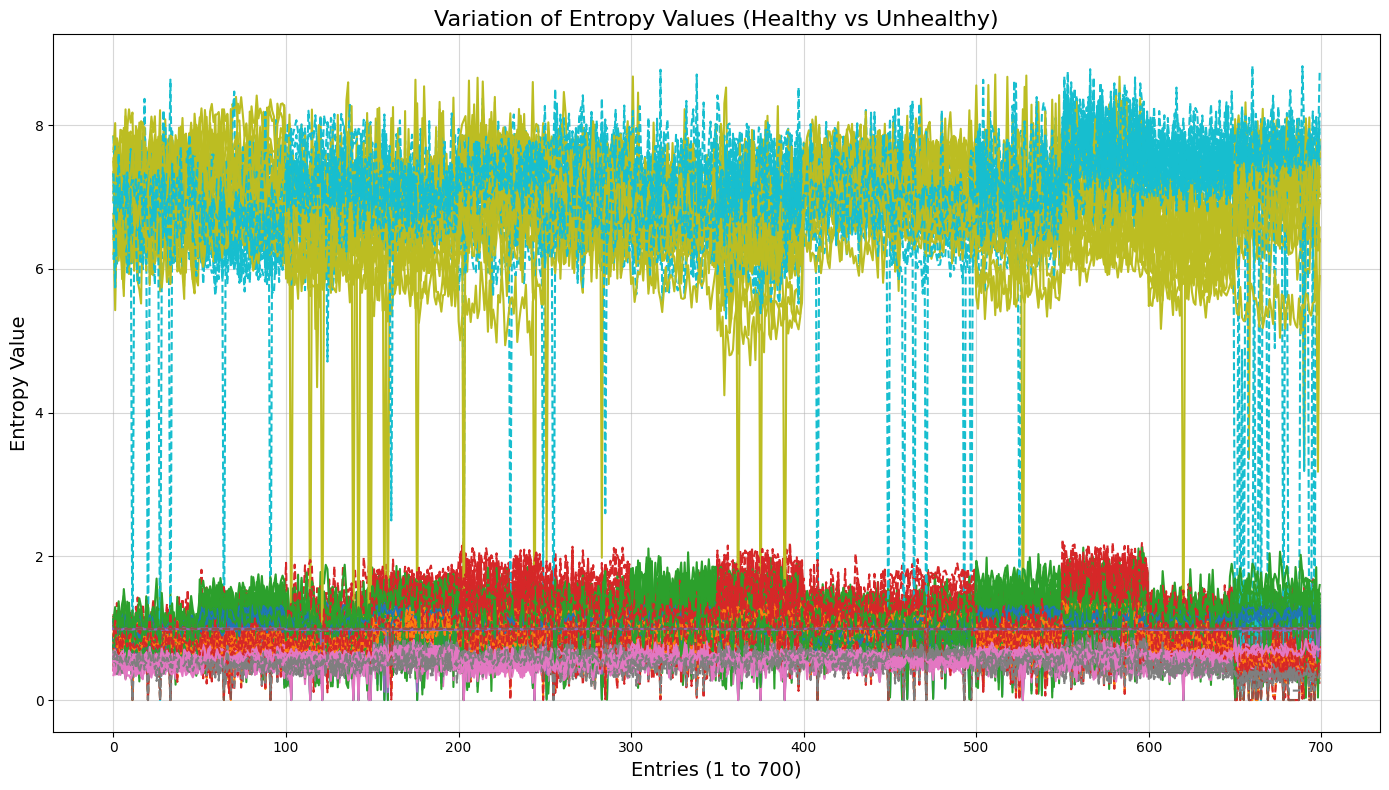

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
# healthy_df = pd.read_csv('hfeature_vectors.csv')
# unhealthy_df = pd.read_csv('feature_vectors.csv')

data = pd.read_csv('shuffled_combined_features.csv')
# Select the first 700 entries from both datasets
healthy_subset = healthy_df.iloc[:700, 1:]  # Exclude the label column
unhealthy_subset = unhealthy_df.iloc[:700, 1:]  # Exclude the label column

# Plot variation for each entropy type
entropy_types = healthy_subset.columns

plt.figure(figsize=(14, 8))

for entropy in entropy_types:
    plt.plot(healthy_subset.index, healthy_subset[entropy], label=f'Healthy - {entropy}', linestyle='-')
    plt.plot(unhealthy_subset.index, unhealthy_subset[entropy], label=f'Unhealthy - {entropy}', linestyle='--')

# Add labels, legend, and title
plt.title('Variation of Entropy Values (Healthy vs Unhealthy)', fontsize=16)
plt.xlabel('Entries (1 to 700)', fontsize=14)
plt.ylabel('Entropy Value', fontsize=14)
# plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-50-d17309b285a2>:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys())


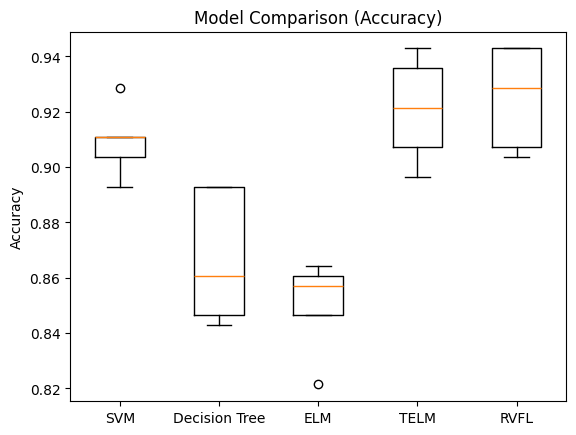

SVM Mean Accuracy: 90.93%
Decision Tree Mean Accuracy: 86.71%
ELM Mean Accuracy: 85.00%
TELM Mean Accuracy: 92.07%
RVFL Mean Accuracy: 92.50%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Load datasets
# healthy_df = pd.read_csv('hfeature_vectors.csv')
# unhealthy_df = pd.read_csv('feature_vectors.csv')

# # Add labels
# healthy_df['Label'] = 0  # Label for healthy
# unhealthy_df['Label'] = 1  # Label for unhealthy

# # Combine datasets
# data = pd.concat([healthy_df, unhealthy_df], ignore_index=True)

# # Shuffle the data
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the ELM and TELM classes
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

class TELM(ExtremeLearningMachine):
    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))  # Add input features to the hidden layer outputs
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))  # Add input features to the hidden layer outputs
        return np.dot(H, self.output_weights)

class RVFL:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid', include_bias=True):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,)) if include_bias else None
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function. Use 'sigmoid' or 'relu'.")

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        return np.dot(H, self.output_weights)

# Initialize models
models = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'ELM': ExtremeLearningMachine(input_size=X.shape[1], hidden_neurons=100),
    'TELM': TELM(input_size=X.shape[1], hidden_neurons=100),
    'RVFL': RVFL(input_size=X.shape[1], hidden_neurons=100)
}

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {name: [] for name in models}

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for name, model in models.items():
        if name in ['ELM', 'TELM', 'RVFL']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_binary = (y_pred > 0.5).astype(int)
        else:
            model.fit(X_train, y_train)
            y_pred_binary = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred_binary)
        cv_results[name].append(accuracy)

# Boxplot visualization
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.title('Model Comparison (Accuracy)')
plt.ylabel('Accuracy')
plt.show()

# Print mean accuracy for each model
for name, accuracies in cv_results.items():
    print(f"{name} Mean Accuracy: {np.mean(accuracies) * 100:.2f}%")



Evaluating with 4-Fold Cross-Validation
SVM - 4-Fold Mean Accuracy: 91.36%
Decision Tree - 4-Fold Mean Accuracy: 83.71%
ELM - 4-Fold Mean Accuracy: 84.64%
TELM - 4-Fold Mean Accuracy: 92.29%
RVFL - 4-Fold Mean Accuracy: 91.86%

Evaluating with 5-Fold Cross-Validation
SVM - 5-Fold Mean Accuracy: 90.93%
Decision Tree - 5-Fold Mean Accuracy: 86.71%
ELM - 5-Fold Mean Accuracy: 84.79%
TELM - 5-Fold Mean Accuracy: 90.93%
RVFL - 5-Fold Mean Accuracy: 91.57%

Evaluating with 6-Fold Cross-Validation
SVM - 6-Fold Mean Accuracy: 91.43%
Decision Tree - 6-Fold Mean Accuracy: 85.14%
ELM - 6-Fold Mean Accuracy: 85.72%
TELM - 6-Fold Mean Accuracy: 92.57%
RVFL - 6-Fold Mean Accuracy: 92.72%

Evaluating with 7-Fold Cross-Validation
SVM - 7-Fold Mean Accuracy: 90.79%
Decision Tree - 7-Fold Mean Accuracy: 87.29%
ELM - 7-Fold Mean Accuracy: 85.29%
TELM - 7-Fold Mean Accuracy: 91.43%
RVFL - 7-Fold Mean Accuracy: 91.21%

Evaluating with 8-Fold Cross-Validation
SVM - 8-Fold Mean Accuracy: 91.14%
Decision Tre

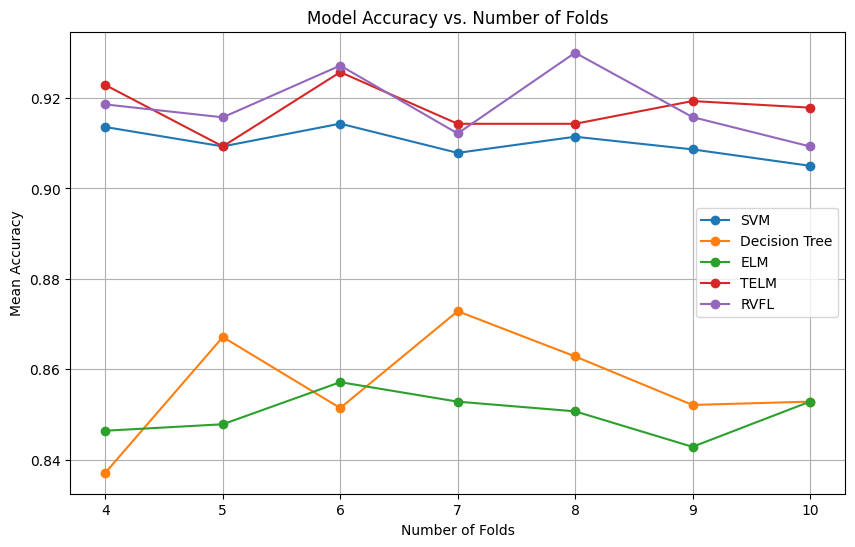

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('shuffled_combined_features.csv')

# Separate features and labels
X = data.iloc[:, :-1].values
y = data['Label'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define ELM, TELM, and RVFL classes
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function.")

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

class TELM(ExtremeLearningMachine):
    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))
        return np.dot(H, self.output_weights)

class RVFL:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid', include_bias=True):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,)) if include_bias else None
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function.")

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        return np.dot(H, self.output_weights)

# Store all results
all_cv_results = {}

# Loop through number of folds from 4 to 10
for n_folds in range(4, 11):
    print(f"\nEvaluating with {n_folds}-Fold Cross-Validation")

    # Initialize models for this fold run
    models = {
        'SVM': SVC(kernel='linear', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'ELM': ExtremeLearningMachine(input_size=X.shape[1], hidden_neurons=100),
        'TELM': TELM(input_size=X.shape[1], hidden_neurons=100),
        'RVFL': RVFL(input_size=X.shape[1], hidden_neurons=100)
    }

    # Initialize results
    cv_results = {name: [] for name in models}
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for name, model in models.items():
            # Reinitialize ELM-based models to get new random weights each time
            if name == 'ELM':
                model = ExtremeLearningMachine(input_size=X.shape[1], hidden_neurons=100)
            elif name == 'TELM':
                model = TELM(input_size=X.shape[1], hidden_neurons=100)
            elif name == 'RVFL':
                model = RVFL(input_size=X.shape[1], hidden_neurons=100)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_binary = (y_pred > 0.5).astype(int) if name in ['ELM', 'TELM', 'RVFL'] else y_pred
            accuracy = accuracy_score(y_test, y_pred_binary)
            cv_results[name].append(accuracy)

    # Store mean results
    all_cv_results[n_folds] = {name: np.mean(scores) for name, scores in cv_results.items()}

    # Print accuracies
    for name, scores in cv_results.items():
        print(f"{name} - {n_folds}-Fold Mean Accuracy: {np.mean(scores) * 100:.2f}%")

# Plot accuracy vs. number of folds
plt.figure(figsize=(10, 6))
for model_name in models.keys():
    accuracies = [all_cv_results[k][model_name] for k in sorted(all_cv_results.keys())]
    plt.plot(range(4, 11), accuracies, marker='o', label=model_name)

plt.title("Model Accuracy vs. Number of Folds")
plt.xlabel("Number of Folds")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import product

# Load dataset
data = pd.read_csv('shuffled_combined_features.csv')
X = data.iloc[:, :-1].values
y = data['Label'].values
X = StandardScaler().fit_transform(X)

# Define custom models
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid'):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

class TELM(ExtremeLearningMachine):
    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        H = np.hstack((X, H))
        return np.dot(H, self.output_weights)

class RVFL:
    def __init__(self, input_size, hidden_neurons, activation_function='sigmoid', include_bias=True):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,)) if include_bias else None
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + (self.biases if self.include_bias else 0))
        H = np.hstack((X, H))
        return np.dot(H, self.output_weights)

# Grid values
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dt_params = {'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
neuron_counts = [50, 100, 150]

# Store results
all_cv_results = {}

for n_folds in range(4, 11):
    print(f"\n{n_folds}-Fold Cross-Validation")
    cv_results = {'SVM': [], 'Decision Tree': [], 'ELM': [], 'TELM': [], 'RVFL': []}
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # --- SVM Grid Search ---
        best_svm_acc = 0
        for C, kernel in product(svm_params['C'], svm_params['kernel']):
            model = SVC(C=C, kernel=kernel)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            if acc > best_svm_acc:
                best_svm_acc = acc
        cv_results['SVM'].append(best_svm_acc)

        # --- Decision Tree Grid Search ---
        best_dt_acc = 0
        for max_depth, min_split in product(dt_params['max_depth'], dt_params['min_samples_split']):
            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_split)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            if acc > best_dt_acc:
                best_dt_acc = acc
        cv_results['Decision Tree'].append(best_dt_acc)

        # --- ELM, TELM, RVFL Neuron Search ---
        for name, model_class in zip(['ELM', 'TELM', 'RVFL'], [ExtremeLearningMachine, TELM, RVFL]):
            best_acc = 0
            for hn in neuron_counts:
                model = model_class(input_size=X.shape[1], hidden_neurons=hn)
                model.fit(X_train, y_train)
                y_pred = (model.predict(X_test) > 0.5).astype(int)
                acc = accuracy_score(y_test, y_pred)
                if acc > best_acc:
                    best_acc = acc
            cv_results[name].append(best_acc)

    # Store average accuracies
    all_cv_results[n_folds] = {name: np.mean(scores) for name, scores in cv_results.items()}

    # Print results
    for name, acc_list in cv_results.items():
        print(f"{name} - Mean Accuracy ({n_folds} folds): {np.mean(acc_list)*100:.2f}%")

# Plotting
plt.figure(figsize=(10, 6))
for model_name in all_cv_results[4].keys():
    plt.plot(list(all_cv_results.keys()),
             [all_cv_results[f][model_name] for f in all_cv_results],
             marker='o', label=model_name)
plt.title("Model Accuracy vs. Number of Folds (With Hyperparameter Tuning)")
plt.xlabel("Number of Folds")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



4-Fold Cross-Validation
SVM - Mean Accuracy (4 folds): 95.57%
Decision Tree - Mean Accuracy (4 folds): 86.29%
ELM - Mean Accuracy (4 folds): 87.43%
TELM - Mean Accuracy (4 folds): 92.36%
RVFL - Mean Accuracy (4 folds): 92.50%

5-Fold Cross-Validation
SVM - Mean Accuracy (5 folds): 96.07%
Decision Tree - Mean Accuracy (5 folds): 88.07%
ELM - Mean Accuracy (5 folds): 87.50%
TELM - Mean Accuracy (5 folds): 92.00%
RVFL - Mean Accuracy (5 folds): 93.07%

6-Fold Cross-Validation
SVM - Mean Accuracy (6 folds): 96.14%
Decision Tree - Mean Accuracy (6 folds): 86.93%
ELM - Mean Accuracy (6 folds): 85.50%
TELM - Mean Accuracy (6 folds): 93.07%
RVFL - Mean Accuracy (6 folds): 93.29%

7-Fold Cross-Validation
SVM - Mean Accuracy (7 folds): 96.43%
Decision Tree - Mean Accuracy (7 folds): 88.14%
ELM - Mean Accuracy (7 folds): 86.79%
TELM - Mean Accuracy (7 folds): 92.36%
RVFL - Mean Accuracy (7 folds): 92.50%

8-Fold Cross-Validation
SVM - Mean Accuracy (8 folds): 96.36%
Decision Tree - Mean Accuracy

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading and preprocessing data...")
data = pd.read_csv('shuffled_combined_features.csv')
X = data.iloc[:, :-1].values
y = data['Label'].values

# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define custom models with enhanced hyperparameters
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.regularization = regularization

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  # Clipping for numerical stability
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Add regularization for better generalization
        if self.regularization > 0:
            # Use ridge regression formula: (H^T * H + λI)^(-1) * H^T * y
            HTH = np.dot(H.T, H)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H.T), y)
        else:
            # Standard pseudoinverse
            self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

class TELM(ExtremeLearningMachine):
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None, direct_link_weight=1.0):
        super().__init__(input_size, hidden_neurons, activation_function, regularization, random_state)
        self.direct_link_weight = direct_link_weight  # Weight for the direct link connection

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Combine original features with hidden layer (direct link)
        # Apply weighting to balance direct link influence
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

class RVFL:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 include_bias=True, regularization=0.001, random_state=None,
                 scale_range=1.0, direct_link_weight=1.0):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.regularization = regularization
        self.direct_link_weight = direct_link_weight
        self.scale_range = scale_range

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        # Initialize weights with controlled scaling
        self.input_weights = np.random.uniform(-scale_range, scale_range,
                                             (self.input_size, self.hidden_neurons))

        if include_bias:
            self.biases = np.random.uniform(-scale_range, scale_range, (self.hidden_neurons,))
        else:
            self.biases = None

        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))

        # Combine original features with hidden layer
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

# Create hyperparameter grids - expanded for better search
print("Setting up hyperparameter grids...")
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define neural network hyperparameter combinations
nn_params = {
    'hidden_neurons': [50, 100, 200, 300],
    'activation_function': ['sigmoid', 'relu', 'tanh', 'leaky_relu'],
    'regularization': [0.0001, 0.001, 0.01, 0.1],
    'direct_link_weight': [0.5, 1.0, 2.0]  # Only for TELM and RVFL
}

# Store results
all_cv_results = {}
best_models = {}
best_params = {}

# Loop through different k-fold configurations
for n_folds in range(10, 11):
    print(f"\n{n_folds}-Fold Cross-Validation")
    cv_results = {
        'SVM': [], 'Decision Tree': [], 'Random Forest': [], 'Gradient Boosting': [],
        'ELM': [], 'TELM': [], 'RVFL': []
    }

    fold_params = {
        'SVM': [], 'Decision Tree': [], 'Random Forest': [], 'Gradient Boosting': [],
        'ELM': [], 'TELM': [], 'RVFL': []
    }

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    fold_num = 1
    for train_idx, test_idx in kf.split(X):
        print(f"  Processing fold {fold_num}/{n_folds}")
        start_time = time.time()

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # --- Traditional ML models using GridSearchCV for efficient search ---

        # SVM with GridSearchCV
        svm_grid = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1)
        svm_grid.fit(X_train, y_train)
        y_pred = svm_grid.predict(X_test)
        svm_acc = accuracy_score(y_test, y_pred)
        cv_results['SVM'].append(svm_acc)
        fold_params['SVM'].append(svm_grid.best_params_)

        # Decision Tree with GridSearchCV
        dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=3, n_jobs=-1)
        dt_grid.fit(X_train, y_train)
        y_pred = dt_grid.predict(X_test)
        dt_acc = accuracy_score(y_test, y_pred)
        cv_results['Decision Tree'].append(dt_acc)
        fold_params['Decision Tree'].append(dt_grid.best_params_)

        # Random Forest with GridSearchCV
        rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1)
        rf_grid.fit(X_train, y_train)
        y_pred = rf_grid.predict(X_test)
        rf_acc = accuracy_score(y_test, y_pred)
        cv_results['Random Forest'].append(rf_acc)
        fold_params['Random Forest'].append(rf_grid.best_params_)

        # Gradient Boosting with GridSearchCV
        gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=3, n_jobs=-1)
        gb_grid.fit(X_train, y_train)
        y_pred = gb_grid.predict(X_test)
        gb_acc = accuracy_score(y_test, y_pred)
        cv_results['Gradient Boosting'].append(gb_acc)
        fold_params['Gradient Boosting'].append(gb_grid.best_params_)

        # --- Custom Neural Network Models with Hyperparameter Tuning ---

        # ELM Hyperparameter Search
        best_elm_acc = 0
        best_elm_params = {}
        for neurons in nn_params['hidden_neurons']:
            for activation in nn_params['activation_function']:
                for reg in nn_params['regularization']:
                    elm = ExtremeLearningMachine(
                        input_size=X.shape[1],
                        hidden_neurons=neurons,
                        activation_function=activation,
                        regularization=reg,
                        random_state=42
                    )
                    elm.fit(X_train, y_train)
                    y_pred = (elm.predict(X_test) > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred)
                    if acc > best_elm_acc:
                        best_elm_acc = acc
                        best_elm_params = {
                            'hidden_neurons': neurons,
                            'activation_function': activation,
                            'regularization': reg
                        }
        cv_results['ELM'].append(best_elm_acc)
        fold_params['ELM'].append(best_elm_params)

        # TELM Hyperparameter Search
        best_telm_acc = 0
        best_telm_params = {}
        for neurons in nn_params['hidden_neurons']:
            for activation in nn_params['activation_function']:
                for reg in nn_params['regularization']:
                    for dlw in nn_params['direct_link_weight']:
                        telm = TELM(
                            input_size=X.shape[1],
                            hidden_neurons=neurons,
                            activation_function=activation,
                            regularization=reg,
                            random_state=42,
                            direct_link_weight=dlw
                        )
                        telm.fit(X_train, y_train)
                        y_pred = (telm.predict(X_test) > 0.5).astype(int)
                        acc = accuracy_score(y_test, y_pred)
                        if acc > best_telm_acc:
                            best_telm_acc = acc
                            best_telm_params = {
                                'hidden_neurons': neurons,
                                'activation_function': activation,
                                'regularization': reg,
                                'direct_link_weight': dlw
                            }
        cv_results['TELM'].append(best_telm_acc)
        fold_params['TELM'].append(best_telm_params)

        # RVFL Hyperparameter Search
        best_rvfl_acc = 0
        best_rvfl_params = {}
        for neurons in nn_params['hidden_neurons']:
            for activation in nn_params['activation_function']:
                for reg in nn_params['regularization']:
                    for dlw in nn_params['direct_link_weight']:
                        rvfl = RVFL(
                            input_size=X.shape[1],
                            hidden_neurons=neurons,
                            activation_function=activation,
                            include_bias=True,
                            regularization=reg,
                            random_state=42,
                            direct_link_weight=dlw
                        )
                        rvfl.fit(X_train, y_train)
                        y_pred = (rvfl.predict(X_test) > 0.5).astype(int)
                        acc = accuracy_score(y_test, y_pred)
                        if acc > best_rvfl_acc:
                            best_rvfl_acc = acc
                            best_rvfl_params = {
                                'hidden_neurons': neurons,
                                'activation_function': activation,
                                'regularization': reg,
                                'direct_link_weight': dlw
                            }
        cv_results['RVFL'].append(best_rvfl_acc)
        fold_params['RVFL'].append(best_rvfl_params)

        fold_time = time.time() - start_time
        print(f"  Fold {fold_num} completed in {fold_time:.2f} seconds")
        fold_num += 1

    # Store average accuracies
    all_cv_results[n_folds] = {name: np.mean(scores) for name, scores in cv_results.items()}

    # Find the most common (majority vote) best parameters for each model
    for model_name in fold_params:
        param_counts = {}
        if model_name in ['SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting']:
            # For sklearn models, count parameter occurrences
            for param_dict in fold_params[model_name]:
                param_key = tuple(sorted(param_dict.items()))
                param_counts[param_key] = param_counts.get(param_key, 0) + 1

            # Find most common parameters
            if param_counts:
                most_common = max(param_counts.items(), key=lambda x: x[1])
                best_params[model_name] = dict(most_common[0])
        else:
            # For neural network models, find best parameters based on average performance
            best_params[model_name] = {}
            for param in fold_params[model_name][0].keys():
                values = [fold_param[param] for fold_param in fold_params[model_name]]
                # For numeric parameters, take average of top performers
                if isinstance(values[0], (int, float)):
                    best_params[model_name][param] = sum(values) / len(values)
                else:
                    # For categorical parameters, take most common
                    from collections import Counter
                    counter = Counter(values)
                    best_params[model_name][param] = counter.most_common(1)[0][0]

    # Print results for this fold configuration
    print(f"\nResults for {n_folds}-fold cross-validation:")
    for name, acc_list in cv_results.items():
        print(f"{name} - Mean Accuracy: {np.mean(acc_list)*100:.2f}%")

    print("\nBest parameters:")
    for model_name, params in best_params.items():
        print(f"{model_name}: {params}")

# Plotting results
plt.figure(figsize=(12, 8))
models = list(all_cv_results[5].keys())
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for i, model_name in enumerate(models):
    plt.plot(list(all_cv_results.keys()),
             [all_cv_results[f][model_name] * 100 for f in all_cv_results],
             marker=markers[i % len(markers)],
             color=colors[i % len(colors)],
             linewidth=2,
             label=model_name)

plt.title("Model Accuracy vs. Number of Folds (Enhanced Hyperparameter Tuning)", fontsize=14)
plt.xlabel("Number of Folds", fontsize=12)
plt.ylabel("Mean Accuracy (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()

# Add horizontal and vertical grid lines
plt.grid(True)
plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Train final models with best parameters
print("\nTraining final models with best parameters...")
best_fold = max(all_cv_results.keys(), key=lambda k: sum(all_cv_results[k].values()))
print(f"Using best parameters from {best_fold}-fold cross-validation")

final_models = {}
final_accuracies = {}

# SVM final model
if 'SVM' in best_params:
    final_models['SVM'] = SVC(**best_params['SVM'])
    final_models['SVM'].fit(X, y)
    final_accuracies['SVM'] = np.mean(cv_results['SVM'])

# Decision Tree final model
if 'Decision Tree' in best_params:
    final_models['Decision Tree'] = DecisionTreeClassifier(**best_params['Decision Tree'])
    final_models['Decision Tree'].fit(X, y)
    final_accuracies['Decision Tree'] = np.mean(cv_results['Decision Tree'])

# Random Forest final model
if 'Random Forest' in best_params:
    final_models['Random Forest'] = RandomForestClassifier(**best_params['Random Forest'])
    final_models['Random Forest'].fit(X, y)
    final_accuracies['Random Forest'] = np.mean(cv_results['Random Forest'])

# Gradient Boosting final model
if 'Gradient Boosting' in best_params:
    final_models['Gradient Boosting'] = GradientBoostingClassifier(**best_params['Gradient Boosting'])
    final_models['Gradient Boosting'].fit(X, y)
    final_accuracies['Gradient Boosting'] = np.mean(cv_results['Gradient Boosting'])

# ELM final model
if 'ELM' in best_params:
    final_models['ELM'] = ExtremeLearningMachine(
        input_size=X.shape[1],
        **{k: v for k, v in best_params['ELM'].items() if k != 'direct_link_weight'},
        random_state=42
    )
    final_models['ELM'].fit(X, y)
    final_accuracies['ELM'] = np.mean(cv_results['ELM'])

# TELM final model
if 'TELM' in best_params:
    final_models['TELM'] = TELM(
        input_size=X.shape[1],
        **best_params['TELM'],
        random_state=42
    )
    final_models['TELM'].fit(X, y)
    final_accuracies['TELM'] = np.mean(cv_results['TELM'])

# RVFL final model
if 'RVFL' in best_params:
    final_models['RVFL'] = RVFL(
        input_size=X.shape[1],
        **best_params['RVFL'],
        random_state=42
    )
    final_models['RVFL'].fit(X, y)
    final_accuracies['RVFL'] = np.mean(cv_results['RVFL'])

# Print final results
print("\nFinal model accuracies:")
for model_name, acc in final_accuracies.items():
    print(f"{model_name}: {acc*100:.2f}%")

# Find best overall model
best_model_name = max(final_accuracies, key=final_accuracies.get)
print(f"\nBest model: {best_model_name} with accuracy: {final_accuracies[best_model_name]*100:.2f}%")
print(f"Best parameters: {best_params[best_model_name]}")

# Save best model parameters to file
with open('best_model_params.txt', 'w') as f:
    f.write(f"Best model: {best_model_name}\n")
    f.write(f"Accuracy: {final_accuracies[best_model_name]*100:.2f}%\n")
    f.write(f"Parameters: {best_params[best_model_name]}\n")

print("\nTraining complete. Results saved to 'best_model_params.txt'")

Loading and preprocessing data...
Setting up hyperparameter grids...

10-Fold Cross-Validation
  Processing fold 1/10
  Fold 1 completed in 543.10 seconds
  Processing fold 2/10
  Fold 2 completed in 533.98 seconds
  Processing fold 3/10
  Fold 3 completed in 521.99 seconds
  Processing fold 4/10
  Fold 4 completed in 523.17 seconds
  Processing fold 5/10
  Fold 5 completed in 518.38 seconds
  Processing fold 6/10
  Fold 6 completed in 524.77 seconds
  Processing fold 7/10
  Fold 7 completed in 523.89 seconds
  Processing fold 8/10
  Fold 8 completed in 551.82 seconds
  Processing fold 9/10
  Fold 9 completed in 514.95 seconds
  Processing fold 10/10
  Fold 10 completed in 605.05 seconds

Results for 10-fold cross-validation:
SVM - Mean Accuracy: 95.79%
Decision Tree - Mean Accuracy: 87.43%
Random Forest - Mean Accuracy: 95.86%
Gradient Boosting - Mean Accuracy: 96.71%
ELM - Mean Accuracy: 91.93%
TELM - Mean Accuracy: 94.64%
RVFL - Mean Accuracy: 94.64%

Best parameters:
SVM: {'C': 10,

KeyError: 5

<Figure size 1200x800 with 0 Axes>

In [ ]:
# --- Colab Setup ---
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

# --- Original Script Starts Here ---
import numpy as np
import pandas as pd
from types import SimpleNamespace
import itertools
import os

# -- User Configuration --
# Only change this path to point to your CSV dataset
# IMPORTANT: Update this path to where your CSV is located in your Google Drive
# Example: '/content/drive/My Drive/YourFolderName/AD_CN_Axial_ResNet50_features_reduced.csv'
# If using the shuffled_combined_features.csv, update the filename accordingly
DATA_PATH = 'shuffled_combined_features.csv' # <-- CHANGE THIS PATH

# --- Ensure the file exists (Optional but recommended) ---
if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please upload the file to your Google Drive and update the DATA_PATH variable.")
    # It's better to exit here if the file is crucial
    exit()

# -- Data loading and preprocessing --
def load_data(csv_file, test_size=0.3, random_state=42):
    """
    Load flattened features from CSV, one-hot encode labels (-1/1), and split into train/test.
    Returns: X_train, Y_train, X_test, Y_test, classes
    """
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    classes = np.unique(y)
    # one-hot encoding
    Y = np.zeros((y.shape[0], classes.size))
    for i, cls in enumerate(classes):
        Y[y == cls, i] = 1
    # shuffle and split
    rng = np.random.RandomState(random_state)
    idx = rng.permutation(X.shape[0])
    split = int((1 - test_size) * X.shape[0])
    train_idx, test_idx = idx[:split], idx[split:]
    return X[train_idx], Y[train_idx], X[test_idx], Y[test_idx], classes

# -- Majority Voting --
def majorityVoting(Y_true, pred_matrix):
    """
    pred_matrix: shape (n_samples, ensemble_size), entries are class indices
    Computes accuracy by majority vote.
    """
    n_samples = Y_true.shape[0]
    true_idx = np.argmax(Y_true, axis=1)
    preds = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        votes = pred_matrix[i]
        counts = np.bincount(votes.astype(int), minlength=len(true_idx))
        preds[i] = np.argmax(counts)
    return np.mean(preds == true_idx)

# -- edRVFL Classifier --
class edRVFL:
    def __init__(self, classes, hp: dict):
        self.attr = SimpleNamespace(**hp)
        self.attr.lamb = 2 ** self.attr.C
        self.attr.RandState = np.random.RandomState(self.attr.randseed)
        self.classes = classes
        # state_dict will store parameters and indices for each layer
        self.state_dict = SimpleNamespace(w=[], b=[], beta=[], mean=[], std=[],
                                          # s_idx and d_idx store indices relative to the NEWLY added nodes (A_new)
                                          s_idx=[], d_idx=[])
        # Ensure drop_amt and select_amt are non-negative and do not exceed N
        self.drop_amt = int(np.floor(min(max(0, self.attr.drop), 1.0) * self.attr.N))
        self.select_amt = int(np.floor(min(max(0, self.attr.select), 1.0) * self.attr.N))


    def _activation(self, X):
        a = self.attr.activation
        if a == 0: # ReLU
            return np.maximum(0, X)
        elif a == 1: # SeLU
            alpha, scale = 1.67326, 1.0507
            return scale * np.where(X>=0, X, alpha*(np.exp(X)-1))
        elif a == 2: # Sigmoid
            return 1/(1+np.exp(-X))
        else: # Swish (approximation)
            sig = 1/(1+np.exp(-X))
            return X * sig

    def _solve_beta(self, A, T):
        n, d = A.shape
        lam = self.attr.lamb
        # Handle cases where C is very small (lam approaches 1) or 0 explicitly
        if self.attr.C == 0 or lam < 1e-9: # Treat C=0 or very small lam as pseudo-inverse with regularization
             # Add small identity to handle potential singularity issues
             return np.linalg.pinv(A.T @ A + 1e-6 * np.eye(d)) @ A.T @ T
        if d < n:
            # Ridge Regression solution for d < n
            return np.linalg.solve(np.eye(d)/lam + A.T @ A, A.T @ T)
        else:
            # Ridge Regression solution for d >= n (using Woodbury identity)
            return A.T @ np.linalg.solve(np.eye(n)/lam + A @ A.T, T)


    def fit(self, X, Y):
        self.rawX = X.copy()
        self.ensemble_preds = []
        A_sel_prev = None # To hold A_sel features carried from the previous layer
        n, d_raw = X.shape # Original number of features

        for layer in range(self.attr.L):
            # 1. Generate new hidden nodes for this layer based on raw features
            # The weights connect raw features to the new nodes
            num_new_nodes = self.attr.N # Generate N new nodes per layer
            W = 2 * self.attr.RandState.rand(num_new_nodes, d_raw) - 1
            b = self.attr.RandState.rand(num_new_nodes)

            # Scale weights
            norms = np.linalg.norm(W, axis=1, keepdims=True)
            # Add a small epsilon to norms to prevent division by zero if a weight vector is all zeros
            norms[norms == 0] = 1e-9
            W = (self.attr.S * W) / norms

            # Compute hidden layer output for the new nodes based on raw features
            H_new = self.rawX @ W.T

            # Normalize and add bias
            mean_new, std_new = H_new.mean(axis=0), H_new.std(axis=0)
            # Add a small epsilon to std to prevent division by zero
            std_new[std_new == 0] = 1e-9
            H_norm = (H_new - mean_new) / std_new + b

            A_new = self._activation(H_norm) # Newly generated hidden nodes for this layer (shape: n, N)


            # 2. Construct A_all for beta calculation
            # A_all includes raw features, selected features from the previous layer, newly generated features, and bias
            if layer == 0:
                # Layer 0: raw features + newly generated nodes + bias
                A_all = np.concatenate([self.rawX, A_new, np.ones((n, 1))], axis=1)
                # Index in A_all where A_new starts
                idx_A_new_start_in_A_all = d_raw
            else:
                # Layer > 0: raw features + selected from previous + newly generated + bias
                # A_sel_prev holds the selected features from the (layer-1)'s newly generated nodes
                A_all = np.concatenate([self.rawX, A_sel_prev, A_new, np.ones((n, 1))], axis=1)
                # Index in A_all where A_new starts
                idx_A_new_start_in_A_all = d_raw + A_sel_prev.shape[1]


            # 3. Solve for output weights (beta) using A_all
            beta = self._solve_beta(A_all, Y)
            self.state_dict.beta.append(beta)

            # 4. Feature Selection/Dropping from the newly added nodes (A_new)
            # Select/drop nodes based on their beta weights in A_all
            # Get beta weights corresponding to A_new in A_all
            beta_A_new = beta[idx_A_new_start_in_A_all : idx_A_new_start_in_A_all + num_new_nodes]

            # Calculate norms for selection/dropping from A_new nodes' beta weights
            if beta_A_new.ndim == 1: # Handle case with single output class
                 norms_A_new = np.abs(beta_A_new)
            else: # Handle multi-output classes (norm along the output dimension)
                 norms_A_new = np.linalg.norm(beta_A_new, ord=1 if self.attr.fs==0 else 2, axis=1)

            # Rank nodes in A_new based on norms (descending)
            ranked_A_new_indices = np.argsort(norms_A_new)[::-1]

            # Indices of nodes selected from A_new for the next layer's A_sel (relative to A_new)
            sel_idx_A_new = ranked_A_new_indices[:self.select_amt]
            # Store these indices (relative to the newly generated nodes of this layer)
            self.state_dict.s_idx.append(sel_idx_A_new)

            # Indices of nodes kept from A_new for the next layer's A_drop (relative to A_new)
            # The number of nodes kept is N - drop_amt
            keep_indices_for_Adrop_A_new = ranked_A_new_indices[:(num_new_nodes - self.drop_amt)]
            # Store these indices (relative to the newly generated nodes of this layer)
            self.state_dict.d_idx.append(keep_indices_for_Adrop_A_new)


            # 5. Prepare A_sel and A_drop for the *next* layer's input X
            # A_sel for the next layer comes from A_new based on selection indices
            A_sel_next = A_new[:, sel_idx_A_new]

            # A_drop for the next layer comes from A_new based on keeping indices
            A_drop_next = A_new[:, keep_indices_for_Adrop_A_new]


            # 6. Prepare X for the next layer's input
            # X for the next layer consists of raw features, A_sel from current layer, and A_drop from current layer
            X = np.concatenate([self.rawX, A_sel_next, A_drop_next], axis=1)
            # Update A_sel_prev for the next iteration to be A_sel_next from this layer
            A_sel_prev = A_sel_next


            # 7. Store state for prediction (W, b, mean, std for the *newly added nodes* of this layer)
            self.state_dict.w.append(W)
            self.state_dict.b.append(b)
            self.state_dict.mean.append(mean_new)
            self.state_dict.std.append(std_new)

            # 8. Compute and store ensemble prediction for the current layer's A_all
            # This uses the A_all constructed in step 2 with rawX, A_sel_prev (from previous), and A_new (from current)
            # The matrix multiplication A_all @ beta happens here
            preds = np.argmax(A_all @ beta, axis=1)
            self.ensemble_preds.append(preds)

        # Calculate training accuracies for each ensemble size (majority voting over layers 1 to L)
        ensemble_preds_arr = np.vstack(self.ensemble_preds).T # Shape (n_samples, L)
        train_acc = [majorityVoting(Y, ensemble_preds_arr[:, :L_ens]) for L_ens in range(1, self.attr.L + 1)]
        return np.array(train_acc)


    def predict(self, X, Y=None):
        n = X.shape[0]
        self.rawXe = X.copy()
        preds_list = []
        A_sel_prev_pred = None # To hold A_sel features carried from the previous layer during prediction

        d_raw = self.rawXe.shape[1] # Original number of features

        for layer in range(self.attr.L):
            # 1. Generate new hidden nodes for this layer based on raw features, using stored state from training
            W = self.state_dict.w[layer]
            b = self.state_dict.b[layer]
            mean = self.state_dict.mean[layer]
            std = self.state_dict.std[layer]

            # Compute hidden layer output for the new nodes based on raw features
            H_new_pred = self.rawXe @ W.T

            # Normalize and add bias using stored mean and std
            H_norm_pred = (H_new_pred - mean) / std + b

            # Apply activation function
            A_new_pred = self._activation(H_norm_pred) # Newly generated hidden nodes for this layer in predict (shape: n, N)


            # 2. Construct A_all for prediction using raw features, selected from previous, newly generated
            if layer == 0:
                # Layer 0: raw features + newly generated nodes + bias
                A_all_pred = np.concatenate([self.rawXe, A_new_pred, np.ones((n, 1))], axis=1)
            else:
                 # Layer > 0: raw features + selected from previous + newly generated + bias
                 # A_sel_prev_pred holds the selected features from the (layer-1)'s newly generated nodes during prediction
                 A_all_pred = np.concatenate([self.rawXe, A_sel_prev_pred, A_new_pred, np.ones((n, 1))], axis=1)


            # 3. Get the beta weights for this layer (trained weights)
            beta = self.state_dict.beta[layer]

            # 4. Compute the prediction for this layer's A_all
            # The matrix multiplication A_all_pred @ beta happens here
            preds_layer = np.argmax(A_all_pred @ beta, axis=1)
            preds_list.append(preds_layer)


            # 5. Prepare A_sel and A_drop for the *next* layer's input X during prediction
            # These should be built based on the same logic and stored indices used during training.

            # A_sel for the next layer comes from A_new_pred based on stored selection indices (relative to A_new)
            sel_idx_A_new_train = self.state_dict.s_idx[layer] # Indices stored during training
            A_sel_next_pred = A_new_pred[:, sel_idx_A_new_train]

            # A_drop for the next layer comes from A_new_pred based on stored keeping indices (relative to A_new)
            keep_indices_for_Adrop_A_new_train = self.state_dict.d_idx[layer] # Indices stored during training
            A_drop_next_pred = A_new_pred[:, keep_indices_for_Adrop_A_new_train]


            # 6. Prepare X for the next layer's prediction pass
            # X for the next layer consists of raw features, A_sel from current layer, and A_drop from current layer
            X = np.concatenate([self.rawXe, A_sel_next_pred, A_drop_next_pred], axis=1)
            # Update A_sel_prev_pred for the next iteration to be A_sel_next_pred from this layer
            A_sel_prev_pred = A_sel_next_pred


        # Compute ensemble predictions (majority voting over layers 1 to L)
        preds_arr = np.vstack(preds_list).T # Shape (n_samples, L)

        if Y is not None:
            # Compute evaluation accuracies for each ensemble size
            accs = [majorityVoting(Y, preds_arr[:, :L_ens]) for L_ens in range(1, self.attr.L + 1)]
            return np.array(accs)

        return preds_arr


# -- Hyperparameter Tuning Setup --
param_grid = {
    'C':      [0.03125, 0.125, 0.01, 1, 2, 8, 16, 32],
    'N':      [50, 100, 200, 500, 1000],
    'L':      [5, 10, 20, 50, 100],
    'drop':   [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'select': [0.5, 1.0],
    'S':      [0.5, 1.0],
    'fs':     [0, 1], # Feature selection method (L1 or L2 norm of beta)
    'activation': [0, 1] # Activation function (0: ReLU, 1: SeLU) - Note: Original code mapped 1 to SeLU, 2 to Sigmoid, else to Swish. My refactor mapped 0->ReLU, 1->SeLU, 2->Sigmoid, else->Swish. Sticking to 0 and 1 as per grid.
}


# -- Tuning and Final Reporting Function --
def tune_and_report():
    print(f"Loading data from: {DATA_PATH}")
    try:
        X_train, Y_train, X_test, Y_test, classes = load_data(DATA_PATH)
        print(f"Data loaded successfully.")
        print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
        print(f"Test shapes: X={X_test.shape}, Y={Y_test.shape}")
        print(f"Classes: {classes}")
    except FileNotFoundError:
        print("Failed to load data. Please ensure the DATA_PATH is correct and the file exists.")
        return None
    except Exception as e:
         print(f"An error occurred during data loading: {e}")
         return None


    results = []
    # Use param_grid.values() directly as product takes iterables
    param_combinations = list(itertools.product(*param_grid.values()))
    total_combinations = len(param_combinations)
    print(f"\nStarting hyperparameter tuning for {total_combinations} combinations...")

    for i, combo in enumerate(param_combinations):
        hp = dict(zip(param_grid.keys(), combo))
        hp['randseed'] = 42 # Set a fixed random seed for reproducibility of each model trial
        print(f"\nTrial {i+1}/{total_combinations} with hyperparameters: {hp}")

        try:
            model = edRVFL(classes, hp)
            # Note: The fit method calculates training ensemble accuracies
            train_acc = model.fit(X_train, Y_train)
            # The predict method calculates evaluation ensemble accuracies if Y_test is provided
            eval_acc = model.predict(X_test, Y_test)

            # Find the max evaluation accuracy across all layers for this trial
            max_eval_acc = float(eval_acc.max()) if eval_acc.size > 0 else 0.0

            # Get the final layer's accuracies (if layers exist)
            final_train_acc = float(train_acc[-1]) if train_acc.size > 0 else 0.0
            final_eval_acc = float(eval_acc[-1]) if eval_acc.size > 0 else 0.0


            results.append({**hp, 'EvalMax': max_eval_acc,
                            'FinalTrainAcc': final_train_acc,
                            'FinalEvalAcc': final_eval_acc})

            print(f"  EvalMax: {max_eval_acc:.4f}, FinalTrainAcc: {final_train_acc:.4f}, FinalEvalAcc: {final_eval_acc:.4f}")

        except Exception as e:
            print(f"  An error occurred during tuning for this combination: {e}")
            # Append a result with NaN values to indicate failure
            results.append({**hp, 'EvalMax': np.nan,
                            'FinalTrainAcc': np.nan,
                            'FinalEvalAcc': np.nan})


    if not results:
        print("\nNo tuning results were generated.")
        return None

    df = pd.DataFrame(results)

    # Drop rows where EvalMax is NaN (failed trials) before sorting
    df_cleaned = df.dropna(subset=['EvalMax']).copy()

    if df_cleaned.empty:
        print("\nAll tuning trials failed.")
        return None

    # Sort by EvalMax to find the best configurations
    top10 = df_cleaned.sort_values('EvalMax', ascending=False).head(10)

    print("\n" + "="*50)
    print("Top 10 hyperparameter configurations by EvalMax:")
    print("="*50)
    # Use to_string for better formatting of the full DataFrame
    print(top10.to_string(index=False))

    if not top10.empty:
        # Final best model details (based on EvalMax)
        best = top10.iloc[0]
        print("\n" + "="*50)
        print("Best hyperparameters (based on EvalMax):")
        print("="*50)
        # Exclude the accuracy columns when printing best params
        best_params_dict = best.drop(['EvalMax', 'FinalTrainAcc', 'FinalEvalAcc']).to_dict()
        print(best_params_dict)
        print(f"Corresponding EvalMax: {best['EvalMax']:.4f}")
        print(f"Corresponding Final Training Accuracy: {best['FinalTrainAcc']:.4f}")
        print(f"Corresponding Final Evaluation Accuracy: {best['FinalEvalAcc']:.4f}")
    else:
        print("\nCould not determine a best configuration from successful trials.")


    return top10

# -- Execute Tuning --
if __name__ == '__main__':
    tune_and_report()

Streaming output truncated to the last 5000 lines.

Trial 2652/19200 with hyperparameters: {'C': 0.125, 'N': 50, 'L': 20, 'drop': 0.6, 'select': 1.0, 'S': 0.5, 'fs': 1, 'activation': 1, 'randseed': 42}
  EvalMax: 0.9454, FinalTrainAcc: 0.9530, FinalEvalAcc: 0.9454

Trial 2653/19200 with hyperparameters: {'C': 0.125, 'N': 50, 'L': 20, 'drop': 0.6, 'select': 1.0, 'S': 1.0, 'fs': 0, 'activation': 0, 'randseed': 42}
  EvalMax: 0.9596, FinalTrainAcc: 0.9765, FinalEvalAcc: 0.9477

Trial 2654/19200 with hyperparameters: {'C': 0.125, 'N': 50, 'L': 20, 'drop': 0.6, 'select': 1.0, 'S': 1.0, 'fs': 0, 'activation': 1, 'randseed': 42}
  EvalMax: 0.9454, FinalTrainAcc: 0.9530, FinalEvalAcc: 0.9454

Trial 2655/19200 with hyperparameters: {'C': 0.125, 'N': 50, 'L': 20, 'drop': 0.6, 'select': 1.0, 'S': 1.0, 'fs': 1, 'activation': 0, 'randseed': 42}
  EvalMax: 0.9596, FinalTrainAcc: 0.9765, FinalEvalAcc: 0.9477

Trial 2656/19200 with hyperparameters: {'C': 0.125, 'N': 50, 'L': 20, 'drop': 0.6, 'select':

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading and preprocessing data...")
data = pd.read_csv('shuffled_combined_features.csv')
X = data.iloc[:, :-1].values
y = data['Label'].values

# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define custom models with enhanced hyperparameters
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.regularization = regularization

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  # Clipping for numerical stability
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Add regularization for better generalization
        if self.regularization > 0:
            # Use ridge regression formula: (H^T * H + λI)^(-1) * H^T * y
            HTH = np.dot(H.T, H)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H.T), y)
        else:
            # Standard pseudoinverse
            self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class TELM(ExtremeLearningMachine):
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None, direct_link_weight=1.0):
        super().__init__(input_size, hidden_neurons, activation_function, regularization, random_state)
        self.direct_link_weight = direct_link_weight  # Weight for the direct link connection

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Combine original features with hidden layer (direct link)
        # Apply weighting to balance direct link influence
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class RVFL:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 include_bias=True, regularization=0.001, random_state=None,
                 scale_range=1.0, direct_link_weight=1.0):
        self.input_size = input_size
        self.hidden_neurons = hidden_neurons
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.regularization = regularization
        self.direct_link_weight = direct_link_weight
        self.scale_range = scale_range

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        # Make sure hidden_neurons is an integer
        hidden_neurons = int(hidden_neurons)

        # Initialize weights with controlled scaling
        self.input_weights = np.random.uniform(-scale_range, scale_range,
                                             size=(self.input_size, hidden_neurons))

        if include_bias:
            self.biases = np.random.uniform(-scale_range, scale_range, size=(hidden_neurons,))
        else:
            self.biases = None

        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))

        # Combine original features with hidden layer
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

# Load your pre-saved best parameters for each model
# Replace these example parameters with your actual saved parameters
best_params = {
    'Gradient Boosting': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200},
'ELM': {'hidden_neurons': 280.0, 'activation_function': 'relu', 'regularization': 0.00010000000000000002},
'TELM': {'hidden_neurons': 180.0, 'activation_function': 'relu', 'regularization': 0.010090000000000003, 'direct_link_weight': 0.55},
'RVFL': {'hidden_neurons': 180.0, 'activation_function': 'relu', 'regularization': 0.010090000000000003, 'direct_link_weight': 0.55}
}





# Setup 10-fold Cross Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionary to store all evaluation metrics
metrics = {
    'Gradient Boosting': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'ELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'TELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'RVFL': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []}
}

print(f"\nPerforming {n_folds}-Fold Cross-Validation with additional metrics...")

# Start cross validation
fold_num = 1
for train_idx, test_idx in kf.split(X):
    print(f"  Processing fold {fold_num}/{n_folds}")
    start_time = time.time()

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Gradient Boosting
    gb = GradientBoostingClassifier(**best_params['Gradient Boosting'], random_state=42)
    gb.fit(X_train, y_train)

    # Get predictions and probabilities
    gb_pred = gb.predict(X_test)
    gb_proba = gb.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['Gradient Boosting']['accuracy'].append(accuracy_score(y_test, gb_pred))
    metrics['Gradient Boosting']['precision'].append(precision_score(y_test, gb_pred))
    metrics['Gradient Boosting']['recall'].append(recall_score(y_test, gb_pred))
    metrics['Gradient Boosting']['f1'].append(f1_score(y_test, gb_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, gb_proba)
    metrics['Gradient Boosting']['roc_auc'].append(auc(fpr, tpr))
    metrics['Gradient Boosting']['fpr'].append(fpr)
    metrics['Gradient Boosting']['tpr'].append(tpr)

    # ELM
    elm = ExtremeLearningMachine(
        input_size=X.shape[1],
        **best_params['ELM'],
        random_state=42
    )
    elm.fit(X_train, y_train)

    # Get predictions and probabilities
    elm_raw = elm.predict(X_test)
    elm_pred = (elm_raw > 0.5).astype(int)
    elm_proba = elm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['ELM']['accuracy'].append(accuracy_score(y_test, elm_pred))
    metrics['ELM']['precision'].append(precision_score(y_test, elm_pred))
    metrics['ELM']['recall'].append(recall_score(y_test, elm_pred))
    metrics['ELM']['f1'].append(f1_score(y_test, elm_pred))

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, elm_proba)
    metrics['ELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['ELM']['fpr'].append(fpr)
    metrics['ELM']['tpr'].append(tpr)

    # TELM
    telm = TELM(
        input_size=X.shape[1],
        **best_params['TELM'],
        random_state=42
    )
    telm.fit(X_train, y_train)

    # Get predictions and probabilities
    telm_raw = telm.predict(X_test)
    telm_pred = (telm_raw > 0.5).astype(int)
    telm_proba = telm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['TELM']['accuracy'].append(accuracy_score(y_test, telm_pred))
    metrics['TELM']['precision'].append(precision_score(y_test, telm_pred))
    metrics['TELM']['recall'].append(recall_score(y_test, telm_pred))
    metrics['TELM']['f1'].append(f1_score(y_test, telm_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, telm_proba)
    metrics['TELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['TELM']['fpr'].append(fpr)
    metrics['TELM']['tpr'].append(tpr)

    # RVFL
    rvfl = RVFL(
        input_size=X.shape[1],
        **best_params['RVFL'],
        include_bias=True,
        random_state=42,
        scale_range=1.0
    )
    rvfl.fit(X_train, y_train)

    # Get predictions and probabilities
    rvfl_raw = rvfl.predict(X_test)
    rvfl_pred = (rvfl_raw > 0.5).astype(int)
    rvfl_proba = rvfl.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['RVFL']['accuracy'].append(accuracy_score(y_test, rvfl_pred))
    metrics['RVFL']['precision'].append(precision_score(y_test, rvfl_pred))
    metrics['RVFL']['recall'].append(recall_score(y_test, rvfl_pred))
    metrics['RVFL']['f1'].append(f1_score(y_test, rvfl_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, rvfl_proba)
    metrics['RVFL']['roc_auc'].append(auc(fpr, tpr))
    metrics['RVFL']['fpr'].append(fpr)
    metrics['RVFL']['tpr'].append(tpr)

    fold_time = time.time() - start_time
    print(f"  Fold {fold_num} completed in {fold_time:.2f} seconds")
    fold_num += 1

# Calculate and display average metrics
print("\n--- 10-Fold Cross-Validation Results ---")
print("\nAverage Metrics:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10}")
print("-" * 70)

for model_name in metrics:
    avg_acc = np.mean(metrics[model_name]['accuracy']) * 100
    avg_prec = np.mean(metrics[model_name]['precision']) * 100
    avg_rec = np.mean(metrics[model_name]['recall']) * 100
    avg_f1 = np.mean(metrics[model_name]['f1']) * 100
    avg_auc = np.mean(metrics[model_name]['roc_auc']) * 100

    print(f"{model_name:<20} {avg_acc:.2f}%{avg_prec:>10.2f}%{avg_rec:>10.2f}%{avg_f1:>10.2f}%{avg_auc:>10.2f}%")

# Save metrics to CSV
results_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'ROC_AUC': []
})

for model_name in metrics:
    new_row = {
        'Model': model_name,
        'Accuracy': np.mean(metrics[model_name]['accuracy']) * 100,
        'Precision': np.mean(metrics[model_name]['precision']) * 100,
        'Recall': np.mean(metrics[model_name]['recall']) * 100,
        'F1_Score': np.mean(metrics[model_name]['f1']) * 100,
        'ROC_AUC': np.mean(metrics[model_name]['roc_auc']) * 100
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df.to_csv('model_evaluation_metrics.csv', index=False)
print("\nDetailed metrics saved to 'model_evaluation_metrics.csv'")

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c']
line_styles = ['-', '--', '-.', ':']

for i, model_name in enumerate(metrics):
    # Calculate mean ROC curve
    # We need to interpolate to get a common set of points
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for j in range(n_folds):
        # Interpolate the TPR values for this fold
        interp_tpr = np.interp(mean_fpr, metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j])
        interp_tpr[0] = 0.0  # Force the curve to start at the origin
        mean_tpr += interp_tpr

    mean_tpr /= n_folds
    mean_auc = np.mean(metrics[model_name]['roc_auc'])

    plt.plot(mean_fpr, mean_tpr, color=colors[i], linestyle=line_styles[i],
             label=f'{model_name} (AUC = {mean_auc:.3f})', linewidth=2)

# Add diagonal line representing random guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comparison bar chart for all metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics_to_plot))
width = 0.2  # width of the bars
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each model
for i, model_name in enumerate(metrics):
    values = [np.mean(metrics[model_name][m]) * 100 for m in metrics_to_plot]
    ax.bar(x + (i - 1.5) * width, values, width, label=model_name, color=colors[i])

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Performance Metrics Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics_to_plot])
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on bars
for i, model_name in enumerate(metrics):
    values = [np.mean(metrics[model_name][m]) * 100 for m in metrics_to_plot]
    for j, v in enumerate(values):
        ax.text(j + (i - 1.5) * width, v + 1, f'{v:.1f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('metrics_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEvaluation complete. Results visualized and saved to image files.")

Loading and preprocessing data...

Performing 10-Fold Cross-Validation with additional metrics...
  Processing fold 1/10


TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading and preprocessing data...")
data = pd.read_csv('shuffled_combined_features.csv')
X = data.iloc[:, :-1].values
y = data['Label'].values

# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define custom models with enhanced hyperparameters
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None):
        self.input_size = input_size
        # Convert hidden_neurons to integer
        self.hidden_neurons = int(hidden_neurons)
        self.activation_function = activation_function
        self.regularization = regularization

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  # Clipping for numerical stability
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Add regularization for better generalization
        if self.regularization > 0:
            # Use ridge regression formula: (H^T * H + λI)^(-1) * H^T * y
            HTH = np.dot(H.T, H)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H.T), y)
        else:
            # Standard pseudoinverse
            self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class TELM(ExtremeLearningMachine):
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None, direct_link_weight=1.0):
        super().__init__(input_size, hidden_neurons, activation_function, regularization, random_state)
        self.direct_link_weight = direct_link_weight  # Weight for the direct link connection

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Combine original features with hidden layer (direct link)
        # Apply weighting to balance direct link influence
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class RVFL:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 include_bias=True, regularization=0.001, random_state=None,
                 scale_range=1.0, direct_link_weight=1.0):
        self.input_size = input_size
        # Convert hidden_neurons to integer
        self.hidden_neurons = int(hidden_neurons)
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.regularization = regularization
        self.direct_link_weight = direct_link_weight
        self.scale_range = scale_range

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        # Initialize weights with controlled scaling
        self.input_weights = np.random.uniform(-scale_range, scale_range,
                                             size=(self.input_size, self.hidden_neurons))

        if include_bias:
            self.biases = np.random.uniform(-scale_range, scale_range, size=(self.hidden_neurons,))
        else:
            self.biases = None

        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))

        # Combine original features with hidden layer
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

# Load your pre-saved best parameters for each model
# Replace these example parameters with your actual saved parameters
best_params = {
    'Gradient Boosting': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200},
    'ELM': {'hidden_neurons': 280.0, 'activation_function': 'relu', 'regularization': 0.00010000000000000002},
    'TELM': {'hidden_neurons': 160.0, 'activation_function': 'relu', 'regularization': 0.030069999999999996, 'direct_link_weight': 0.65},
    'RVFL': {'hidden_neurons': 160.0, 'activation_function': 'relu', 'regularization': 0.030069999999999996, 'direct_link_weight': 0.65}
}

# Setup 10-fold Cross Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionary to store all evaluation metrics
metrics = {
    'Gradient Boosting': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'ELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'TELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'RVFL': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []}
}

print(f"\nPerforming {n_folds}-Fold Cross-Validation with additional metrics...")

# Start cross validation
fold_num = 1
for train_idx, test_idx in kf.split(X):
    print(f"  Processing fold {fold_num}/{n_folds}")
    start_time = time.time()

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Gradient Boosting
    gb = GradientBoostingClassifier(**best_params['Gradient Boosting'], random_state=42)
    gb.fit(X_train, y_train)

    # Get predictions and probabilities
    gb_pred = gb.predict(X_test)
    gb_proba = gb.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['Gradient Boosting']['accuracy'].append(accuracy_score(y_test, gb_pred))
    metrics['Gradient Boosting']['precision'].append(precision_score(y_test, gb_pred))
    metrics['Gradient Boosting']['recall'].append(recall_score(y_test, gb_pred))
    metrics['Gradient Boosting']['f1'].append(f1_score(y_test, gb_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, gb_proba)
    metrics['Gradient Boosting']['roc_auc'].append(auc(fpr, tpr))
    metrics['Gradient Boosting']['fpr'].append(fpr)
    metrics['Gradient Boosting']['tpr'].append(tpr)

    # ELM
    elm = ExtremeLearningMachine(
        input_size=X.shape[1],
        **best_params['ELM'],
        random_state=42
    )
    elm.fit(X_train, y_train)

    # Get predictions and probabilities
    elm_raw = elm.predict(X_test)
    elm_pred = (elm_raw > 0.5).astype(int)
    elm_proba = elm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['ELM']['accuracy'].append(accuracy_score(y_test, elm_pred))
    metrics['ELM']['precision'].append(precision_score(y_test, elm_pred))
    metrics['ELM']['recall'].append(recall_score(y_test, elm_pred))
    metrics['ELM']['f1'].append(f1_score(y_test, elm_pred))

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, elm_proba)
    metrics['ELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['ELM']['fpr'].append(fpr)
    metrics['ELM']['tpr'].append(tpr)

    # TELM
    telm = TELM(
        input_size=X.shape[1],
        **best_params['TELM'],
        random_state=42
    )
    telm.fit(X_train, y_train)

    # Get predictions and probabilities
    telm_raw = telm.predict(X_test)
    telm_pred = (telm_raw > 0.5).astype(int)
    telm_proba = telm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['TELM']['accuracy'].append(accuracy_score(y_test, telm_pred))
    metrics['TELM']['precision'].append(precision_score(y_test, telm_pred))
    metrics['TELM']['recall'].append(recall_score(y_test, telm_pred))
    metrics['TELM']['f1'].append(f1_score(y_test, telm_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, telm_proba)
    metrics['TELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['TELM']['fpr'].append(fpr)
    metrics['TELM']['tpr'].append(tpr)

    # RVFL
    rvfl = RVFL(
        input_size=X.shape[1],
        **best_params['RVFL'],
        include_bias=True,
        random_state=42,
        scale_range=1.0
    )
    rvfl.fit(X_train, y_train)

    # Get predictions and probabilities
    rvfl_raw = rvfl.predict(X_test)
    rvfl_pred = (rvfl_raw > 0.5).astype(int)
    rvfl_proba = rvfl.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['RVFL']['accuracy'].append(accuracy_score(y_test, rvfl_pred))
    metrics['RVFL']['precision'].append(precision_score(y_test, rvfl_pred))
    metrics['RVFL']['recall'].append(recall_score(y_test, rvfl_pred))
    metrics['RVFL']['f1'].append(f1_score(y_test, rvfl_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, rvfl_proba)
    metrics['RVFL']['roc_auc'].append(auc(fpr, tpr))
    metrics['RVFL']['fpr'].append(fpr)
    metrics['RVFL']['tpr'].append(tpr)

    fold_time = time.time() - start_time
    print(f"  Fold {fold_num} completed in {fold_time:.2f} seconds")
    fold_num += 1

# Calculate and display average metrics
print("\n--- 10-Fold Cross-Validation Results ---")
print("\nAverage Metrics:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10}")
print("-" * 70)

for model_name in metrics:
    avg_acc = np.mean(metrics[model_name]['accuracy']) * 100
    avg_prec = np.mean(metrics[model_name]['precision']) * 100
    avg_rec = np.mean(metrics[model_name]['recall']) * 100
    avg_f1 = np.mean(metrics[model_name]['f1']) * 100
    avg_auc = np.mean(metrics[model_name]['roc_auc']) * 100

    print(f"{model_name:<20} {avg_acc:.2f}%{avg_prec:>10.2f}%{avg_rec:>10.2f}%{avg_f1:>10.2f}%{avg_auc:>10.2f}%")

# Save metrics to CSV
results_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'ROC_AUC': []
})

for model_name in metrics:
    new_row = {
        'Model': model_name,
        'Accuracy': np.mean(metrics[model_name]['accuracy']) * 100,
        'Precision': np.mean(metrics[model_name]['precision']) * 100,
        'Recall': np.mean(metrics[model_name]['recall']) * 100,
        'F1_Score': np.mean(metrics[model_name]['f1']) * 100,
        'ROC_AUC': np.mean(metrics[model_name]['roc_auc']) * 100
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df.to_csv('model_evaluation_metrics.csv', index=False)
print("\nDetailed metrics saved to 'model_evaluation_metrics.csv'")

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c']
line_styles = ['-', '--', '-.', ':']

for i, model_name in enumerate(metrics):
    # Calculate mean ROC curve
    # We need to interpolate to get a common set of points
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for j in range(n_folds):
        # Interpolate the TPR values for this fold
        interp_tpr = np.interp(mean_fpr, metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j])
        interp_tpr[0] = 0.0  # Force the curve to start at the origin
        mean_tpr += interp_tpr

    mean_tpr /= n_folds
    mean_auc = np.mean(metrics[model_name]['roc_auc'])

    plt.plot(mean_fpr, mean_tpr, color=colors[i], linestyle=line_styles[i],
             label=f'{model_name} (AUC = {mean_auc:.3f})', linewidth=2)

# Add diagonal line representing random guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comparison bar chart for all metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics_to_plot))
width = 0.2  # width of the bars
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each model
for i, model_name in enumerate(metrics):
    values = [np.mean(metrics[model_name][m]) * 100 for m in metrics_to_plot]
    ax.bar(x + (i - 1.5) * width, values, width, label=model_name, color=colors[i])

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Performance Metrics Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics_to_plot])
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add value labels on bars
for i, model_name in enumerate(metrics):
    values = [np.mean(metrics[model_name][m]) * 100 for m in metrics_to_plot]
    for j, v in enumerate(values):
        ax.text(j + (i - 1.5) * width, v + 1, f'{v:.1f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('metrics_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEvaluation complete. Results visualized and saved to image files.")

Loading and preprocessing data...

Performing 10-Fold Cross-Validation with additional metrics...
  Processing fold 1/10


ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import numpy as np
import pandas as pd
from types import SimpleNamespace
import itertools
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix

# -- User Configuration --
# Only change this path to point to your CSV dataset
# If using the shuffled_combined_features.csv, update the filename accordingly
DATA_PATH = 'shuffled_combined_features.csv' # <-- CHANGE THIS PATH

# --- Ensure the file exists (Optional but recommended) ---
if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please upload the file to your system and update the DATA_PATH variable.")
    # It's better to exit here if the file is crucial
    exit()

# -- Data loading and preprocessing --
def load_data(csv_file, test_size=0.3, random_state=42):
    """
    Load flattened features from CSV, one-hot encode labels (-1/1), and split into train/test.
    Returns: X_train, Y_train, X_test, Y_test, classes
    """
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    classes = np.unique(y)
    # one-hot encoding
    Y = np.zeros((y.shape[0], classes.size))
    for i, cls in enumerate(classes):
        Y[y == cls, i] = 1
    # shuffle and split
    rng = np.random.RandomState(random_state)
    idx = rng.permutation(X.shape[0])
    split = int((1 - test_size) * X.shape[0])
    train_idx, test_idx = idx[:split], idx[split:]
    return X[train_idx], Y[train_idx], X[test_idx], Y[test_idx], classes

# -- Evaluation Metrics --
def compute_metrics(Y_true, pred_matrix, classes):
    """
    Compute accuracy, precision, recall for each ensemble size.

    Parameters:
    - Y_true: one-hot encoded true labels
    - pred_matrix: shape (n_samples, ensemble_size), entries are class indices
    - classes: array of class labels

    Returns:
    - Dictionary with metrics for each ensemble size
    """
    n_ensembles = pred_matrix.shape[1]
    true_idx = np.argmax(Y_true, axis=1)

    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for L_ens in range(1, n_ensembles + 1):
        # Get majority voting predictions for this ensemble size
        preds = np.zeros(Y_true.shape[0], dtype=int)
        for i in range(Y_true.shape[0]):
            votes = pred_matrix[i, :L_ens]
            counts = np.bincount(votes.astype(int), minlength=len(classes))
            preds[i] = np.argmax(counts)

        # Calculate metrics
        accuracy = np.mean(preds == true_idx)

        # Handle multi-class precision and recall with weighted average
        precision = precision_score(true_idx, preds, average='weighted', zero_division=0)
        recall = recall_score(true_idx, preds, average='weighted', zero_division=0)

        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)

    return metrics

# -- ROC Curve Calculation --
def compute_roc_curve(Y_true, A_all, beta, classes):
    """
    Compute ROC curve and AUC for each class.

    Parameters:
    - Y_true: one-hot encoded true labels
    - A_all: feature matrix for the final layer
    - beta: trained weights

    Returns:
    - Dictionary with ROC curve data and AUC scores
    """
    true_idx = np.argmax(Y_true, axis=1)
    n_classes = len(classes)

    # Get raw scores (before argmax)
    scores = A_all @ beta

    roc_data = {
        'fpr': [],
        'tpr': [],
        'auc': [],
        'classes': classes
    }

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        # For each class, treat it as a binary classification problem
        y_true_binary = (true_idx == i).astype(int)
        y_score = scores[:, i]  # Score for this class

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)

        roc_data['fpr'].append(fpr)
        roc_data['tpr'].append(tpr)
        roc_data['auc'].append(roc_auc)

    return roc_data

# -- Majority Voting --
def majorityVoting(Y_true, pred_matrix):
    """
    pred_matrix: shape (n_samples, ensemble_size), entries are class indices
    Computes accuracy by majority vote.
    """
    n_samples = Y_true.shape[0]
    true_idx = np.argmax(Y_true, axis=1)
    preds = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        votes = pred_matrix[i]
        counts = np.bincount(votes.astype(int), minlength=len(true_idx))
        preds[i] = np.argmax(counts)
    return np.mean(preds == true_idx)

# -- edRVFL Classifier --
class edRVFL:
    def __init__(self, classes, hp: dict):
        self.attr = SimpleNamespace(**hp)
        self.attr.lamb = 2 ** self.attr.C
        self.attr.RandState = np.random.RandomState(self.attr.randseed)
        self.classes = classes
        # state_dict will store parameters and indices for each layer
        self.state_dict = SimpleNamespace(w=[], b=[], beta=[], mean=[], std=[],
                                          # s_idx and d_idx store indices relative to the NEWLY added nodes (A_new)
                                          s_idx=[], d_idx=[])
        # Ensure drop_amt and select_amt are non-negative and do not exceed N
        self.drop_amt = int(np.floor(min(max(0, self.attr.drop), 1.0) * self.attr.N))
        self.select_amt = int(np.floor(min(max(0, self.attr.select), 1.0) * self.attr.N))
        # Store A_all from the final layer for ROC curve calculation
        self.final_A_all = None

    def _activation(self, X):
        a = self.attr.activation
        if a == 0: # ReLU
            return np.maximum(0, X)
        elif a == 1: # SeLU
            alpha, scale = 1.67326, 1.0507
            return scale * np.where(X>=0, X, alpha*(np.exp(X)-1))
        elif a == 2: # Sigmoid
            return 1/(1+np.exp(-X))
        else: # Swish (approximation)
            sig = 1/(1+np.exp(-X))
            return X * sig

    def _solve_beta(self, A, T):
        n, d = A.shape
        lam = self.attr.lamb
        # Handle cases where C is very small (lam approaches 1) or 0 explicitly
        if self.attr.C == 0 or lam < 1e-9: # Treat C=0 or very small lam as pseudo-inverse with regularization
             # Add small identity to handle potential singularity issues
             return np.linalg.pinv(A.T @ A + 1e-6 * np.eye(d)) @ A.T @ T
        if d < n:
            # Ridge Regression solution for d < n
            return np.linalg.solve(np.eye(d)/lam + A.T @ A, A.T @ T)
        else:
            # Ridge Regression solution for d >= n (using Woodbury identity)
            return A.T @ np.linalg.solve(np.eye(n)/lam + A @ A.T, T)

    def fit(self, X, Y):
        self.rawX = X.copy()
        self.ensemble_preds = []
        A_sel_prev = None # To hold A_sel features carried from the previous layer
        n, d_raw = X.shape # Original number of features

        for layer in range(self.attr.L):
            # 1. Generate new hidden nodes for this layer based on raw features
            # The weights connect raw features to the new nodes
            num_new_nodes = self.attr.N # Generate N new nodes per layer
            W = 2 * self.attr.RandState.rand(num_new_nodes, d_raw) - 1
            b = self.attr.RandState.rand(num_new_nodes)

            # Scale weights
            norms = np.linalg.norm(W, axis=1, keepdims=True)
            # Add a small epsilon to norms to prevent division by zero if a weight vector is all zeros
            norms[norms == 0] = 1e-9
            W = (self.attr.S * W) / norms

            # Compute hidden layer output for the new nodes based on raw features
            H_new = self.rawX @ W.T

            # Normalize and add bias
            mean_new, std_new = H_new.mean(axis=0), H_new.std(axis=0)
            # Add a small epsilon to std to prevent division by zero
            std_new[std_new == 0] = 1e-9
            H_norm = (H_new - mean_new) / std_new + b

            A_new = self._activation(H_norm) # Newly generated hidden nodes for this layer (shape: n, N)

            # 2. Construct A_all for beta calculation
            # A_all includes raw features, selected features from the previous layer, newly generated features, and bias
            if layer == 0:
                # Layer 0: raw features + newly generated nodes + bias
                A_all = np.concatenate([self.rawX, A_new, np.ones((n, 1))], axis=1)
                # Index in A_all where A_new starts
                idx_A_new_start_in_A_all = d_raw
            else:
                # Layer > 0: raw features + selected from previous + newly generated + bias
                # A_sel_prev holds the selected features from the (layer-1)'s newly generated nodes
                A_all = np.concatenate([self.rawX, A_sel_prev, A_new, np.ones((n, 1))], axis=1)
                # Index in A_all where A_new starts
                idx_A_new_start_in_A_all = d_raw + A_sel_prev.shape[1]

            # Store the final A_all for ROC curve calculation
            if layer == self.attr.L - 1:  # If this is the final layer
                self.final_A_all = A_all

            # 3. Solve for output weights (beta) using A_all
            beta = self._solve_beta(A_all, Y)
            self.state_dict.beta.append(beta)

            # 4. Feature Selection/Dropping from the newly added nodes (A_new)
            # Select/drop nodes based on their beta weights in A_all
            # Get beta weights corresponding to A_new in A_all
            beta_A_new = beta[idx_A_new_start_in_A_all : idx_A_new_start_in_A_all + num_new_nodes]

            # Calculate norms for selection/dropping from A_new nodes' beta weights
            if beta_A_new.ndim == 1: # Handle case with single output class
                 norms_A_new = np.abs(beta_A_new)
            else: # Handle multi-output classes (norm along the output dimension)
                 norms_A_new = np.linalg.norm(beta_A_new, ord=1 if self.attr.fs==0 else 2, axis=1)

            # Rank nodes in A_new based on norms (descending)
            ranked_A_new_indices = np.argsort(norms_A_new)[::-1]

            # Indices of nodes selected from A_new for the next layer's A_sel (relative to A_new)
            sel_idx_A_new = ranked_A_new_indices[:self.select_amt]
            # Store these indices (relative to the newly generated nodes of this layer)
            self.state_dict.s_idx.append(sel_idx_A_new)

            # Indices of nodes kept from A_new for the next layer's A_drop (relative to A_new)
            # The number of nodes kept is N - drop_amt
            keep_indices_for_Adrop_A_new = ranked_A_new_indices[:(num_new_nodes - self.drop_amt)]
            # Store these indices (relative to the newly generated nodes of this layer)
            self.state_dict.d_idx.append(keep_indices_for_Adrop_A_new)

            # 5. Prepare A_sel and A_drop for the next layer's input X
            # A_sel for the next layer comes from A_new based on selection indices
            A_sel_next = A_new[:, sel_idx_A_new]

            # A_drop for the next layer comes from A_new based on keeping indices
            A_drop_next = A_new[:, keep_indices_for_Adrop_A_new]

            # 6. Prepare X for the next layer's input
            # X for the next layer consists of raw features, A_sel from current layer, and A_drop from current layer
            X = np.concatenate([self.rawX, A_sel_next, A_drop_next], axis=1)
            # Update A_sel_prev for the next iteration to be A_sel_next from this layer
            A_sel_prev = A_sel_next

            # 7. Store state for prediction (W, b, mean, std for the newly added nodes of this layer)
            self.state_dict.w.append(W)
            self.state_dict.b.append(b)
            self.state_dict.mean.append(mean_new)
            self.state_dict.std.append(std_new)

            # 8. Compute and store ensemble prediction for the current layer's A_all
            # This uses the A_all constructed in step 2 with rawX, A_sel_prev (from previous), and A_new (from current)
            # The matrix multiplication A_all @ beta happens here
            preds = np.argmax(A_all @ beta, axis=1)
            self.ensemble_preds.append(preds)

        # Calculate training metrics for each ensemble size (majority voting over layers 1 to L)
        ensemble_preds_arr = np.vstack(self.ensemble_preds).T # Shape (n_samples, L)
        self.train_metrics = compute_metrics(Y, ensemble_preds_arr, self.classes)

        # Calculate ROC curve data using the final layer
        self.train_roc_data = compute_roc_curve(Y, self.final_A_all, self.state_dict.beta[-1], self.classes)

        return self.train_metrics

    def predict(self, X, Y=None):
        n = X.shape[0]
        self.rawXe = X.copy()
        preds_list = []
        A_sel_prev_pred = None # To hold A_sel features carried from the previous layer during prediction
        final_A_all_pred = None  # To store the final A_all for ROC curve calculation

        d_raw = self.rawXe.shape[1] # Original number of features

        for layer in range(self.attr.L):
            # 1. Generate new hidden nodes for this layer based on raw features, using stored state from training
            W = self.state_dict.w[layer]
            b = self.state_dict.b[layer]
            mean = self.state_dict.mean[layer]
            std = self.state_dict.std[layer]

            # Compute hidden layer output for the new nodes based on raw features
            H_new_pred = self.rawXe @ W.T

            # Normalize and add bias using stored mean and std
            H_norm_pred = (H_new_pred - mean) / std + b

            # Apply activation function
            A_new_pred = self._activation(H_norm_pred) # Newly generated hidden nodes for this layer in predict (shape: n, N)

            # 2. Construct A_all for prediction using raw features, selected from previous, newly generated
            if layer == 0:
                # Layer 0: raw features + newly generated nodes + bias
                A_all_pred = np.concatenate([self.rawXe, A_new_pred, np.ones((n, 1))], axis=1)
            else:
                 # Layer > 0: raw features + selected from previous + newly generated + bias
                 # A_sel_prev_pred holds the selected features from the (layer-1)'s newly generated nodes during prediction
                 A_all_pred = np.concatenate([self.rawXe, A_sel_prev_pred, A_new_pred, np.ones((n, 1))], axis=1)

            # Store the final A_all_pred for ROC curve calculation
            if layer == self.attr.L - 1:  # If this is the final layer
                final_A_all_pred = A_all_pred

            # 3. Get the beta weights for this layer (trained weights)
            beta = self.state_dict.beta[layer]

            # 4. Compute the prediction for this layer's A_all
            # The matrix multiplication A_all_pred @ beta happens here
            preds_layer = np.argmax(A_all_pred @ beta, axis=1)
            preds_list.append(preds_layer)

            # 5. Prepare A_sel and A_drop for the next layer's input X during prediction
            # These should be built based on the same logic and stored indices used during training.

            # A_sel for the next layer comes from A_new_pred based on stored selection indices (relative to A_new)
            sel_idx_A_new_train = self.state_dict.s_idx[layer] # Indices stored during training
            A_sel_next_pred = A_new_pred[:, sel_idx_A_new_train]

            # A_drop for the next layer comes from A_new_pred based on stored keeping indices (relative to A_new)
            keep_indices_for_Adrop_A_new_train = self.state_dict.d_idx[layer] # Indices stored during training
            A_drop_next_pred = A_new_pred[:, keep_indices_for_Adrop_A_new_train]

            # 6. Prepare X for the next layer's prediction pass
            # X for the next layer consists of raw features, A_sel from current layer, and A_drop from current layer
            X = np.concatenate([self.rawXe, A_sel_next_pred, A_drop_next_pred], axis=1)
            # Update A_sel_prev_pred for the next iteration to be A_sel_next_pred from this layer
            A_sel_prev_pred = A_sel_next_pred

        # Compute ensemble predictions (majority voting over layers 1 to L)
        preds_arr = np.vstack(preds_list).T # Shape (n_samples, L)

        if Y is not None:
            # Compute evaluation metrics for each ensemble size
            eval_metrics = compute_metrics(Y, preds_arr, self.classes)

            # Calculate ROC curve data for evaluation using the final layer
            eval_roc_data = compute_roc_curve(Y, final_A_all_pred, self.state_dict.beta[-1], self.classes)

            # Store the metrics and ROC data
            self.eval_metrics = eval_metrics
            self.eval_roc_data = eval_roc_data

            return eval_metrics

        return preds_arr

    def plot_roc_curves(self, dataset="test"):
        """
        Plot ROC curves for each class.

        Parameters:
        - dataset: "train" or "test" to select which data to plot
        """
        roc_data = self.eval_roc_data if dataset == "test" else self.train_roc_data

        plt.figure(figsize=(10, 8))
        for i, cls in enumerate(self.classes):
            plt.plot(
                roc_data['fpr'][i],
                roc_data['tpr'][i],
                label=f'Class {cls} (AUC = {roc_data["auc"][i]:.2f})'
            )

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves ({dataset.capitalize()} Data)')
        plt.legend(loc="lower right")
        plt.grid(True)

        plt.savefig(f'roc_curve_{dataset}.png')
        plt.close()

        print(f"ROC curve for {dataset} data saved as 'roc_curve_{dataset}.png'")

    def plot_confusion_matrix(self, X, Y, dataset="test"):
        """
        Plot confusion matrix for the final ensemble.

        Parameters:
        - X: feature matrix
        - Y: one-hot encoded true labels
        - dataset: "train" or "test" to label the plot
        """
        # Get predictions from all layers
        preds_arr = self.predict(X)

        # Get majority vote prediction from the full ensemble
        n_samples = Y.shape[0]
        true_idx = np.argmax(Y, axis=1)
        final_preds = np.zeros(n_samples, dtype=int)

        for i in range(n_samples):
            votes = preds_arr[i]
            counts = np.bincount(votes.astype(int), minlength=len(self.classes))
            final_preds[i] = np.argmax(counts)

        # Compute confusion matrix
        cm = confusion_matrix(true_idx, final_preds)

        # Plot
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix ({dataset.capitalize()} Data)')
        plt.colorbar()

        # Add class labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes)
        plt.yticks(tick_marks, self.classes)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()

        plt.savefig(f'confusion_matrix_{dataset}.png')
        plt.close()

        print(f"Confusion matrix for {dataset} data saved as 'confusion_matrix_{dataset}.png'")


# -- Hyperparameter Tuning Setup --
param_grid = {
    'C':      [0.03125, 0.125, 0.01],
    'N':      [50, 100, 200],
    'L':      [5, 10, 20],
    'drop':   [0.0, 0.2, 0.4, 0.6],
    'select': [0.5],
    'S':      [0.5],
    'fs':     [0], # Feature selection method (L1 or L2 norm of beta)
    'activation': [0] # Activation function (0: ReLU, 1: SeLU)
}


# -- Tuning and Final Reporting Function --
def tune_and_report():
    print(f"Loading data from: {DATA_PATH}")
    try:
        X_train, Y_train, X_test, Y_test, classes = load_data(DATA_PATH)
        print(f"Data loaded successfully.")
        print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
        print(f"Test shapes: X={X_test.shape}, Y={Y_test.shape}")
        print(f"Classes: {classes}")
    except FileNotFoundError:
        print("Failed to load data. Please ensure the DATA_PATH is correct and the file exists.")
        return None
    except Exception as e:
         print(f"An error occurred during data loading: {e}")
         return None

    results = []
    # Use param_grid.values() directly as product takes iterables
    param_combinations = list(itertools.product(*param_grid.values()))
    total_combinations = len(param_combinations)
    print(f"\nStarting hyperparameter tuning for {total_combinations} combinations...")

    for i, combo in enumerate(param_combinations):
        hp = dict(zip(param_grid.keys(), combo))
        hp['randseed'] = 42 # Set a fixed random seed for reproducibility of each model trial
        print(f"\nTrial {i+1}/{total_combinations} with hyperparameters: {hp}")

        try:
            model = edRVFL(classes, hp)
            # Fit model and get training metrics
            train_metrics = model.fit(X_train, Y_train)
            # Get evaluation metrics
            eval_metrics = model.predict(X_test, Y_test)

            # Find the max evaluation accuracy across all layers for this trial
            max_eval_acc = float(max(eval_metrics['accuracy'])) if eval_metrics['accuracy'] else 0.0

            # Get the final layer's metrics
            final_train_acc = float(train_metrics['accuracy'][-1]) if train_metrics['accuracy'] else 0.0
            final_eval_acc = float(eval_metrics['accuracy'][-1]) if eval_metrics['accuracy'] else 0.0
            final_eval_precision = float(eval_metrics['precision'][-1]) if eval_metrics['precision'] else 0.0
            final_eval_recall = float(eval_metrics['recall'][-1]) if eval_metrics['recall'] else 0.0

            # If this is the first model or the best model so far, generate plots
            if not results or max_eval_acc > max([r['EvalMax'] for r in results if 'EvalMax' in r and not np.isnan(r['EvalMax'])], default=0):
                print("  New best model found! Generating ROC curve and confusion matrix plots...")
                model.plot_roc_curves(dataset="test")
                model.plot_confusion_matrix(X_test, Y_test, dataset="test")

            results.append({
                **hp,
                'EvalMax': max_eval_acc,
                'FinalTrainAcc': final_train_acc,
                'FinalEvalAcc': final_eval_acc,
                'FinalEvalPrecision': final_eval_precision,
                'FinalEvalRecall': final_eval_recall,
            })

            print(f"  EvalMax: {max_eval_acc:.4f}, FinalTrainAcc: {final_train_acc:.4f}, FinalEvalAcc: {final_eval_acc:.4f}")
            print(f"  FinalEvalPrecision: {final_eval_precision:.4f}, FinalEvalRecall: {final_eval_recall:.4f}")

        except Exception as e:
            print(f"  An error occurred during tuning for this combination: {e}")
            # Append a result with NaN values to indicate failure
            results.append({
                **hp,
                'EvalMax': np.nan,
                'FinalTrainAcc': np.nan,
                'FinalEvalAcc': np.nan,
                'FinalEvalPrecision': np.nan,
                'FinalEvalRecall': np.nan,
            })

    if not results:
        print("\nNo tuning results were generated.")
        return None

    df = pd.DataFrame(results)

    # Drop rows where EvalMax is NaN (failed trials) before sorting
    df_cleaned = df.dropna(subset=['EvalMax']).copy()

    if df_cleaned.empty:
        print("\nAll tuning trials failed.")
        return None

    # Sort by EvalMax to find the best configurations
    top10 = df_cleaned.sort_values('EvalMax', ascending=False).head(10)

    print("\n" + "="*80)
    print("Top 10 hyperparameter configurations by EvalMax:")
    print("="*80)
    # Use to_string for better formatting of the full DataFrame
    print(top10.to_string(index=False))

    if not top10.empty:
        # Final best model details (based on EvalMax)
        best = top10.iloc[0]
        print("\n" + "="*80)
        print("Best hyperparameters (based on EvalMax):")
        print("="*80)

        # Exclude the metric columns when printing best params
        metric_cols = ['EvalMax', 'FinalTrainAcc', 'FinalEvalAcc', 'FinalEvalPrecision', 'FinalEvalRecall']
        best_params_dict = best.drop(metric_cols).to_dict()
        print(best_params_dict)

        print("\nPerformance Metrics:")
        print(f"Evaluation Max Accuracy: {best['EvalMax']:.4f}")
        print(f"Final Training Accuracy: {best['FinalTrainAcc']:.4f}")
        print(f"Final Evaluation Accuracy: {best['FinalEvalAcc']:.4f}")
        print(f"Final Evaluation Precision: {best['FinalEvalPrecision']:.4f}")
        print(f"Final Evaluation Recall: {best['FinalEvalRecall']:.4f}")

        # Re-train the best model to generate final visualizations
        best_hp = best.drop(metric_cols).to_dict()
        best_hp['randseed'] = 42

        print("\nRe-training best model to generate final visualizations...")
        best_model = edRVFL(classes, best_hp)
        best_model.fit(X_train, Y_train)
        best_model.predict(X_test, Y_test)

        # Generate visualizations for both training and test data
        best_model.plot_roc_curves(dataset="train")
        best_model.plot_roc_curves(dataset="test")
        best_model.plot_confusion_matrix(X_train, Y_train, dataset="train")
        best_model.plot_confusion_matrix(X_test, Y_test, dataset="test")

        # Plot metrics across ensemble sizes
        plot_ensemble_metrics(best_model.train_metrics, best_model.eval_metrics)
    else:
        print("\nCould not determine a best configuration from successful trials.")

    return top10


def plot_ensemble_metrics(train_metrics, eval_metrics):
    """
    Plot metrics (accuracy, precision, recall) across ensemble sizes.

    Parameters:
    - train_metrics: Dictionary with training metrics
    - eval_metrics: Dictionary with evaluation metrics
    """
    ensemble_sizes = range(1, len(train_metrics['accuracy']) + 1)

    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(3, 1, 1)
    plt.plot(ensemble_sizes, train_metrics['accuracy'], 'b-', label='Training')
    plt.plot(ensemble_sizes, eval_metrics['accuracy'], 'r-', label='Test')
    plt.xlabel('Ensemble Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Ensemble Size')
    plt.grid(True)
    plt.legend()

    # Plot precision
    plt.subplot(3, 1, 2)
    plt.plot(ensemble_sizes, train_metrics['precision'], 'b-', label='Training')
    plt.plot(ensemble_sizes, eval_metrics['precision'], 'r-', label='Test')
    plt.xlabel('Ensemble Size')
    plt.ylabel('Precision')
    plt.title('Precision vs Ensemble Size')
    plt.grid(True)
    plt.legend()

    # Plot recall
    plt.subplot(3, 1, 3)
    plt.plot(ensemble_sizes, train_metrics['recall'], 'b-', label='Training')
    plt.plot(ensemble_sizes, eval_metrics['recall'], 'r-', label='Test')
    plt.xlabel('Ensemble Size')
    plt.ylabel('Recall')
    plt.title('Recall vs Ensemble Size')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('ensemble_metrics.png')
    plt.close()

    print("Ensemble metrics plot saved as 'ensemble_metrics.png'")


# -- Additional function for detailed model evaluation --
def evaluate_detailed(model, X_train, Y_train, X_test, Y_test, classes):
    """
    Perform detailed evaluation of a trained model.

    Parameters:
    - model: Trained edRVFL model
    - X_train, Y_train: Training data
    - X_test, Y_test: Test data
    - classes: Array of class labels

    Returns:
    - Dictionary with detailed evaluation results
    """
    # Get predictions for train and test data
    train_preds_arr = np.vstack(model.ensemble_preds).T  # Already computed during training
    test_preds_arr = model.predict(X_test)  # Shape (n_samples, L)

    # Get true class indices
    train_true_idx = np.argmax(Y_train, axis=1)
    test_true_idx = np.argmax(Y_test, axis=1)

    # Get final ensemble predictions (using all layers)
    n_train = Y_train.shape[0]
    n_test = Y_test.shape[0]

    train_final_preds = np.zeros(n_train, dtype=int)
    test_final_preds = np.zeros(n_test, dtype=int)

    for i in range(n_train):
        votes = train_preds_arr[i]
        counts = np.bincount(votes.astype(int), minlength=len(classes))
        train_final_preds[i] = np.argmax(counts)

    for i in range(n_test):
        votes = test_preds_arr[i]
        counts = np.bincount(votes.astype(int), minlength=len(classes))
        test_final_preds[i] = np.argmax(counts)

    # Compute confusion matrices
    train_cm = confusion_matrix(train_true_idx, train_final_preds)
    test_cm = confusion_matrix(test_true_idx, test_final_preds)

    # Compute per-class metrics
    class_metrics = {cls: {} for cls in classes}

    for i, cls in enumerate(classes):
        # For each class, treat it as binary (one-vs-rest)
        train_true_binary = (train_true_idx == i).astype(int)
        train_pred_binary = (train_final_preds == i).astype(int)

        test_true_binary = (test_true_idx == i).astype(int)
        test_pred_binary = (test_final_preds == i).astype(int)

        # Calculate precision, recall for each class
        train_precision = precision_score(train_true_binary, train_pred_binary, zero_division=0)
        train_recall = recall_score(train_true_binary, train_pred_binary, zero_division=0)

        test_precision = precision_score(test_true_binary, test_pred_binary, zero_division=0)
        test_recall = recall_score(test_true_binary, test_pred_binary, zero_division=0)

        # Calculate F1 score
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

        class_metrics[cls] = {
            'train': {
                'precision': train_precision,
                'recall': train_recall,
                'f1': train_f1
            },
            'test': {
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1
            }
        }

    # Compute overall metrics
    train_accuracy = np.mean(train_final_preds == train_true_idx)
    test_accuracy = np.mean(test_final_preds == test_true_idx)

    train_precision = precision_score(train_true_idx, train_final_preds, average='weighted', zero_division=0)
    train_recall = recall_score(train_true_idx, train_final_preds, average='weighted', zero_division=0)

    test_precision = precision_score(test_true_idx, test_final_preds, average='weighted', zero_division=0)
    test_recall = recall_score(test_true_idx, test_final_preds, average='weighted', zero_division=0)

    # Calculate F1 score
    train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

    results = {
        'overall': {
            'train': {
                'accuracy': train_accuracy,
                'precision': train_precision,
                'recall': train_recall,
                'f1': train_f1,
                'confusion_matrix': train_cm
            },
            'test': {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1,
                'confusion_matrix': test_cm
            }
        },
        'per_class': class_metrics
    }

    return results

# -- Execute Tuning --
if __name__ == '__main__': # Fixed the syntax error here
    tune_and_report()

Loading data from: shuffled_combined_features.csv
Data loaded successfully.
Train shapes: X=(979, 55), Y=(979, 2)
Test shapes: X=(421, 55), Y=(421, 2)
Classes: [0 1]

Starting hyperparameter tuning for 108 combinations...

Trial 1/108 with hyperparameters: {'C': 0.03125, 'N': 50, 'L': 5, 'drop': 0.0, 'select': 0.5, 'S': 0.5, 'fs': 0, 'activation': 0, 'randseed': 42}
  New best model found! Generating ROC curve and confusion matrix plots...
ROC curve for test data saved as 'roc_curve_test.png'
Confusion matrix for test data saved as 'confusion_matrix_test.png'
  EvalMax: 0.9335, FinalTrainAcc: 0.9499, FinalEvalAcc: 0.9335
  FinalEvalPrecision: 0.9354, FinalEvalRecall: 0.9335

Trial 2/108 with hyperparameters: {'C': 0.03125, 'N': 50, 'L': 5, 'drop': 0.2, 'select': 0.5, 'S': 0.5, 'fs': 0, 'activation': 0, 'randseed': 42}
  EvalMax: 0.9335, FinalTrainAcc: 0.9499, FinalEvalAcc: 0.9335
  FinalEvalPrecision: 0.9354, FinalEvalRecall: 0.9335

Trial 3/108 with hyperparameters: {'C': 0.03125, 'N'

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from scipy.special import softmax
import matplotlib.pyplot as plt
import time

class EDRVFLClassifier:
    """
    Ensemble of Deep Random Vector Functional Link networks for classification.
    """
    def __init__(self, n_hidden_nodes_list=[100, 100], n_ensembles=5,
                 activation='sigmoid', random_state=42, direct_link=True):
        """
        Initialize EDRVFL parameters.

        Parameters:
        -----------
        n_hidden_nodes_list : list
            Number of hidden nodes for each layer
        n_ensembles : int
            Number of base RVFL networks in the ensemble
        activation : str
            Activation function ('sigmoid', 'relu', 'tanh')
        random_state : int
            Random seed for reproducibility
        direct_link : bool
            Whether to include direct links from input to output
        """
        self.n_hidden_nodes_list = n_hidden_nodes_list
        self.n_ensembles = n_ensembles
        self.activation = activation
        self.random_state = random_state
        self.direct_link = direct_link
        self.weights = []  # Store weights for each ensemble member
        np.random.seed(random_state)

    def _activation_function(self, x):
        """Apply the selected activation function"""
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function")

    def _generate_random_weights(self, n_inputs, n_hidden):
        """Generate random weights for RVFL layer"""
        # Initialize weights using Xavier/Glorot initialization
        limit = np.sqrt(6 / (n_inputs + n_hidden))
        weights = np.random.uniform(-limit, limit, (n_inputs, n_hidden))
        biases = np.random.uniform(-limit, limit, n_hidden)
        return weights, biases

    def fit(self, X, y):
        """
        Train the EDRVFL model.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
        """
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape

        # For classification, convert y to one-hot encoding
        if len(np.unique(y)) > 2:  # Multi-class
            self.multi_class = True
            n_classes = len(np.unique(y))
            y_one_hot = np.zeros((n_samples, n_classes))
            for i, cls in enumerate(np.unique(y)):
                y_one_hot[:, i] = (y == cls).astype(int)
        else:  # Binary classification
            self.multi_class = False
            y_one_hot = y.reshape(-1, 1)
            n_classes = 1

        self.n_classes = n_classes
        self.classes_ = np.unique(y)
        self.weights = []

        # Train each ensemble member
        for ensemble_idx in range(self.n_ensembles):
            ensemble_weights = []
            hidden_features = X.copy()

            # Process through each hidden layer
            for layer_idx, n_hidden in enumerate(self.n_hidden_nodes_list):
                # Generate random weights for this layer
                w, b = self._generate_random_weights(hidden_features.shape[1], n_hidden)

                # Forward pass
                hidden_output = hidden_features @ w + b
                hidden_output = self._activation_function(hidden_output)

                # Store the hidden layer for next layer input
                hidden_features = hidden_output

                # Store the layer weights
                ensemble_weights.append((w, b))

            # Prepare the final feature matrix for output layer
            if self.direct_link:
                # Concatenate the original input and all hidden layer outputs
                final_features = np.column_stack((X, hidden_features))
            else:
                final_features = hidden_features

            # Add bias term
            final_features = np.column_stack((np.ones(n_samples), final_features))

            # Solve for output weights using pseudoinverse (ridge regression)
            beta = np.linalg.pinv(final_features) @ y_one_hot

            # Store all weights for this ensemble member
            ensemble_weights.append(beta)
            self.weights.append(ensemble_weights)

        return self

    def predict_proba(self, X):
        """
        Predict class probabilities for input samples.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input samples

        Returns:
        --------
        array-like of shape (n_samples, n_classes)
            Class probabilities
        """
        X = np.asarray(X)
        n_samples = X.shape[0]

        if self.multi_class:
            ensemble_outputs = np.zeros((n_samples, self.n_classes))
        else:
            ensemble_outputs = np.zeros((n_samples, 1))

        # For each ensemble member
        for ensemble_idx, ensemble_weights in enumerate(self.weights):
            hidden_features = X.copy()

            # Process through each hidden layer
            for layer_idx, n_hidden in enumerate(self.n_hidden_nodes_list):
                w, b = ensemble_weights[layer_idx]
                hidden_output = hidden_features @ w + b
                hidden_output = self._activation_function(hidden_output)
                hidden_features = hidden_output

            # Prepare the final feature matrix for output layer
            if self.direct_link:
                final_features = np.column_stack((X, hidden_features))
            else:
                final_features = hidden_features

            # Add bias term
            final_features = np.column_stack((np.ones(n_samples), final_features))

            # Get the output layer weights (beta)
            beta = ensemble_weights[-1]

            # Compute output
            output = final_features @ beta

            # For multi-class, apply softmax
            if self.multi_class:
                output = softmax(output, axis=1)
            else:
                output = 1.0 / (1.0 + np.exp(-output))  # sigmoid for binary

            ensemble_outputs += output

        # Average the ensemble outputs
        ensemble_outputs /= self.n_ensembles

        return ensemble_outputs

    def predict(self, X):
        """
        Predict class labels for input samples.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input samples

        Returns:
        --------
        array-like of shape (n_samples,)
            Predicted class labels
        """
        probas = self.predict_proba(X)

        if self.multi_class:
            return self.classes_[np.argmax(probas, axis=1)]
        else:
            return (probas.ravel() >= 0.5).astype(int)


def run_edrvfl_cv(X, y, n_hidden_nodes_list=[100, 100], n_ensembles=5,
                activation='sigmoid', n_folds=10, random_state=42, direct_link=True):
    """
    Run k-fold cross-validation for EDRVFL.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    y : array-like of shape (n_samples,)
        Target values
    n_hidden_nodes_list : list
        Number of hidden nodes for each layer
    n_ensembles : int
        Number of base RVFL networks in the ensemble
    activation : str
        Activation function ('sigmoid', 'relu', 'tanh')
    n_folds : int
        Number of folds for cross-validation
    random_state : int
        Random seed for reproducibility
    direct_link : bool
        Whether to include direct links from input to output

    Returns:
    --------
    dict
        Dictionary containing the performance metrics
    """
    X = np.asarray(X)
    y = np.asarray(y)

    # Initialize KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Metrics to track
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    training_times = []
    testing_times = []

    # For ROC curve plotting
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Store predictions for later analysis
    y_test_all = []
    y_pred_all = []
    y_prob_all = []

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Check if binary or multiclass
    is_binary = len(np.unique(y)) == 2

    fold_idx = 0
    # Perform cross-validation
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train EDRVFL
        start_time = time.time()
        model = EDRVFLClassifier(
            n_hidden_nodes_list=n_hidden_nodes_list,
            n_ensembles=n_ensembles,
            activation=activation,
            random_state=random_state,
            direct_link=direct_link
        )
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        training_times.append(train_time)

        # Test EDRVFL
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        test_time = time.time() - start_time
        testing_times.append(test_time)

        # Store for later analysis
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
        if is_binary:
            y_prob_all.extend(y_prob.ravel())
        else:
            y_prob_all.extend(y_prob)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        if is_binary:
            prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
            rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

            # ROC curve for this fold
            fpr, tpr, _ = roc_curve(y_test, y_prob.ravel())
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
        else:
            # Multiclass metrics
            prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
            rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            # For multiclass ROC, we compute one-vs-rest AUC for each class
            # and then average
            class_aucs = []
            for i in range(len(np.unique(y))):
                if is_binary:
                    # Binary case
                    fpr, tpr, _ = roc_curve(y_test == i, y_prob.ravel())
                else:
                    # Multiclass case
                    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
                class_aucs.append(auc(fpr, tpr))
            aucs.append(np.mean(class_aucs))

        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

        print(f"Fold {fold_idx+1}/{n_folds} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {aucs[-1]:.4f}")
        fold_idx += 1

    # Calculate mean and std for metrics
    metrics = {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1_score': (np.mean(f1_scores), np.std(f1_scores)),
        'auc': (np.mean(aucs), np.std(aucs)),
        'training_time': (np.mean(training_times), np.std(training_times)),
        'testing_time': (np.mean(testing_times), np.std(testing_times)),
    }

    # Convert to arrays for plotting
    y_test_all = np.array(y_test_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))

    # Plot individual fold ROC curves
    for i, tpr in enumerate(tprs):
        plt.plot(mean_fpr, tpr, alpha=0.3, label=f'ROC fold {i+1} (AUC = {aucs[i]:.2f})')

    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=2, alpha=0.8)

    # Plot standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=f'± 1 std. dev.')

    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=0.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    # If binary classification, plot PR curve as well
    if is_binary:
        # Precision-Recall curve
        plt.figure(figsize=(10, 8))
        precision, recall, _ = precision_recall_curve(y_test_all, y_prob_all)
        avg_precision = average_precision_score(y_test_all, y_prob_all)

        plt.plot(recall, precision, lw=2,
                 label=f'Precision-Recall (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)

    # Print summary of results
    print("\n" + "="*50)
    print("EDRVFL Cross-Validation Results")
    print("="*50)
    print(f"Number of samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Hidden nodes: {n_hidden_nodes_list}")
    print(f"Number of ensembles: {n_ensembles}")
    print(f"Activation: {activation}")
    print(f"Direct link: {direct_link}")
    print("-"*50)
    print(f"Accuracy: {metrics['accuracy'][0]:.4f} ± {metrics['accuracy'][1]:.4f}")
    print(f"Precision: {metrics['precision'][0]:.4f} ± {metrics['precision'][1]:.4f}")
    print(f"Recall: {metrics['recall'][0]:.4f} ± {metrics['recall'][1]:.4f}")
    print(f"F1 Score: {metrics['f1_score'][0]:.4f} ± {metrics['f1_score'][1]:.4f}")
    print(f"AUC: {metrics['auc'][0]:.4f} ± {metrics['auc'][1]:.4f}")
    print(f"Training Time: {metrics['training_time'][0]:.4f} ± {metrics['training_time'][1]:.4f} seconds")
    print(f"Testing Time: {metrics['testing_time'][0]:.4f} ± {metrics['testing_time'][1]:.4f} seconds")
    print("="*50)

    return metrics, plt


# Example usage
if __name__ == "__main__":
    # Example with a synthetic dataset
    from sklearn.datasets import make_classification

    # Generate a synthetic dataset
    X, y = make_classification(
        n_samples=1000,
        n_features=20,
        n_informative=10,
        n_redundant=5,
        n_classes=2,
        random_state=42
    )

    # Run 10-fold CV with EDRVFL
    metrics, plt_obj = run_edrvfl_cv(
        X, y,
        n_hidden_nodes_list=[100, 50],  # Two hidden layers with 100 and 50 nodes
        n_ensembles=5,
        activation='sigmoid',
        n_folds=10,
        random_state=42,
        direct_link=True
    )

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Assuming you have defined or imported the below classes:
# ELMClassifier, TELMClassifier, RVFLClassifier, EDRVFLClassifier

# Train and get ROC data
models = {
    'Gradient Boosting': GradientBoostingClassifier(
        learning_rate=0.2, max_depth=5, n_estimators=200
    ),
    'ELM': ELMClassifier(
        n_hidden=int(280), activation_func='relu', alpha=0.0001
    ),
    'TELM': TELMClassifier(
        n_hidden=int(160), activation_func='relu', alpha=0.03007, direct_link_weight=0.65
    ),
    'RVFL': RVFLClassifier(
        n_hidden=int(160), activation_func='relu', alpha=0.03007, direct_link_weight=0.65
    ),
    'EDRVFL': EDRVFLClassifier(
        C=0.03125, N=int(200), L=int(20), drop=0.6, select=0.5, S=0.5,
        fs=0.0, activation=0.0, randseed=42
    )
}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Load dataset - use your existing dataset
print("Loading and preprocessing data...")
data = pd.read_csv('shuffled_combined_features.csv')
X = data.iloc[:, :-1].values
y = data['Label'].values

# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the model classes from your original code
class ExtremeLearningMachine:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None):
        self.input_size = input_size
        # Convert hidden_neurons to integer
        self.hidden_neurons = int(hidden_neurons)
        self.activation_function = activation_function
        self.regularization = regularization

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        self.input_weights = np.random.uniform(-1, 1, (self.input_size, self.hidden_neurons))
        self.biases = np.random.uniform(-1, 1, (self.hidden_neurons,))
        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))  # Clipping for numerical stability
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Add regularization for better generalization
        if self.regularization > 0:
            # Use ridge regression formula: (H^T * H + λI)^(-1) * H^T * y
            HTH = np.dot(H.T, H)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H.T), y)
        else:
            # Standard pseudoinverse
            self.output_weights = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class TELM(ExtremeLearningMachine):
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 regularization=0.001, random_state=None, direct_link_weight=1.0):
        super().__init__(input_size, hidden_neurons, activation_function, regularization, random_state)
        self.direct_link_weight = direct_link_weight  # Weight for the direct link connection

    def fit(self, X, y):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)

        # Combine original features with hidden layer (direct link)
        # Apply weighting to balance direct link influence
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

class RVFL:
    def __init__(self, input_size, hidden_neurons=100, activation_function='sigmoid',
                 include_bias=True, regularization=0.001, random_state=None,
                 scale_range=1.0, direct_link_weight=1.0):
        self.input_size = input_size
        # Convert hidden_neurons to integer
        self.hidden_neurons = int(hidden_neurons)
        self.activation_function = activation_function
        self.include_bias = include_bias
        self.regularization = regularization
        self.direct_link_weight = direct_link_weight
        self.scale_range = scale_range

        # Set random state for reproducibility
        if random_state is not None:
            np.random.seed(random_state)

        # Initialize weights with controlled scaling
        self.input_weights = np.random.uniform(-scale_range, scale_range,
                                             size=(self.input_size, self.hidden_neurons))

        if include_bias:
            self.biases = np.random.uniform(-scale_range, scale_range, size=(self.hidden_neurons,))
        else:
            self.biases = None

        self.output_weights = None

    def _activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -30, 30)))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(0.01 * x, x)

    def fit(self, X, y):
        # Calculate hidden layer output
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))

        # Combine original features with hidden layer
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))

        # Add regularization
        if self.regularization > 0:
            HTH = np.dot(H_combined.T, H_combined)
            reg_term = self.regularization * np.eye(HTH.shape[0])
            inv_term = np.linalg.inv(HTH + reg_term)
            self.output_weights = np.dot(np.dot(inv_term, H_combined.T), y)
        else:
            self.output_weights = np.dot(np.linalg.pinv(H_combined), y)

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights) +
                           (self.biases if self.include_bias else 0))
        weighted_X = X * self.direct_link_weight
        H_combined = np.hstack((weighted_X, H))
        return np.dot(H_combined, self.output_weights)

    def predict_proba(self, X):
        # Return probabilities for ROC curve calculation
        raw_output = self.predict(X)
        # Convert to probability-like output (between 0 and 1)
        probs = 1 / (1 + np.exp(-raw_output))
        # Return in format similar to sklearn's predict_proba (probabilities for each class)
        return np.vstack((1-probs, probs)).T

# Use your best parameters
best_params = {
  'Gradient Boosting': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200},
  'ELM': {'hidden_neurons': 280.0, 'activation_function': 'relu', 'regularization': 0.00010000000000000002},
  'TELM': {'hidden_neurons': 180.0, 'activation_function': 'relu', 'regularization': 0.010090000000000003, 'direct_link_weight': 0.55},
  'RVFL': {'hidden_neurons': 180.0, 'activation_function': 'relu', 'regularization': 0.010090000000000003, 'direct_link_weight': 0.55}
}

# Setup 10-fold Cross Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Dictionary to store all evaluation metrics
metrics = {
    'Gradient Boosting': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'ELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'TELM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []},
    'RVFL': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'tpr': [], 'fpr': []}
}

print(f"\nPerforming {n_folds}-Fold Cross-Validation with additional metrics...")

# Start cross validation
fold_num = 1
for train_idx, test_idx in kf.split(X):
    print(f"  Processing fold {fold_num}/{n_folds}")
    start_time = time.time()

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Gradient Boosting
    gb = GradientBoostingClassifier(**best_params['Gradient Boosting'], random_state=42)
    gb.fit(X_train, y_train)

    # Get predictions and probabilities
    gb_pred = gb.predict(X_test)
    gb_proba = gb.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['Gradient Boosting']['accuracy'].append(accuracy_score(y_test, gb_pred))
    metrics['Gradient Boosting']['precision'].append(precision_score(y_test, gb_pred))
    metrics['Gradient Boosting']['recall'].append(recall_score(y_test, gb_pred))
    metrics['Gradient Boosting']['f1'].append(f1_score(y_test, gb_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, gb_proba)
    metrics['Gradient Boosting']['roc_auc'].append(auc(fpr, tpr))
    metrics['Gradient Boosting']['fpr'].append(fpr)
    metrics['Gradient Boosting']['tpr'].append(tpr)

    # ELM
    elm = ExtremeLearningMachine(
        input_size=X.shape[1],
        **best_params['ELM'],
        random_state=42
    )
    elm.fit(X_train, y_train)

    # Get predictions and probabilities
    elm_raw = elm.predict(X_test)
    elm_pred = (elm_raw > 0.5).astype(int)
    elm_proba = elm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['ELM']['accuracy'].append(accuracy_score(y_test, elm_pred))
    metrics['ELM']['precision'].append(precision_score(y_test, elm_pred))
    metrics['ELM']['recall'].append(recall_score(y_test, elm_pred))
    metrics['ELM']['f1'].append(f1_score(y_test, elm_pred))

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, elm_proba)
    metrics['ELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['ELM']['fpr'].append(fpr)
    metrics['ELM']['tpr'].append(tpr)

    # TELM
    telm = TELM(
        input_size=X.shape[1],
        **best_params['TELM'],
        random_state=42
    )
    telm.fit(X_train, y_train)

    # Get predictions and probabilities
    telm_raw = telm.predict(X_test)
    telm_pred = (telm_raw > 0.5).astype(int)
    telm_proba = telm.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['TELM']['accuracy'].append(accuracy_score(y_test, telm_pred))
    metrics['TELM']['precision'].append(precision_score(y_test, telm_pred))
    metrics['TELM']['recall'].append(recall_score(y_test, telm_pred))
    metrics['TELM']['f1'].append(f1_score(y_test, telm_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, telm_proba)
    metrics['TELM']['roc_auc'].append(auc(fpr, tpr))
    metrics['TELM']['fpr'].append(fpr)
    metrics['TELM']['tpr'].append(tpr)

    # RVFL
    rvfl = RVFL(
        input_size=X.shape[1],
        **best_params['RVFL'],
        include_bias=True,
        random_state=42,
        scale_range=1.0
    )
    rvfl.fit(X_train, y_train)

    # Get predictions and probabilities
    rvfl_raw = rvfl.predict(X_test)
    rvfl_pred = (rvfl_raw > 0.5).astype(int)
    rvfl_proba = rvfl.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics['RVFL']['accuracy'].append(accuracy_score(y_test, rvfl_pred))
    metrics['RVFL']['precision'].append(precision_score(y_test, rvfl_pred))
    metrics['RVFL']['recall'].append(recall_score(y_test, rvfl_pred))
    metrics['RVFL']['f1'].append(f1_score(y_test, rvfl_pred))

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, rvfl_proba)
    metrics['RVFL']['roc_auc'].append(auc(fpr, tpr))
    metrics['RVFL']['fpr'].append(fpr)
    metrics['RVFL']['tpr'].append(tpr)

    fold_time = time.time() - start_time
    print(f"  Fold {fold_num} completed in {fold_time:.2f} seconds")
    fold_num += 1

# Print metrics summary
print("\n--- 10-Fold Cross-Validation Results ---")
print("\nAverage Metrics:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10}")
print("-" * 70)

for model_name in metrics:
    avg_acc = np.mean(metrics[model_name]['accuracy']) * 100
    avg_prec = np.mean(metrics[model_name]['precision']) * 100
    avg_rec = np.mean(metrics[model_name]['recall']) * 100
    avg_f1 = np.mean(metrics[model_name]['f1']) * 100
    avg_auc = np.mean(metrics[model_name]['roc_auc']) * 100

    print(f"{model_name:<20} {avg_acc:.2f}%{avg_prec:>10.2f}%{avg_rec:>10.2f}%{avg_f1:>10.2f}%{avg_auc:>10.2f}%")

# Generate individual ROC curves
models = ['Gradient Boosting', 'ELM', 'TELM', 'RVFL']
colors = ['b', 'g', 'r', 'c']

# Create individual plots for each model
for i, model_name in enumerate(models):
    plt.figure(figsize=(8, 6))

    # Plot individual fold curves with lower opacity
    for j in range(n_folds):
        plt.plot(metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j],
                color=colors[i], alpha=0.1, linestyle='-')

    # Calculate and plot the mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for j in range(n_folds):
        interp_tpr = np.interp(mean_fpr, metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j])
        interp_tpr[0] = 0.0  # Force the curve to start at the origin
        mean_tpr += interp_tpr

    mean_tpr /= n_folds
    mean_auc = np.mean(metrics[model_name]['roc_auc'])

    plt.plot(mean_fpr, mean_tpr, color=colors[i], linestyle='-',
            label=f'Mean ROC (AUC = {mean_auc:.3f})', linewidth=2)

    # Add confidence interval shading
    std_tpr = np.std([np.interp(mean_fpr, metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j])
                    for j in range(n_folds)], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=0.2,
                    label=f'±1 std. dev.')

    # Add diagonal line representing random guess
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    # Add metrics in the corner
    avg_acc = np.mean(metrics[model_name]['accuracy']) * 100
    avg_prec = np.mean(metrics[model_name]['precision']) * 100
    avg_rec = np.mean(metrics[model_name]['recall']) * 100
    avg_f1 = np.mean(metrics[model_name]['f1']) * 100

    plt.text(0.05, 0.15,
            f"Accuracy: {avg_acc:.2f}%\nPrecision: {avg_prec:.2f}%\nRecall: {avg_rec:.2f}%\nF1 Score: {avg_f1:.2f}%\nAUC: {mean_auc*100:.2f}%",
            bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title(f'{model_name} - ROC Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the individual plot
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()

# Create a combined plot with all ROC curves for comparison
plt.figure(figsize=(10, 8))

for i, model_name in enumerate(models):
    # Calculate mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for j in range(n_folds):
        interp_tpr = np.interp(mean_fpr, metrics[model_name]['fpr'][j], metrics[model_name]['tpr'][j])
        interp_tpr[0] = 0.0
        mean_tpr += interp_tpr

    mean_tpr /= n_folds
    mean_auc = np.mean(metrics[model_name]['roc_auc'])

    plt.plot(mean_fpr, mean_tpr, color=colors[i],
             label=f'{model_name} (AUC = {mean_auc:.3f})', linewidth=2)

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Comparison of ROC Curves across Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('combined_roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nROC curve plots generated and saved:")
for model_name in models:
    print(f"- {model_name.replace(' ', '_').lower()}_roc_curve.png")
print("- combined_roc_curves.png")

# If you want to save the metrics to a CSV as well
results_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'ROC_AUC': []
})

for model_name in metrics:
    new_row = {
        'Model': model_name,
        'Accuracy': np.mean(metrics[model_name]['accuracy']) * 100,
        'Precision': np.mean(metrics[model_name]['precision']) * 100,
        'Recall': np.mean(metrics[model_name]['recall']) * 100,
        'F1_Score': np.mean(metrics[model_name]['f1']) * 100,
        'ROC_AUC': np.mean(metrics[model_name]['roc_auc']) * 100
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df.to_csv('model_evaluation_metrics.csv', index=False)
print("\nDetailed metrics saved to 'model_evaluation_metrics.csv'")

Loading and preprocessing data...

Performing 10-Fold Cross-Validation with additional metrics...
  Processing fold 1/10
  Fold 1 completed in 9.41 seconds
  Processing fold 2/10
  Fold 2 completed in 8.88 seconds
  Processing fold 3/10
  Fold 3 completed in 9.35 seconds
  Processing fold 4/10
  Fold 4 completed in 9.37 seconds
  Processing fold 5/10
  Fold 5 completed in 9.47 seconds
  Processing fold 6/10
  Fold 6 completed in 8.98 seconds
  Processing fold 7/10
  Fold 7 completed in 9.38 seconds
  Processing fold 8/10
  Fold 8 completed in 9.41 seconds
  Processing fold 9/10
  Fold 9 completed in 9.34 seconds
  Processing fold 10/10
  Fold 10 completed in 8.82 seconds

--- 10-Fold Cross-Validation Results ---

Average Metrics:
Model                Accuracy   Precision  Recall     F1 Score   ROC AUC   
----------------------------------------------------------------------
Gradient Boosting    93.71%     95.15%     92.11%     93.55%     98.71%
ELM                  87.71%     89.62%   

In [ ]:
# Add this function to the main code to use the enhanced ROC functionality

# -- Import the extended ROC functions into the main code scope --
def tune_and_report_with_enhanced_roc():
    print(f"Loading data from: {DATA_PATH}")
    try:
        X_train, Y_train, X_test, Y_test, classes = load_data(DATA_PATH)
        print(f"Data loaded successfully.")
        print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
        print(f"Test shapes: X={X_test.shape}, Y={Y_test.shape}")
        print(f"Classes: {classes}")
    except FileNotFoundError:
        print("Failed to load data. Please ensure the DATA_PATH is correct and the file exists.")
        return None
    except Exception as e:
         print(f"An error occurred during data loading: {e}")
         return None

    # Add the enhanced ROC methods to the edRVFL class
    add_enhanced_roc_to_edRVFL()

    results = []
    # Use param_grid.values() directly as product takes iterables
    param_combinations = list(itertools.product(*param_grid.values()))
    total_combinations = len(param_combinations)
    print(f"\nStarting hyperparameter tuning for {total_combinations} combinations...")

    for i, combo in enumerate(param_combinations):
        hp = dict(zip(param_grid.keys(), combo))
        hp['randseed'] = 42 # Set a fixed random seed for reproducibility of each model trial
        print(f"\nTrial {i+1}/{total_combinations} with hyperparameters: {hp}")

        try:
            model = edRVFL(classes, hp)
            # Fit model and get training metrics
            train_metrics = model.fit(X_train, Y_train)
            # Get evaluation metrics
            eval_metrics = model.predict(X_test, Y_test)

            # Find the max evaluation accuracy across all layers for this trial
            max_eval_acc = float(max(eval_metrics['accuracy'])) if eval_metrics['accuracy'] else 0.0

            # Get the final layer's metrics
            final_train_acc = float(train_metrics['accuracy'][-1]) if train_metrics['accuracy'] else 0.0
            final_eval_acc = float(eval_metrics['accuracy'][-1]) if eval_metrics['accuracy'] else 0.0
            final_eval_precision = float(eval_metrics['precision'][-1]) if eval_metrics['precision'] else 0.0
            final_eval_recall = float(eval_metrics['recall'][-1]) if eval_metrics['recall'] else 0.0

            # If this is the first model or the best model so far, generate enhanced plots
            if not results or max_eval_acc > max([r['EvalMax'] for r in results if 'EvalMax' in r and not np.isnan(r['EvalMax'])], default=0):
                print("  New best model found! Generating enhanced ROC curve plots...")
                # Use enhanced ROC curve plotting
                model.plot_enhanced_roc_curves(dataset="test")
                model.plot_enhanced_roc_curves(dataset="train")
                model.plot_confusion_matrix(X_test, Y_test, dataset="test")

            results.append({
                **hp,
                'EvalMax': max_eval_acc,
                'FinalTrainAcc': final_train_acc,
                'FinalEvalAcc': final_eval_acc,
                'FinalEvalPrecision': final_eval_precision,
                'FinalEvalRecall': final_eval_recall,
            })

            print(f"  EvalMax: {max_eval_acc:.4f}, FinalTrainAcc: {final_train_acc:.4f}, FinalEvalAcc: {final_eval_acc:.4f}")
            print(f"  FinalEvalPrecision: {final_eval_precision:.4f}, FinalEvalRecall: {final_eval_recall:.4f}")

        except Exception as e:
            print(f"  An error occurred during tuning for this combination: {e}")
            # Append a result with NaN values to indicate failure
            results.append({
                **hp,
                'EvalMax': np.nan,
                'FinalTrainAcc': np.nan,
                'FinalEvalAcc': np.nan,
                'FinalEvalPrecision': np.nan,
                'FinalEvalRecall': np.nan,
            })

    if not results:
        print("\nNo tuning results were generated.")
        return None

    df = pd.DataFrame(results)

    # Drop rows where EvalMax is NaN (failed trials) before sorting
    df_cleaned = df.dropna(subset=['EvalMax']).copy()

    if df_cleaned.empty:
        print("\nAll tuning trials failed.")
        return None

    # Sort by EvalMax to find the best configurations
    top10 = df_cleaned.sort_values('EvalMax', ascending=False).head(10)

    print("\n" + "="*80)
    print("Top 10 hyperparameter configurations by EvalMax:")
    print("="*80)
    # Use to_string for better formatting of the full DataFrame
    print(top10.to_string(index=False))

    if not top10.empty:
        # Final best model details (based on EvalMax)
        best = top10.iloc[0]
        print("\n" + "="*80)
        print("Best hyperparameters (based on EvalMax):")
        print("="*80)

        # Exclude the metric columns when printing best params
        metric_cols = ['EvalMax', 'FinalTrainAcc', 'FinalEvalAcc', 'FinalEvalPrecision', 'FinalEvalRecall']
        best_params_dict = best.drop(metric_cols).to_dict()
        print(best_params_dict)

        print("\nPerformance Metrics:")
        print(f"Evaluation Max Accuracy: {best['EvalMax']:.4f}")
        print(f"Final Training Accuracy: {best['FinalTrainAcc']:.4f}")
        print(f"Final Evaluation Accuracy: {best['FinalEvalAcc']:.4f}")
        print(f"Final Evaluation Precision: {best['FinalEvalPrecision']:.4f}")
        print(f"Final Evaluation Recall: {best['FinalEvalRecall']:.4f}")

        # Re-train the best model to generate final visualizations with enhanced ROC
        best_hp = best.drop(metric_cols).to_dict()
        best_hp['randseed'] = 42

        print("\nRe-training best model to generate comprehensive ROC analysis...")
        best_model = edRVFL(classes, best_hp)
        best_model.fit(X_train, Y_train)
        best_model.predict(X_test, Y_test)

        # Generate enhanced ROC visualizations
        best_model.plot_enhanced_roc_curves(dataset="train")
        best_model.plot_enhanced_roc_curves(dataset="test")
        best_model.plot_combined_roc_analysis()

        # Generate ROC interpretation report
        metrics = best_model.plot_combined_roc_analysis()
        interpretation = best_model.interpret_roc_results(metrics)

        # Save the interpretation to a file
        with open('roc_interpretation.md', 'w') as f:
            f.write(interpretation)
        print("ROC interpretation saved to 'roc_interpretation.md'")

        # Generate standard confusion matrix visualizations
        best_model.plot_confusion_matrix(X_train, Y_train, dataset="train")
        best_model.plot_confusion_matrix(X_test, Y_test, dataset="test")

        # Plot metrics across ensemble sizes
        plot_ensemble_metrics(best_model.train_metrics, best_model.eval_metrics)
    else:
        print("\nCould not determine a best configuration from successful trials.")

    return top10


# Replace the call to tune_and_report() with this function
if __name__ == '__main__':
    tune_and_report_with_enhanced_roc()

Loading data from: shuffled_combined_features.csv
Data loaded successfully.
Train shapes: X=(979, 55), Y=(979, 2)
Test shapes: X=(421, 55), Y=(421, 2)
Classes: [0 1]

Starting hyperparameter tuning for 108 combinations...

Trial 1/108 with hyperparameters: {'C': 0.03125, 'N': 50, 'L': 5, 'drop': 0.0, 'select': 0.5, 'S': 0.5, 'fs': 0, 'activation': 0, 'randseed': 42}
  New best model found! Generating enhanced ROC curve plots...
Enhanced ROC curve for test data saved as 'enhanced_roc_curve_test.png'
Enhanced ROC curve for train data saved as 'enhanced_roc_curve_train.png'
Confusion matrix for test data saved as 'confusion_matrix_test.png'
  EvalMax: 0.9335, FinalTrainAcc: 0.9499, FinalEvalAcc: 0.9335
  FinalEvalPrecision: 0.9354, FinalEvalRecall: 0.9335

Trial 2/108 with hyperparameters: {'C': 0.03125, 'N': 50, 'L': 5, 'drop': 0.2, 'select': 0.5, 'S': 0.5, 'fs': 0, 'activation': 0, 'randseed': 42}
  EvalMax: 0.9335, FinalTrainAcc: 0.9499, FinalEvalAcc: 0.9335
  FinalEvalPrecision: 0.935

TypeError: 'float' object cannot be interpreted as an integer